In [1]:
# ============================
#  Title:  Multi-Classifier Modeling, Hyperparameter Tuning & Evaluation
#  Author: Siyang Ni
#  Date:   [Date]
#  Notes:  This script showcases a comprehensive pipeline for loading data,
#          preprocessing, model training, hyperparameter tuning, and evaluation
#          across multiple algorithms: RandomForest, GradientBoosting,
#          HistGradientBoosting, XGBoost, and CatBoost. Includes interpretability
#          with SHAP, partial dependence plots, and feature importances.
# ============================

# Setting Up

In [1]:
# ================
# 1. IMPORTS
# ================

# !pip install --upgrade pandas numpy matplotlib seaborn joblib scikit-learn xgboost catboost shap optuna
# pip install --upgrade ipywidgets

import os
import logging
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier 
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Interpretability

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap

# Optimization
import optuna

In [2]:
# ================
# 2. CONFIGURATION
# ================
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS_CV = 5
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

CPU_COUNT = os.cpu_count()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# ================
# 3. HELPER FUNCTIONS
# ================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Loads data from a CSV file into a Pandas DataFrame.
    
    Parameters
    ----------
    filepath : str
        Full path to the CSV file.
    
    Returns
    -------
    pd.DataFrame or None
        Loaded DataFrame if successful, None if file not found.
    """
    try:
        df = pd.read_csv(os.path.expanduser(filepath))
        logging.info("Data loaded successfully.")
        return df
    except FileNotFoundError:
        logging.error(f"File not found at {filepath}")
        return None


def identify_categorical_columns(df: pd.DataFrame) -> list:
    """
    Identifies columns of type object or category in a DataFrame.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    logging.info(f"Identified categorical columns: {categorical_cols}")
    return categorical_cols


def convert_to_categorical(df: pd.DataFrame, columns: list) -> None:
    """
    Converts specified columns in a DataFrame to categorical type in-place.
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            logging.warning(f"Column '{col}' not found in DataFrame.")
    logging.info("Categorical conversion complete.")


def create_train_test_split(
    X: pd.DataFrame, 
    y: pd.Series, 
    test_size: float = TEST_SIZE, 
    random_state: int = RANDOM_STATE
) -> tuple:
    """
    Splits data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, 
        stratify=y, shuffle=True
    )
    logging.info(f"Training set shape: {X_train.shape}")
    logging.info(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


def create_missing_indicators(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple:
    """
    Creates binary indicators for missing values in features.
    """
    missing_indicator = MissingIndicator(features='all')
    missing_indicator.fit(X_train)
    X_train_flags = missing_indicator.transform(X_train)
    X_test_flags = missing_indicator.transform(X_test)
    
    missing_columns = [f'missing_{col}' for col in X_train.columns]
    X_train_with_indicators = pd.concat(
        [X_train.reset_index(drop=True),
         pd.DataFrame(X_train_flags, columns=missing_columns)],
        axis=1
    )
    X_test_with_indicators = pd.concat(
        [X_test.reset_index(drop=True),
         pd.DataFrame(X_test_flags, columns=missing_columns)],
        axis=1
    )
    logging.info("Missing indicators created.")
    return X_train_with_indicators, X_test_with_indicators


def create_preprocessor(categorical_features: list) -> ColumnTransformer:
    """
    Creates a preprocessor for categorical features using OneHotEncoder
    while passing other columns through without transformation.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'cat', 
                OneHotEncoder(
                    drop='first', 
                    handle_unknown='ignore'
                ),
                categorical_features
            )
        ],
        remainder='passthrough'
    )
    return preprocessor


def train_evaluate_model(
    model, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    model_name: str = "Model", 
    save_path: str = None
):
    """
    Trains, evaluates, and optionally saves a model. 
    Prints confusion matrix, classification report, and ROC AUC.
    Plots the ROC curve.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    logging.info(f"=== {model_name} Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
    
    if save_path:
        joblib.dump(model, save_path)
        logging.info(f"{model_name} saved to '{save_path}'.")
    
    return model


def perform_grid_search(
    pipeline: Pipeline, 
    param_grid: dict, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    cv=None, 
    scoring: str = 'roc_auc', 
    n_jobs: int = -1, 
    verbose: int = 1
):
    """
    Performs GridSearchCV for hyperparameter tuning on a pipeline.
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grid, 
        cv=cv, 
        scoring=scoring, 
        n_jobs=n_jobs, 
        verbose=verbose
    )
    grid_search.fit(X_train, y_train)
    logging.info("Best parameters found: " + str(grid_search.best_params_))
    logging.info(f"Best cross-validation {scoring}: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


def plot_feature_importance(
    model, 
    feature_names: list, 
    top_n: int = 20, 
    title: str = "Feature Importance"
):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(model, 'feature_importances_'): 
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importances = model.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def aggregate_feature_importance(importances: np.ndarray, encoded_feature_names: list) -> pd.DataFrame:
    """
    Aggregates feature importance of one-hot-encoded features back to original feature names.
    """
    original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))
    original_feature_importance = {feature: 0 for feature in original_features}
    for i, encoded_feature in enumerate(encoded_feature_names):
        base_feature = encoded_feature.split('_')[0]
        original_feature_importance[base_feature] += importances[i]
    
    importance_df = pd.DataFrame(
        list(original_feature_importance.items()), 
        columns=['Feature', 'Importance']
    )
    importance_df = importance_df.sort_values('Importance', ascending=False)
    return importance_df


def plot_aggregated_feature_importance(
    importance_df: pd.DataFrame, 
    top_n: int = 20, 
    title: str = "Aggregated Feature Importance"
):
    """
    Plots aggregated feature importances after grouping by base feature.
    """
    top_n_df = importance_df.head(top_n).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(y=top_n_df['Feature'], width=top_n_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Preprocessing

In [4]:
# --- Data Loading ---
data_filepath = os.path.expanduser('~/work/vaping_project_data/processed_data_g12nn.csv')
new_data = load_data(data_filepath)
if new_data is None:
    logging.error("Data loading failed. Exiting script.")
    raise SystemExit

logging.info("Dataset Info:")
new_data.info()

2025-02-20 17:14:41,946 - INFO - Data loaded successfully.
2025-02-20 17:14:41,947 - INFO - Dataset Info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32730 entries, 0 to 32729
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   V2178           31840 non-null  float64
 1   V2188           31432 non-null  float64
 2   V2197           31034 non-null  float64
 3   V2184           30687 non-null  float64
 4   V2186           31432 non-null  float64
 5   V2171           32096 non-null  float64
 6   V2128           32426 non-null  float64
 7   V2201           31005 non-null  float64
 8   V2173           31855 non-null  float64
 9   V2194           31412 non-null  float64
 10  V2166           31888 non-null  float64
 11  wave            32730 non-null  int64  
 12  V2176           30613 non-null  float64
 13  V2175           31149 non-null  float64
 14  V2177           31046 non-null  float64
 15  nicotine12d     32730 non-null  float64
 16  V2116           32035 non-null  float64
 17  V2125           32302 non-null 

In [7]:
# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

total_missing = new_data.isna().sum().sum()
print("\nTotal missing values:", total_missing)

# Count negative values in numeric columns.
numeric_cols = new_data.select_dtypes(include=[np.number]).columns
negative_counts = new_data[numeric_cols].apply(lambda x: (x < 0).sum())
negative_counts_df = pd.DataFrame({
    'Column': negative_counts.index,
    'Negative_Count': negative_counts.values
})
print("\nNegative value counts by numeric column:")
print(negative_counts_df)

# Replace negative codes (-9, -8) with NaN.
missing_codes = [-9, -8]
new_data[numeric_cols] = new_data[numeric_cols].replace({-9: np.nan, -8: np.nan})

# Compute missing counts and percentages.
missing_counts = new_data.isna().sum()
missing_percent = (new_data.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent
}).sort_values(by='Missing_Percentage', ascending=False)
print("\nMissing values summary:")
print(missing_summary.to_string())


Total missing values: 47868

Negative value counts by numeric column:
            Column  Negative_Count
0            V2178               0
1            V2188               0
2            V2197               0
3            V2184               0
4            V2186               0
5            V2171               0
6            V2128               0
7            V2201               0
8            V2173               0
9            V2194               0
10           V2166               0
11            wave               0
12           V2176               0
13           V2175               0
14           V2177               0
15     nicotine12d               0
16           V2116               0
17           V2125               0
18           V2182               0
19             sex               0
20            race               0
21           V2460               0
22  RESPONDENT_AGE               0
23           V2185               0
24           V2193               0
25           V2163 


Spearman Correlation Matrix:
                   V2178     V2188     V2197     V2184     V2186     V2171  \
V2178           1.000000 -0.049629  0.093042 -0.015743  0.008092  0.046024   
V2188          -0.049629  1.000000 -0.042752  0.321003 -0.026227 -0.102099   
V2197           0.093042 -0.042752  1.000000 -0.035598  0.033113  0.020207   
V2184          -0.015743  0.321003 -0.035598  1.000000 -0.065073 -0.059107   
V2186           0.008092 -0.026227  0.033113 -0.065073  1.000000  0.022292   
V2171           0.046024 -0.102099  0.020207 -0.059107  0.022292  1.000000   
V2128           0.089366 -0.008868  0.071150 -0.007436  0.017063  0.014454   
V2201           0.058376  0.004788  0.216064  0.014461  0.019671 -0.000423   
V2173          -0.093280  0.228164 -0.017428  0.280610 -0.028203 -0.078977   
V2194           0.104285  0.012967  0.136308  0.021631  0.001037 -0.024662   
V2166           0.024141 -0.060672 -0.072844 -0.039552 -0.060795  0.041513   
wave            0.008739 -0.057778

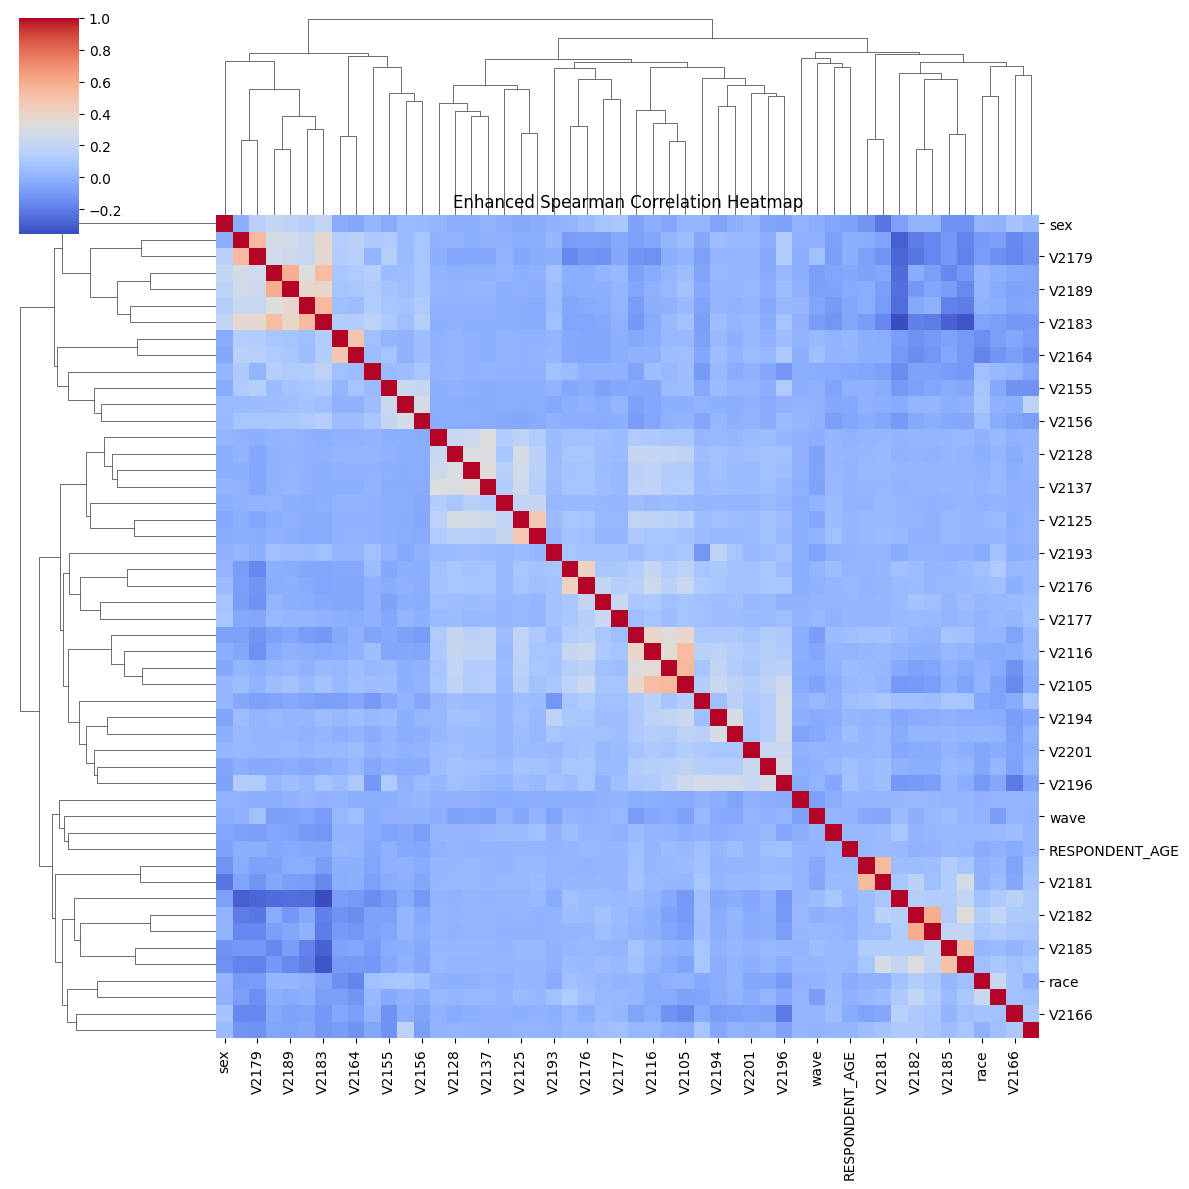


Highly correlated variable pairs (|corr| > 0.5):
  Variable1 Variable2  Correlation
0     V2188     V2183     0.536921
1     V2184     V2189     0.583240
2     V2184     V2183     0.526226
3     V2186     V2181     0.534619
4     V2173     V2179     0.538661
5     V2116     V2105     0.532954
6     V2182     V2187     0.594918
7     V2185     V2180     0.507020
8     V2108     V2105     0.542470


In [8]:
# Correlation Analysis
# Select numeric variables (excluding the target variable 'nicotine12d' if desired).
cor_vars = new_data.drop(columns=['nicotine12d'], errors='ignore').select_dtypes(include=[np.number])

# Compute the Spearman correlation matrix.
cor_matrix_spearman = cor_vars.corr(method='spearman')

# Check for non-finite values in the correlation matrix.
if not np.all(np.isfinite(cor_matrix_spearman)):
    print("\nWarning: Non-finite values detected in the correlation matrix.")
    # Replace NaN or infinite values with 0 (or another appropriate value).
    cor_matrix_spearman = cor_matrix_spearman.fillna(0)
    cor_matrix_spearman = cor_matrix_spearman.replace([np.inf, -np.inf], 0)

print("\nSpearman Correlation Matrix:")
print(cor_matrix_spearman)

# Create an enhanced heatmap with clustering.
clustergrid = sns.clustermap(cor_matrix_spearman, cmap="coolwarm", figsize=(12, 12))
clustergrid.ax_heatmap.set_title("Enhanced Spearman Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (absolute correlation > 0.5 and less than 1).
high_corr_pairs = []
cols = cor_matrix_spearman.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_value = cor_matrix_spearman.iloc[i, j]
        if 0.5 < abs(corr_value) < 1:
            high_corr_pairs.append({
                "Variable1": cols[i],
                "Variable2": cols[j],
                "Correlation": corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
print("\nHighly correlated variable pairs (|corr| > 0.5):")
print(high_corr_df)

In [5]:
# --- Identify & Convert Categorical Columns ---
import logging

# Identify all categorical (object or categorical dtype) columns
categorical_predictor_cols = new_data.select_dtypes(include=['object', 'category']).columns.tolist()

# If you also want to include numerical columns as categorical (optional)
# categorical_predictor_cols = new_data.columns.tolist()  

# Convert identified columns to categorical
convert_to_categorical(new_data, categorical_predictor_cols)

# Logging information
logging.info("Verifying data types after conversion:")
logging.info(new_data[categorical_predictor_cols].dtypes)

# --- Train/Test Split ---
X = new_data.drop('nicotine12d', axis=1)
y = new_data['nicotine12d']
X_train, X_test, y_train, y_test = create_train_test_split(X, y)

logging.info("Train Set Balance:")
logging.info(y_train.value_counts(normalize=True))
logging.info("Test Set Balance:")
logging.info(y_test.value_counts(normalize=True))

# --- Missing Value Indicators ---
X_train_with_indicators, X_test_with_indicators = create_missing_indicators(X_train, X_test)

# Treat everything as categorical in this example
categorical_features = X_train_with_indicators.columns.tolist()

# Create & Fit Preprocessor
preprocessor = create_preprocessor(categorical_features)
preprocessor.fit(X_train_with_indicators)
logging.info("Preprocessor fitted successfully.")

2025-02-20 17:14:47,055 - INFO - Categorical conversion complete.
2025-02-20 17:14:47,056 - INFO - Verifying data types after conversion:
2025-02-20 17:14:47,057 - INFO - Series([], dtype: object)
2025-02-20 17:14:47,082 - INFO - Training set shape: (26184, 50)
2025-02-20 17:14:47,083 - INFO - Testing set shape: (6546, 50)
2025-02-20 17:14:47,083 - INFO - Train Set Balance:
2025-02-20 17:14:47,086 - INFO - 1.0    0.552589
0.0    0.447411
Name: nicotine12d, dtype: float64
2025-02-20 17:14:47,088 - INFO - Test Set Balance:
2025-02-20 17:14:47,089 - INFO - 1.0    0.552551
0.0    0.447449
Name: nicotine12d, dtype: float64
2025-02-20 17:14:47,114 - INFO - Missing indicators created.
2025-02-20 17:14:47,631 - INFO - Preprocessor fitted successfully.


# Model Training

## Lasso

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best Parameters: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 2000, 'classifier__tol': 0.01, 'preprocessor__cat__onehot__drop': 'first'}
Best ROC AUC: 0.745313422854059


2025-02-14 13:46:51,624 - INFO - === Tuned LASSO Logistic Regression Evaluation ===
2025-02-14 13:46:51,632 - INFO - Confusion Matrix:
[[2030  899]
 [ 941 2676]]
2025-02-14 13:46:51,646 - INFO - 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.69      2929
         1.0       0.75      0.74      0.74      3617

    accuracy                           0.72      6546
   macro avg       0.72      0.72      0.72      6546
weighted avg       0.72      0.72      0.72      6546

2025-02-14 13:46:51,651 - INFO - ROC AUC: 0.7425


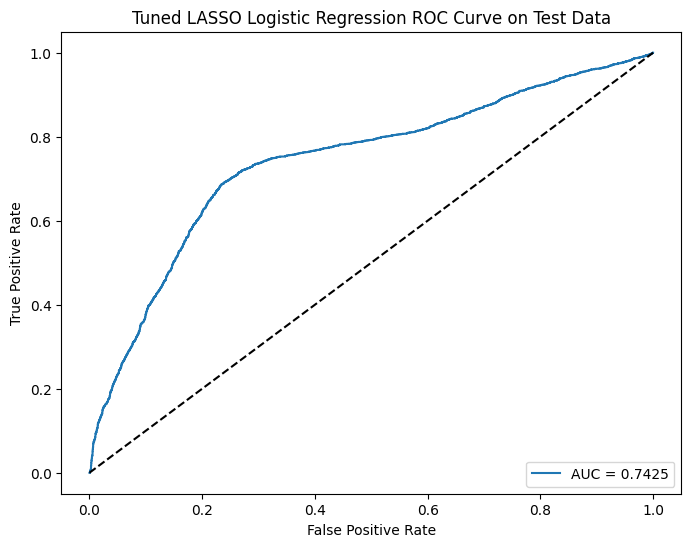

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['V2178', 'V2188', 'V2197', 'V2184', 'V2186', 'V2171', 'V2128', 'V2201',
       'V2173', 'V2194', 'V2166', 'wave', 'V2176', 'V2175', 'V2177', 'V2116',
       'V2125', 'V2182', 'sex', 'race', 'V2460', 'RESPONDENT_AGE',...
       'V2172', 'V2137', 'V2140', 'V2105', 'V2157', 'V2183', 'V2187', 'V2181',
       'V2152', 'V2153', 'V2156'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=2000, penalty='l1', solver='saga',
                                    tol=0.01))])

In [8]:
# Define the preprocessing for numeric columns (scale them)
numeric_features = X_train_with_indicators.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the preprocessing for categorical features (encode them)
categorical_features = X_train_with_indicators.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the pipeline
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(penalty='l1', solver='saga'))])
# Define an expanded tuning grid.
# - 'classifier__C': A wide range of regularization strengths.
# - 'classifier__tol': Different tolerance levels for stopping criteria.
# - 'classifier__max_iter': More iterations to ensure convergence.
# - 'preprocessor__cat__drop': Option to drop the first level or keep all levels.
param_grid = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
    'classifier__max_iter': [1000, 2000, 5000],
    # Tune whether to drop the first level for categorical features or not.
    'preprocessor__cat__onehot__drop': [None, 'first'],
    # Experiment with class weights (None or 'balanced') to help if classes are imbalanced.
    'classifier__class_weight': [None, 'balanced']
}

# Define a cross-validation strategy.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize GridSearchCV with your pipeline (lasso_pipeline)
grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# Display the best parameters and the best ROC AUC achieved during cross-validation.
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

# Use the best estimator to evaluate performance on the test data.
best_lasso_model = grid_search.best_estimator_
train_evaluate_model(
    model=best_lasso_model,
    X_train=X_train_with_indicators,
    y_train=y_train,
    X_test=X_test_with_indicators,
    y_test=y_test,
    model_name="Tuned LASSO Logistic Regression"
)


Top 20 Aggregated Feature Importances (by absolute coefficient value):
wave     0.917893
V2116    0.204811
V2137    0.107522
sex      0.096266
V2105    0.092966
V2166    0.086576
V2134    0.079518
V2128    0.074483
V13      0.067082
V2101    0.058904
V2143    0.052490
V2176    0.051462
V2187    0.046222
V2179    0.045720
V2193    0.045389
V2153    0.045158
V2188    0.039777
V2157    0.038560
V2182    0.038260
V2194    0.037967
dtype: float64


/tmp/ipykernel_1545623/809380159.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_features.values, y=top20_features.index, palette="viridis")


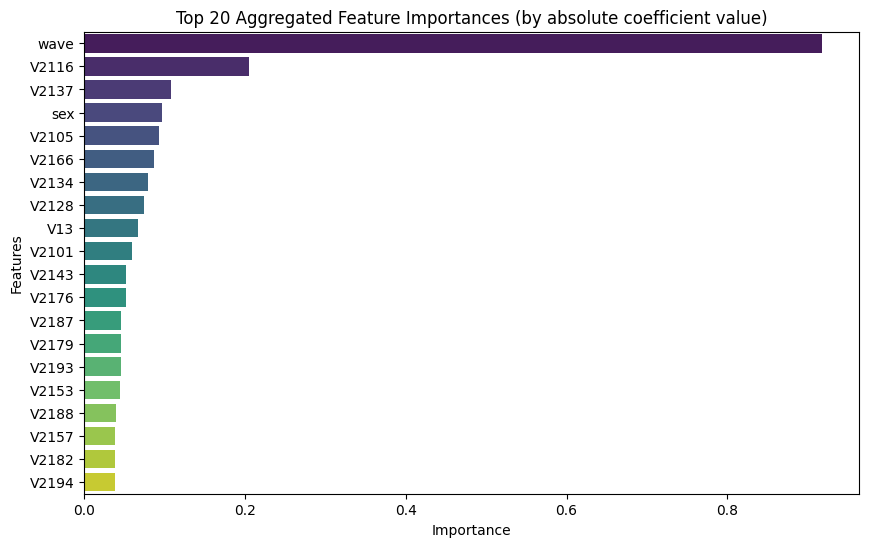

In [9]:
import numpy as np
import pandas as pd

# Assume 'best_lasso_model' is your already fitted pipeline from GridSearchCV.
# Extract the logistic regression model from the pipeline.
lr = best_lasso_model.named_steps['classifier']

# For binary classification, lr.coef_ has shape (1, n_features)
coefficients = lr.coef_[0]

# Get the preprocessor (the ColumnTransformer) from the pipeline.
preprocessor = best_lasso_model.named_steps['preprocessor']

# -------------------------------
# 1. Numeric Features and Importances
# -------------------------------
# The numeric transformer was applied first.
numeric_features = preprocessor.transformers_[0][2]  # list (or Index) of numeric feature names
n_numeric = len(numeric_features)
numeric_coefs = coefficients[:n_numeric]
numeric_importances = pd.Series(np.abs(numeric_coefs), index=numeric_features)

# -------------------------------
# 2. Categorical Features (Aggregation)
# -------------------------------
# Get the original categorical columns from the transformer.
cat_features = preprocessor.transformers_[1][2]

# Check if there are any categorical features
if len(cat_features) > 0:
    # Retrieve the OneHotEncoder from the categorical pipeline.
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    # The remaining coefficients correspond to the one-hot encoded features.
    categorical_coefs = coefficients[n_numeric:]
    
    aggregated_cat_importance = {}
    start_idx = 0
    # Loop over each original categorical feature and its categories.
    for feature, categories in zip(cat_features, onehot_encoder.categories_):
        n_categories = len(categories)
        # Get the coefficients for the dummy columns of this feature.
        feature_coefs = categorical_coefs[start_idx:start_idx + n_categories]
        # Aggregate by summing the absolute values.
        aggregated_cat_importance[feature] = np.sum(np.abs(feature_coefs))
        start_idx += n_categories

    aggregated_cat_importance = pd.Series(aggregated_cat_importance)
else:
    # If there are no categorical features, create an empty Series.
    aggregated_cat_importance = pd.Series(dtype=float)

# -------------------------------
# 3. Combine and Select Top 20
# -------------------------------
combined_importances = pd.concat([numeric_importances, aggregated_cat_importance])
top20_features = combined_importances.sort_values(ascending=False).head(20)

print("Top 20 Aggregated Feature Importances (by absolute coefficient value):")
print(top20_features)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top20_features.values, y=top20_features.index, palette="viridis")
plt.title('Top 20 Aggregated Feature Importances (by absolute coefficient value)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


/tmp/ipykernel_1489303/241353914.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(20), palette='magma')


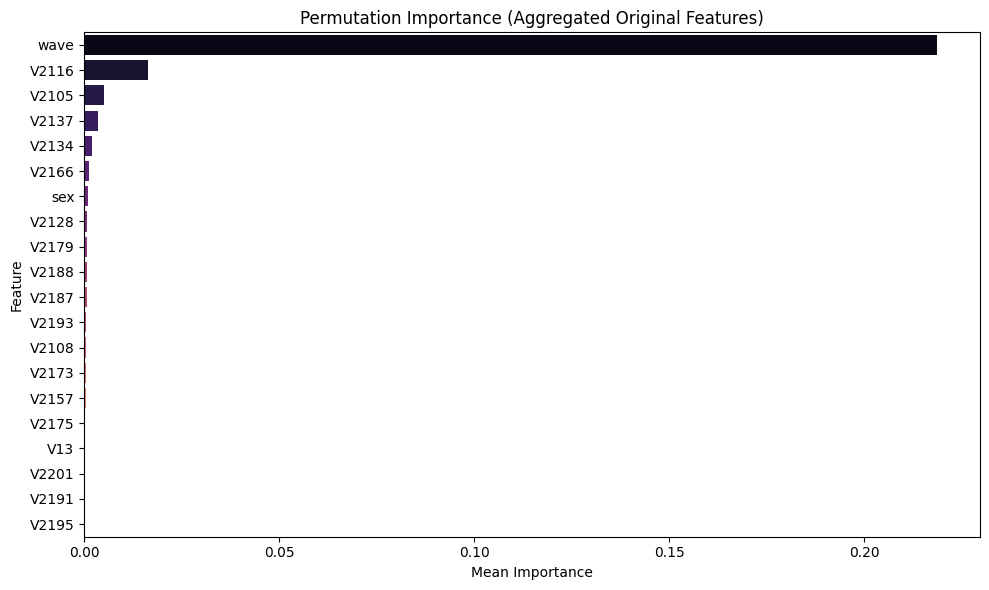

   Feature  Importance
11    wave    0.218731
15   V2116    0.016337
42   V2105    0.004965
40   V2137    0.003549
38   V2134    0.002059
10   V2166    0.001284
18     sex    0.001066
6    V2128    0.000694
35   V2179    0.000675
1    V2188    0.000622
45   V2187    0.000611
23   V2193    0.000493
26   V2108    0.000476
8    V2173    0.000444
43   V2157    0.000364
13   V2175    0.000297
36     V13    0.000294
7    V2201    0.000282
30   V2191    0.000265
31   V2195    0.000249


In [34]:
#########################################
# 2. Permutation Importance (Aggregated by Original Feature)
#########################################

from sklearn.inspection import permutation_importance

# Compute permutation importance using the original features (X_test_with_indicators).
perm_results = permutation_importance(
    best_lasso_model,
    X_test_with_indicators,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=RANDOM_STATE
)

perm_imp_df = pd.DataFrame({
    'Feature': X_test_with_indicators.columns,
    'Importance': perm_results.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(20), palette='magma')
plt.title("Permutation Importance (Aggregated Original Features)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Display the top 20 features by permutation importance
print(perm_imp_df.head(20))



Top 20 Important Features:
   Feature  Importance
11    wave    0.831211
15   V2116    0.154883
18     sex    0.096673
42   V2105    0.079273
10   V2166    0.075389
36     V13    0.059174
27   V2101    0.049204
45   V2187    0.042473
43   V2157    0.037265
1    V2188    0.036909
35   V2179    0.035972
12   V2176    0.033787
23   V2193    0.033327
17   V2182    0.032703
9    V2194    0.029956
30   V2191    0.027242
48   V2153    0.026061
8    V2173    0.024039
13   V2175    0.023854
40   V2137    0.021965


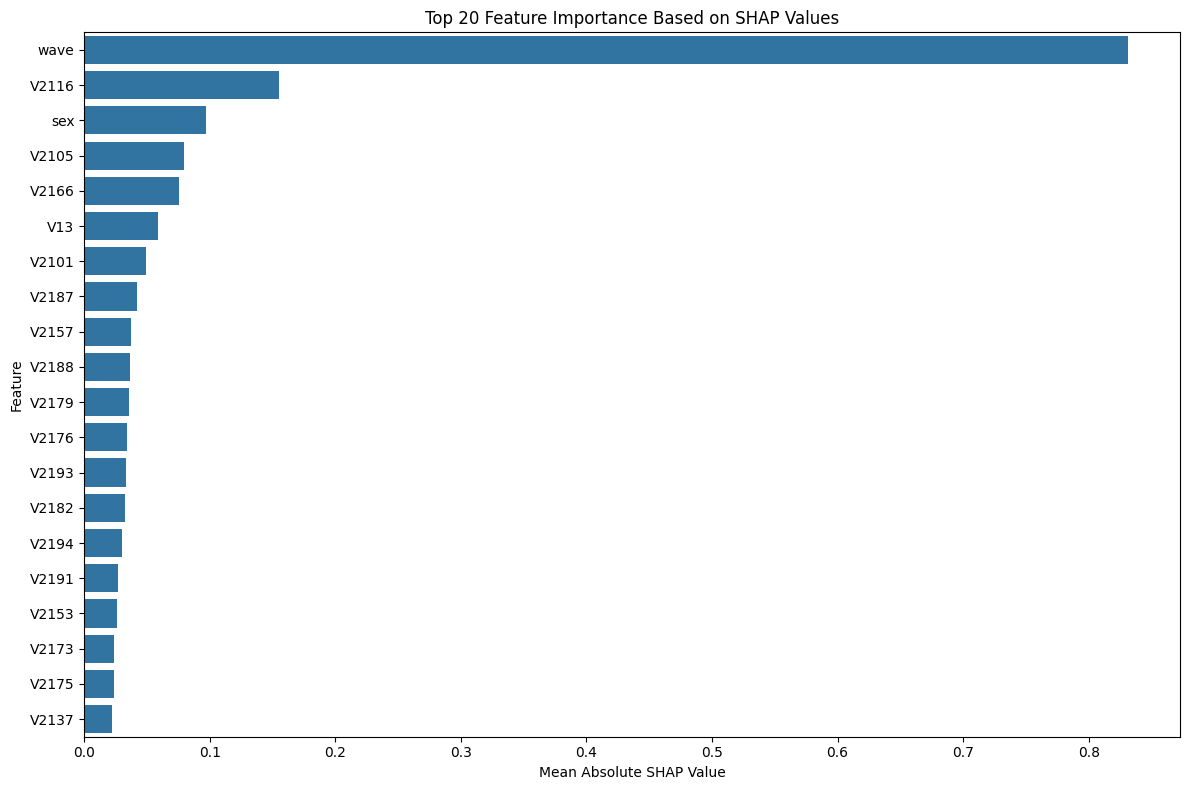

In [10]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names (only using available features)
feature_names = numeric_features

# Calculate SHAP values for numeric features
explainer = shap.LinearExplainer(
    best_lasso_model.named_steps['classifier'],
    best_lasso_model.named_steps['preprocessor'].transform(X_train_with_indicators)
)
shap_values = explainer.shap_values(
    best_lasso_model.named_steps['preprocessor'].transform(X_train_with_indicators)
)

# Calculate feature importance (using absolute mean SHAP values)
feature_importance = {}
for idx, feature in enumerate(feature_names):
    if idx < shap_values.shape[1]:  # Only process features within bounds
        feature_importance[feature] = np.abs(shap_values[:, idx]).mean()

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values('Importance', ascending=False)

# Display top 20 features
print("\nTop 20 Important Features:")
print(importance_df.head(20))

# Create visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importance Based on SHAP Values')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Top 10 Features: ['wave', 'V2116', 'sex', 'V2105', 'V2166', 'V13', 'V2101', 'V2187', 'V2157', 'V2188']
wave: int64
V2116: float64
sex: float64
V2105: float64
V2166: float64
V13: int64
V2101: float64
V2187: float64
V2157: float64
V2188: float64
Unique Values in Top 10 Features:
wave: [2019 2018 2017 2022 2023 2021 2020]
V2116: [nan  2.  1.  3.  7.  4.  6.  5.]
sex: [0. 1.]
V2105: [ 1.  6.  2.  3.  4.  5.  7. nan]
V2166: [nan  2.  4.  6.  1.  5.  3.  8.  7.]
V13: [2 4 3 1]
V2101: [ 1.  2.  3.  4. nan  5.]
V2187: [ 0.  1. nan]
V2157: [ 1.  0. nan]
V2188: [ 1.  0. nan]
Error plotting PDP for sex: cannot reshape array of size 1 into shape (2)


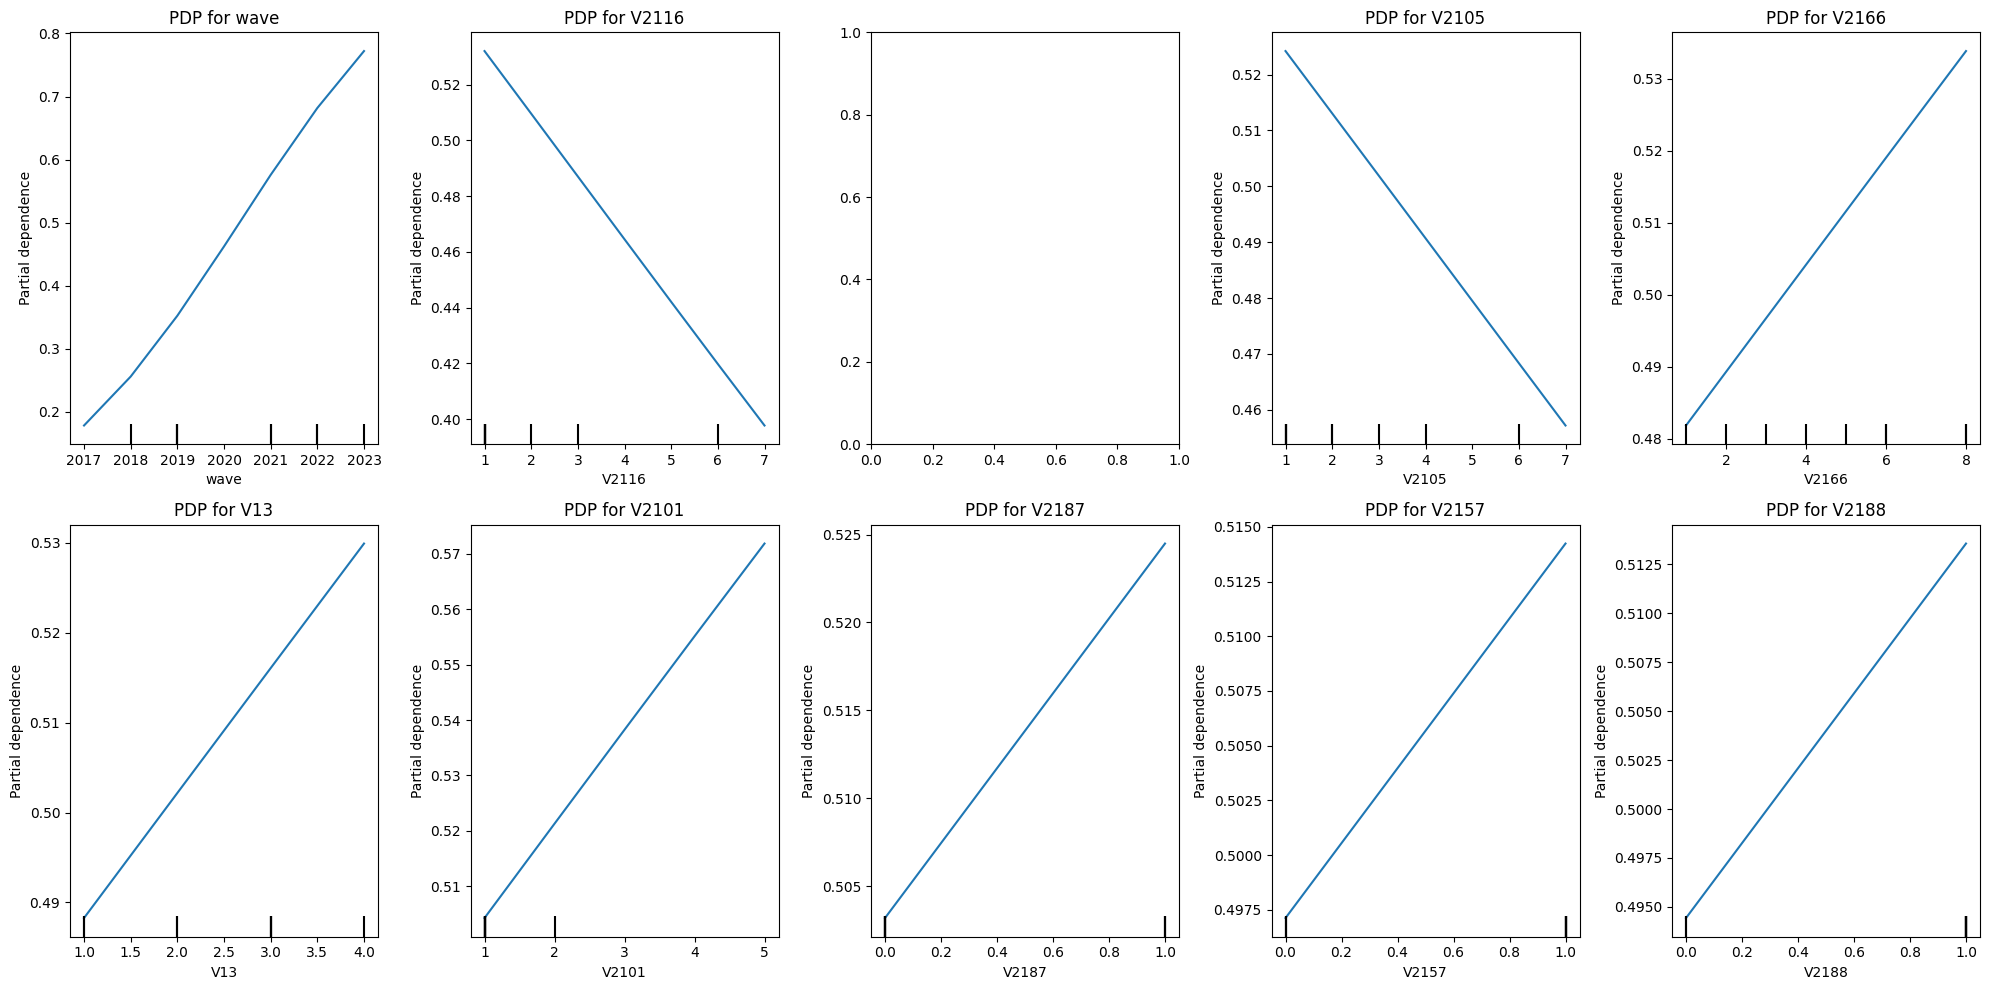

In [23]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top_10_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_10_features)
for feature in top_10_features:
    print(f"{feature}: {X_train_with_indicators[feature].dtype}")

print("Unique Values in Top 10 Features:")
for feature in top_10_features:
    unique_values = X_train_with_indicators[feature].unique()
    print(f"{feature}: {unique_values}")

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for i, feature in enumerate(top_10_features):
    if len(X_train_with_indicators[feature].unique()) > 1:
        try:
            PartialDependenceDisplay.from_estimator(
                best_lasso_model,
                X_train_with_indicators,
                features=[feature],
                ax=axes[i]
            )
            axes[i].set_title(f'PDP for {feature}')
        except ValueError as e:
            print(f"Error plotting PDP for {feature}: {e}")
    else:
        print(f"Skipping PDP for {feature}: Only one unique value in the dataset.")
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [24]:
#############################
# Degree 2 Interaction 
###############################

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set a random state for reproducibility.
RANDOM_STATE = 42

# ----------------------------
# 1. Build the Pipeline
# ----------------------------
# This pipeline consists of:
#  - preprocessor: your existing preprocessor for data cleaning/encoding.
#  - poly: PolynomialFeatures with degree 2 (pairwise interactions only, no bias).
#  - classifier: LogisticRegression with L1 penalty (sparse model) using the liblinear solver.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=RANDOM_STATE,
        max_iter=1000
    ))
])

# ----------------------------
# 2. Set Up Hyperparameter Tuning
# ----------------------------
# Here we define a parameter grid for tuning.
# In this example, we tune the inverse regularization strength 'C' for logistic regression.
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # 'saga' could also be tested if using larger datasets
    'classifier__max_iter': [500, 1000],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}


# ----------------------------
# 3. Create and Fit GridSearchCV
# ----------------------------
# We use 5-fold cross-validation and accuracy as the scoring metric.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,    # Use all available CPU cores.
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(test_accuracy))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.01}
Best cross-validation accuracy: 0.8037
Test set accuracy: 0.8093


Best hyperparameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.01}
Best cross-validation accuracy: 0.8037
Test set accuracy: 0.8093
Test set ROC AUC: 0.8758
Test set F1 score: 0.8286

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79      2929
         1.0       0.82      0.83      0.83      3617

    accuracy                           0.81      6546
   macro avg       0.81      0.81      0.81      6546
weighted avg       0.81      0.81      0.81      6546



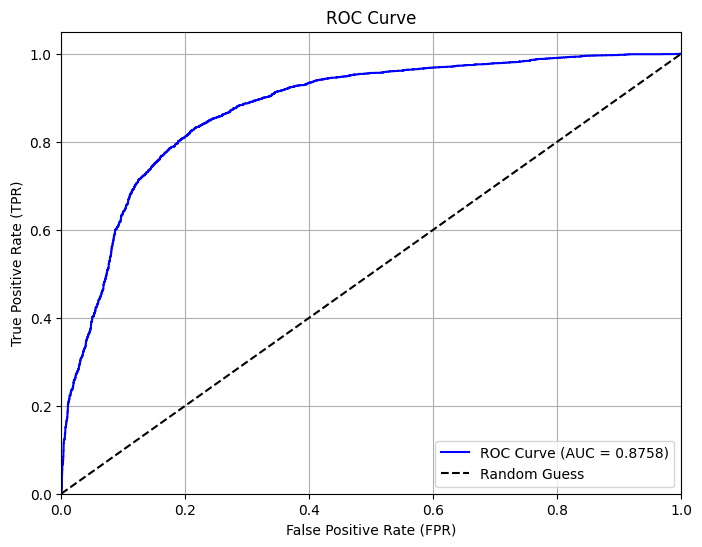

In [25]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    roc_curve  # For ROC curve
)
import matplotlib.pyplot as plt  # For plotting

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]  # Get probabilities for the positive class

# Calculate additional metrics
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("Test set accuracy: {:.4f}".format(test_accuracy))
print("Test set ROC AUC: {:.4f}".format(roc_auc))
print("Test set F1 score: {:.4f}".format(f1))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------
# 5. Plot the ROC Curve
# ----------------------------
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:
     feature_combination  aggregated_importance
189        (V2105, wave)               0.664864
278        (V2116, wave)               0.587994
143        (V2101, wave)               0.406701
1203       (V2196, wave)               0.244442
1188       (V2194, wave)               0.116426
789        (V2166, wave)               0.114012
1214       (V2201, wave)               0.110926
1169       (V2191, wave)               0.092729
1088       (V2184, wave)               0.070952
1196       (V2195, wave)               0.064390
873        (V2173, wave)               0.062596
96           (V13, wave)               0.058666
1224         (sex, wave)               0.042238
924        (V2176, wave)               0.038159
1146       (V2188, wave)               0.035029
818        (V2171, wave)               0.031464
899        (V2175, wave)               0.029978
1119       (V2186, wave)               0.027526
558        (V2152

/tmp/ipykernel_1545623/3475757056.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


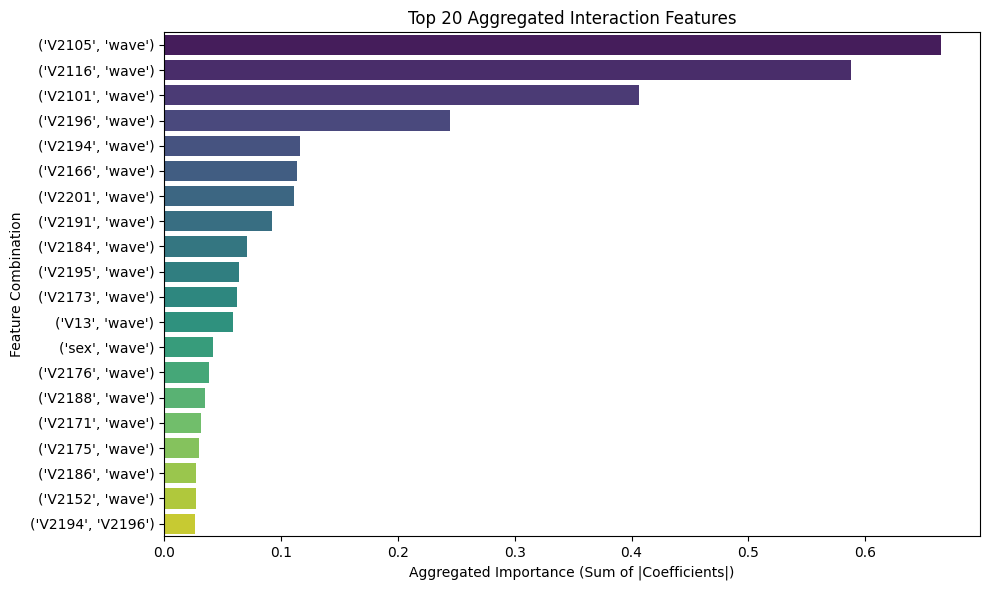

In [26]:
# -----------------------------
# Step 1: Retrieve One-Hot Encoded Feature Names
# -----------------------------
# Access the pipeline for categorical features
num_pipeline = best_model.named_steps['preprocessor'].named_transformers_['num']
# Then access the OneHotEncoder within that pipeline
ohe = num_pipeline.named_steps['scaler']
# Now get the encoded feature names
encoded_feature_names = ohe.get_feature_names_out(numeric_features)


# -----------------------------
# Step 2: Retrieve Interaction Feature Names
# -----------------------------
# Get the feature names after applying PolynomialFeatures (which created interaction terms)
interaction_transformer = best_model.named_steps['poly']  # Corrected step name here
interaction_feature_names = interaction_transformer.get_feature_names_out(encoded_feature_names)

# -----------------------------
# Step 3: Extract Classifier Coefficients
# -----------------------------
# For binary classification, the classifier’s coef_ is an array of shape (1, n_features)
coefficients = best_model.named_steps['classifier'].coef_[0]

# Build a DataFrame mapping each expanded feature (both main effects and interactions) to its coefficient
features_df = pd.DataFrame({
    'interaction_feature': interaction_feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
})

# -----------------------------
# Step 4: Filter for Interaction Features Only
# -----------------------------
# With interaction_only=True, main effects do not contain a space, while interaction terms do.
interaction_df = features_df[features_df['interaction_feature'].str.contains(' ')].copy()

# -----------------------------
# Step 5: Aggregate to Original Feature Combinations
# -----------------------------
# Define a function to extract the original feature names from an interaction term.
def extract_original_features(interaction_term):
    # For example, "V13_A V2152_B" or "V13_A V2152_B V49_Low"
    parts = interaction_term.split(' ')
    # Extract the original feature name from each part (everything before the underscore)
    original_features = [part.split('_')[0] for part in parts]
    # Sort the features so order doesn't matter (e.g., ('V13', 'V2152') is the same as ('V2152', 'V13'))
    return tuple(sorted(original_features))

# Create a new column for the aggregated original feature combination
interaction_df['feature_combination'] = interaction_df['interaction_feature'].apply(extract_original_features)

# Group by the original feature combination and sum the absolute coefficient values as a measure of importance
agg_interactions = (
    interaction_df.groupby('feature_combination')['abs_coef']
    .sum()
    .reset_index()
    .rename(columns={'abs_coef': 'aggregated_importance'})
)

# Sort the aggregated interactions by importance in descending order
agg_interactions = agg_interactions.sort_values('aggregated_importance', ascending=False)

# -----------------------------
# Step 6: Display the Top 20 Aggregated Interaction Features
# -----------------------------
top20_agg_interactions = agg_interactions.head(20)
print("Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:")
print(top20_agg_interactions)

# Optionally, plot the results.
plt.figure(figsize=(10, 6))
sns.barplot(
    x='aggregated_importance',
    y=top20_agg_interactions['feature_combination'].astype(str),
    data=top20_agg_interactions,
    palette='viridis'
)
plt.title("Top 20 Aggregated Interaction Features")
plt.xlabel("Aggregated Importance (Sum of |Coefficients|)")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

In [29]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set a random state for reproducibility.
RANDOM_STATE = 42

# ----------------------------
# 1. Build the Pipeline
# ----------------------------
# This pipeline consists of:
#  - preprocessor: your existing preprocessor for data cleaning/encoding.
#  - poly: PolynomialFeatures with degree 2 (pairwise interactions only, no bias).
#  - classifier: LogisticRegression with L1 penalty (sparse model) using the liblinear solver.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=RANDOM_STATE,
        max_iter=500
    ))
])

# ----------------------------
# 2. Set Up Hyperparameter Tuning
# ----------------------------
# Here we define a parameter grid for tuning.
# In this example, we tune the inverse regularization strength 'C' for logistic regression.
param_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [500, 1000],
    'classifier__tol': [1e-4]
}


# ----------------------------
# 3. Create and Fit GridSearchCV
# ----------------------------
# We use 5-fold cross-validation and accuracy as the scoring metric.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=8,    # need to adjust accordingly to precent memory overflow.
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(test_accuracy))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best hyperparameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8030
Test set accuracy: 0.8008


Best hyperparameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8030
Test set accuracy: 0.8008
Test set ROC AUC: 0.8729
Test set F1 score: 0.8210

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78      2929
         1.0       0.82      0.83      0.82      3617

    accuracy                           0.80      6546
   macro avg       0.80      0.80      0.80      6546
weighted avg       0.80      0.80      0.80      6546



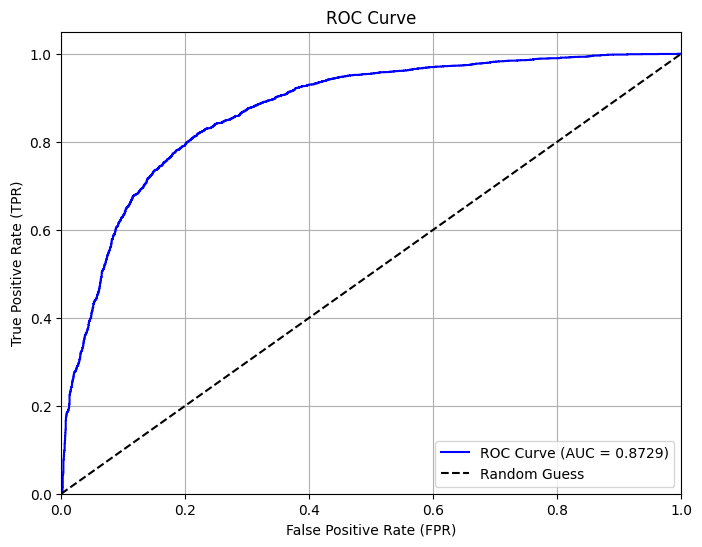

In [30]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    roc_curve  # For ROC curve
)
import matplotlib.pyplot as plt  # For plotting

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]  # Get probabilities for the positive class

# Calculate additional metrics
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("Test set accuracy: {:.4f}".format(test_accuracy))
print("Test set ROC AUC: {:.4f}".format(roc_auc))
print("Test set F1 score: {:.4f}".format(f1))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------
# 5. Plot the ROC Curve
# ----------------------------
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:
        feature_combination  aggregated_importance
6634          (V2116, wave)               0.732379
4609          (V2105, wave)               0.708883
3528          (V2101, wave)               0.525570
20768         (V2196, wave)               0.228015
3619   (V2105, V2116, wave)               0.192851
5644          (V2108, wave)               0.167442
20704         (V2194, wave)               0.127520
20804         (V2201, wave)               0.115384
2447   (V2101, V2105, wave)               0.102783
16329         (V2166, wave)               0.098145
20604         (V2191, wave)               0.092698
20740         (V2195, wave)               0.084765
3574   (V2105, V2108, wave)               0.083104
2397      (V13, race, wave)               0.080824
18224         (V2176, wave)               0.079418
17548         (V2173, wave)               0.063086
2538   (V2101, V2116, wave)               0.050391
14872  (V21

/tmp/ipykernel_1545623/3089346036.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


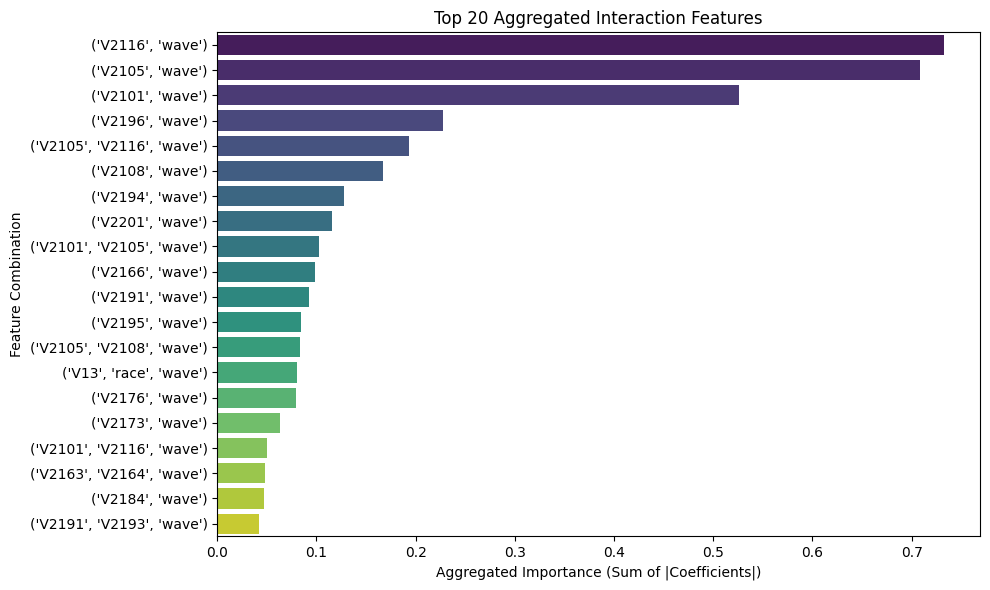

In [31]:
# -----------------------------
# Step 1: Retrieve One-Hot Encoded Feature Names
# -----------------------------
# Access the pipeline for categorical features
num_pipeline = best_model.named_steps['preprocessor'].named_transformers_['num']
# Then access the OneHotEncoder within that pipeline
ohe = num_pipeline.named_steps['scaler']
# Now get the encoded feature names
encoded_feature_names = ohe.get_feature_names_out(numeric_features)

# -----------------------------
# Step 2: Retrieve Interaction Feature Names
# -----------------------------
# Get the feature names after applying PolynomialFeatures (which created interaction terms)
interaction_transformer = best_model.named_steps['poly']  # Corrected step name here
interaction_feature_names = interaction_transformer.get_feature_names_out(encoded_feature_names)

# -----------------------------
# Step 3: Extract Classifier Coefficients
# -----------------------------
# For binary classification, the classifier’s coef_ is an array of shape (1, n_features)
coefficients = best_model.named_steps['classifier'].coef_[0]

# Build a DataFrame mapping each expanded feature (both main effects and interactions) to its coefficient
features_df = pd.DataFrame({
    'interaction_feature': interaction_feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
})

# -----------------------------
# Step 4: Filter for Interaction Features Only
# -----------------------------
# With interaction_only=True, main effects do not contain a space, while interaction terms do.
interaction_df = features_df[features_df['interaction_feature'].str.contains(' ')].copy()

# -----------------------------
# Step 5: Aggregate to Original Feature Combinations
# -----------------------------
# Define a function to extract the original feature names from an interaction term.
def extract_original_features(interaction_term):
    # For example, "V13_A V2152_B" or "V13_A V2152_B V49_Low"
    parts = interaction_term.split(' ')
    # Extract the original feature name from each part (everything before the underscore)
    original_features = [part.split('_')[0] for part in parts]
    # Sort the features so order doesn't matter (e.g., ('V13', 'V2152') is the same as ('V2152', 'V13'))
    return tuple(sorted(original_features))

# Create a new column for the aggregated original feature combination
interaction_df['feature_combination'] = interaction_df['interaction_feature'].apply(extract_original_features)

# Group by the original feature combination and sum the absolute coefficient values as a measure of importance
agg_interactions = (
    interaction_df.groupby('feature_combination')['abs_coef']
    .sum()
    .reset_index()
    .rename(columns={'abs_coef': 'aggregated_importance'})
)

# Sort the aggregated interactions by importance in descending order
agg_interactions = agg_interactions.sort_values('aggregated_importance', ascending=False)

# -----------------------------
# Step 6: Display the Top 20 Aggregated Interaction Features
# -----------------------------
top20_agg_interactions = agg_interactions.head(20)
print("Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:")
print(top20_agg_interactions)

# Optionally, plot the results.
plt.figure(figsize=(10, 6))
sns.barplot(
    x='aggregated_importance',
    y=top20_agg_interactions['feature_combination'].astype(str),
    data=top20_agg_interactions,
    palette='viridis'
)
plt.title("Top 20 Aggregated Interaction Features")
plt.xlabel("Aggregated Importance (Sum of |Coefficients|)")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

## Random Forest Classifier

2025-02-14 11:32:08,285 - INFO - 
--- Random Forest (Revised) ---
2025-02-14 11:32:08,287 - INFO - Starting randomized search for Random Forest...


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-02-14 11:34:57,748 - INFO - Best parameters (RF): {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 10, 'classifier__max_features': 0.3, 'classifier__max_depth': 20, 'classifier__class_weight': None, 'classifier__bootstrap': False}
2025-02-14 11:34:57,750 - INFO - Best cross-validation roc_auc: 0.9151
2025-02-14 11:35:09,935 - INFO - === Best Random Forest Evaluation ===
2025-02-14 11:35:09,942 - INFO - Confusion Matrix:
[[2373  556]
 [ 543 3074]]
2025-02-14 11:35:09,955 - INFO - 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      2929
         1.0       0.85      0.85    

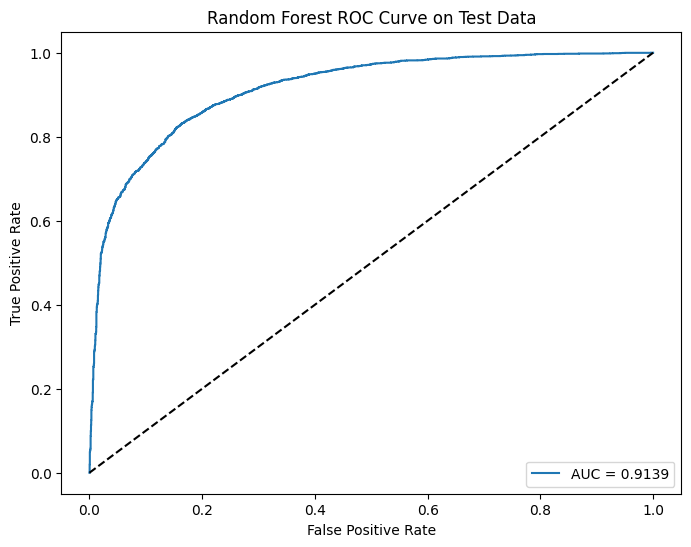

2025-02-14 11:35:10,129 - INFO - Script completed successfully.


In [59]:
# Define Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Random Forest (Revised) ---")

# Build pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Parameter for RandomizedSearch
rf_param_dist = {
    'classifier__n_estimators': [100, 200, 500, 1000],
    'classifier__max_depth': [5, 10, 20, 50],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],  # Mix of float and string
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced']
}

try:
    logging.info("Starting randomized search for Random Forest...")
    
    # Use RepeatedStratifiedKFold without shuffle
    cv_rf = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )
    
    # RandomizedSearchCV to cover more combinations within reasonable compute time
    rf_random_search = RandomizedSearchCV(
        estimator=rf_pipeline,
        param_distributions=rf_param_dist,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_rf,
        scoring=SCORING_METRIC,
        n_jobs=-1,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )
    
    # Fit the RandomizedSearchCV
    rf_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (RF): {rf_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {rf_random_search.best_score_:.4f}")
    
    # Extract the best estimator
    best_rf = rf_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Random Forest randomized search: {e}")
    raise

# Evaluate the best Random Forest
try:
    best_rf.fit(X_train_with_indicators, y_train)
    y_pred_rf = best_rf.predict(X_test_with_indicators)
    y_pred_proba_rf = best_rf.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Random Forest Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_rf)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_rf)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

    # Plot ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Random Forest training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [60]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib')

# Save the trained model
joblib.dump(best_rf, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-14 11:35:21,792 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_rf_model.joblib


In [8]:
# Load the model from the specified path
logging.info("Loading the model...")
best_rf = joblib.load(os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib'))
logging.info("Model loaded successfull")

2025-02-19 17:49:45,872 - INFO - Loading the model...
2025-02-19 17:49:45,992 - INFO - Model loaded successfull


2025-02-14 11:35:31,865 - INFO - Starting feature importance analysis...
2025-02-14 11:35:31,890 - INFO - Shape of X_train_with_indicators: (26184, 100)
2025-02-14 11:35:31,890 - INFO - Length of feature_importance: 50
2025-02-14 11:35:31,891 - INFO - Number of feature names: 50
2025-02-14 11:35:31,891 - INFO - Feature names: ['num__V2178' 'num__V2188' 'num__V2197' 'num__V2184' 'num__V2186'
 'num__V2171' 'num__V2128' 'num__V2201' 'num__V2173' 'num__V2194'
 'num__V2166' 'num__wave' 'num__V2176' 'num__V2175' 'num__V2177'
 'num__V2116' 'num__V2125' 'num__V2182' 'num__sex' 'num__race'
 'num__V2460' 'num__RESPONDENT_AGE' 'num__V2185' 'num__V2193' 'num__V2163'
 'num__V49' 'num__V2108' 'num__V2101' 'num__V2180' 'num__V2164'
 'num__V2191' 'num__V2195' 'num__V2155' 'num__V2196' 'num__V2189'
 'num__V2179' 'num__V13' 'num__V2143' 'num__V2134' 'num__V2172'
 'num__V2137' 'num__V2140' 'num__V2105' 'num__V2157' 'num__V2183'
 'num__V2187' 'num__V2181' 'num__V2152' 'num__V2153' 'num__V2156']
/tmp/ipyke

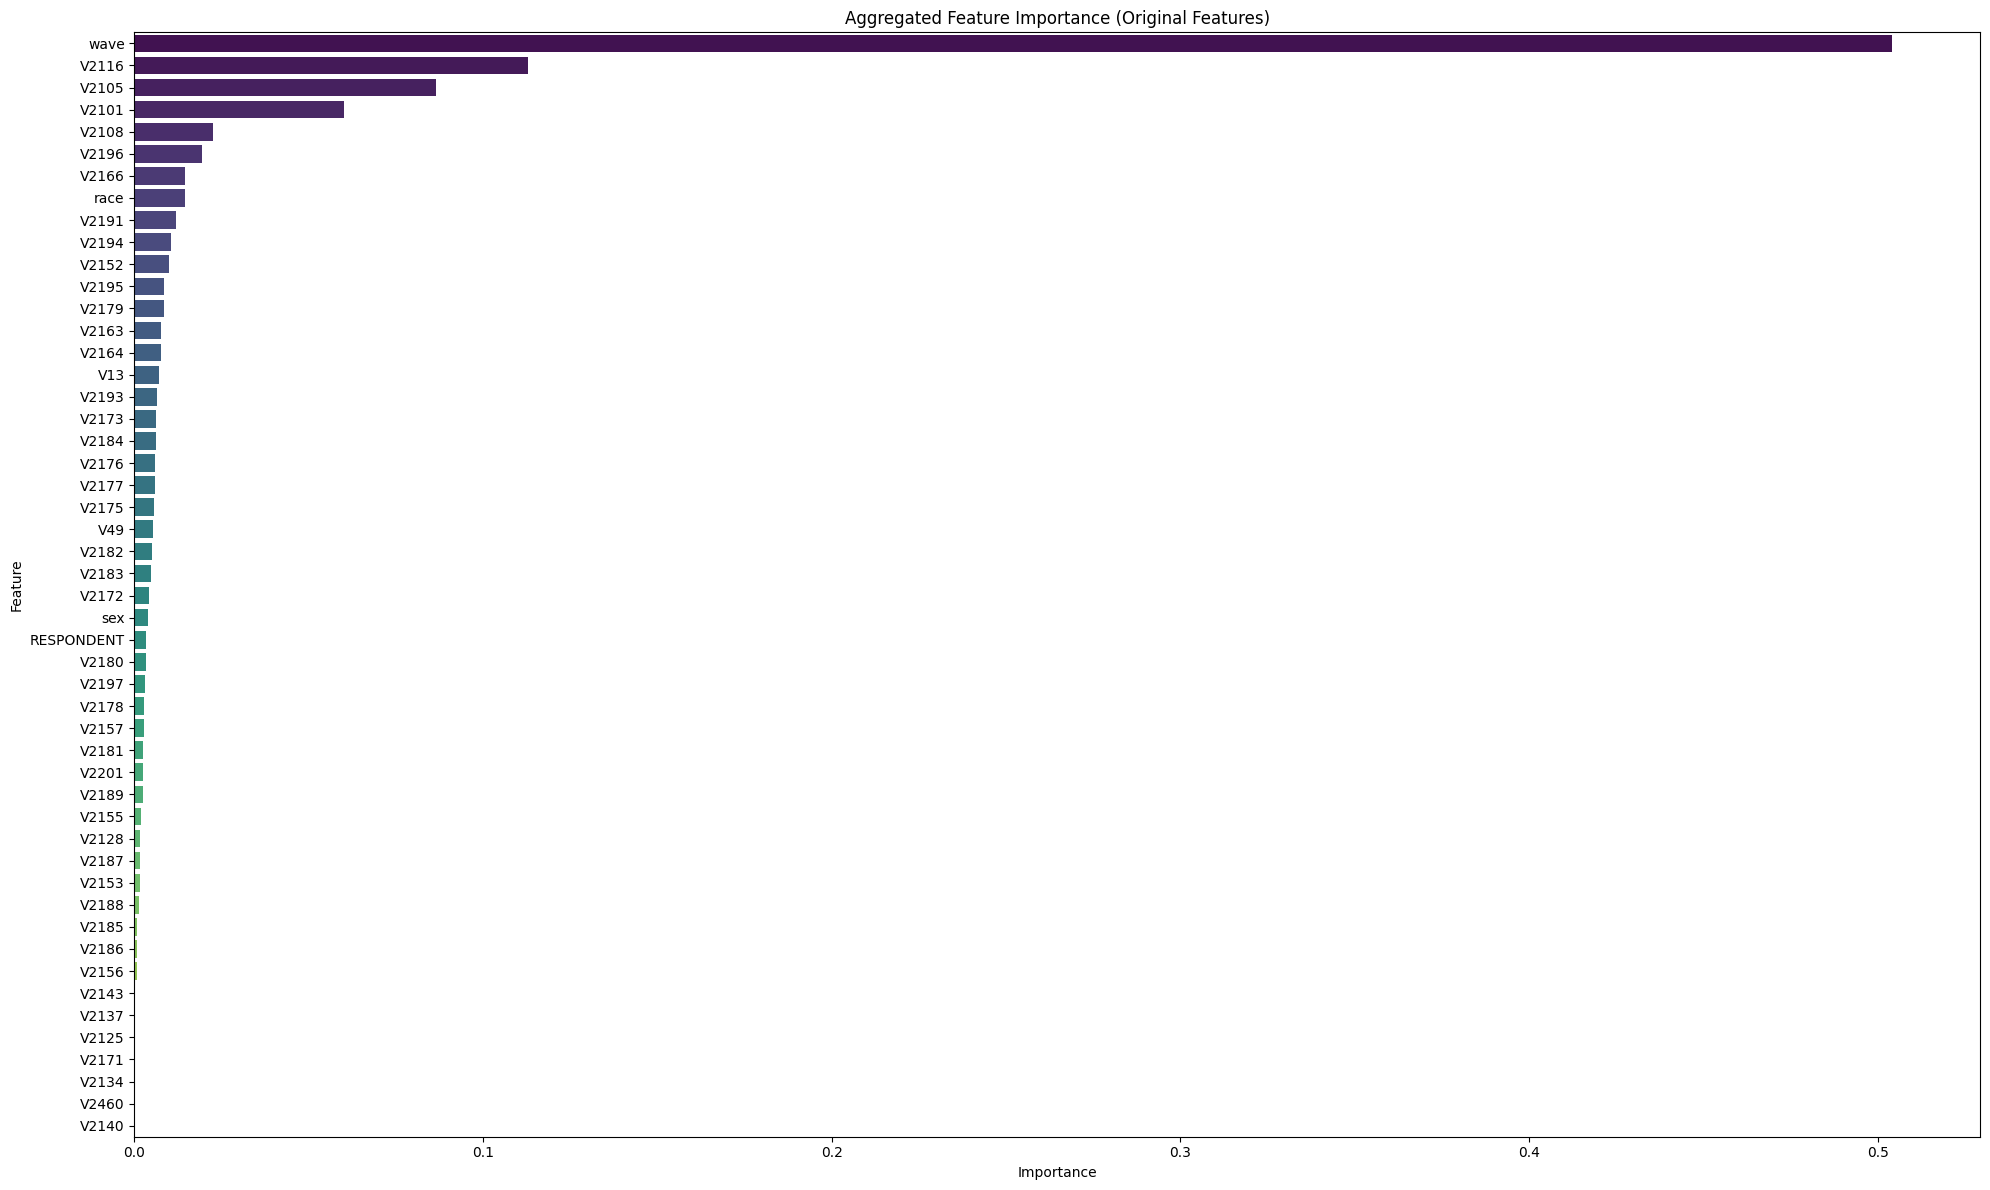

Top 20 Feature Importances:
   Feature  Importance
11    wave    0.504127
15   V2116    0.112886
42   V2105    0.086625
27   V2101    0.060063
26   V2108    0.022534
33   V2196    0.019504
10   V2166    0.014651
19    race    0.014635
30   V2191    0.011908
9    V2194    0.010518
47   V2152    0.009940
31   V2195    0.008595
35   V2179    0.008535
24   V2163    0.007627
29   V2164    0.007486
36     V13    0.007007
23   V2193    0.006488
8    V2173    0.006179
3    V2184    0.006108
12   V2176    0.005942


In [62]:
try:
    logging.info("Starting feature importance analysis...")

    # Access the RandomForestClassifier from the pipeline
    rf_model = best_rf.named_steps['classifier']

    # Get feature importances
    feature_importance = rf_model.feature_importances_

    # Access the preprocessor step
    preprocessor = best_rf.named_steps['preprocessor']

    # Get transformed feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Fallback: Generate feature names if get_feature_names_out is not available
        X_train_transformed = preprocessor.transform(X_train_with_indicators)
        feature_names = [f"Feature_{idx}" for idx in range(X_train_transformed.shape[1])]

    # Debugging: Print shapes and lengths
    logging.info(f"Shape of X_train_with_indicators: {X_train_with_indicators.shape}")
    logging.info(f"Length of feature_importance: {len(feature_importance)}")
    logging.info(f"Number of feature names: {len(feature_names)}")
    logging.info(f"Feature names: {feature_names}")

    # Check if lengths match
    if len(feature_names) != len(feature_importance):
        raise ValueError(
            f"Mismatch in lengths: feature_names ({len(feature_names)}) != feature_importance ({len(feature_importance)})"
        )

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Aggregate importances for original features
    original_feature_importance = {}

    for feature, importance in zip(feature_names, feature_importance):
        # Extract the original feature name (e.g., 'cat__V13_2' -> 'V13')
        original_feature = feature.split('__')[1].split('_')[0]

        # Sum importances for each original feature
        if original_feature in original_feature_importance:
            original_feature_importance[original_feature] += importance
        else:
            original_feature_importance[original_feature] = importance

    # Create a DataFrame for aggregated importances
    aggregated_importance_df = pd.DataFrame({
        'Feature': list(original_feature_importance.keys()),
        'Importance': list(original_feature_importance.values())
    })

    # Sort features by importance
    aggregated_importance_df = aggregated_importance_df.sort_values(by='Importance', ascending=False)

    # Plot aggregated feature importance
    plt.figure(figsize=(20, 12))
    sns.barplot(x='Importance', y='Feature', data=aggregated_importance_df, palette='viridis')
    plt.title('Aggregated Feature Importance (Original Features)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # Display top 20 feature importances
    top_20_features = aggregated_importance_df.head(20)
    print("Top 20 Feature Importances:")
    print(top_20_features)

except Exception as e:
    logging.error(f"An error occurred during feature importance analysis: {e}")
    raise

In [19]:
# best_rf is the best estimator from your RandomizedSearchCV
tree_model = best_rf.named_steps['classifier']

# Transform the entire training set
X_train_processed_full = best_rf.named_steps['preprocessor'].transform(X_train_with_indicators)

# Convert to DataFrame for easier sampling & feature naming
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed_full, columns=feature_names)

# Randomly sample 5000 rows from the processed data
X_background = X_train_processed_df.sample(n=1000, random_state=42)

# Create the explainer on just the 5000 background points
explainer = shap.TreeExplainer(tree_model, data=X_background)

# If you also want to compute shap values for the same subset (typical):
shap_values = explainer.shap_values(X_background)
shap_values_class1 = shap_values[1]



100%|===================| 1998/2000 [03:10<00:00]        

In [11]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = col.replace('num__', '')  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

In [13]:
importance_df.head(20)

Feature  Importance
0     wave    0.208466
1    V2116    0.062684
2    V2105    0.040905
3    V2101    0.033193
4    V2196    0.010164
5     race    0.007988
6    V2166    0.007083
7    V2191    0.006171
8      sex    0.005748
9    V2108    0.005621
10   V2194    0.005428
11   V2195    0.004197
12   V2179    0.003996
13   V2152    0.003813
14   V2184    0.003181
15   V2176    0.003055
16     V13    0.003026
17   V2173    0.002902
18   V2164    0.002471
19   V2175    0.002409

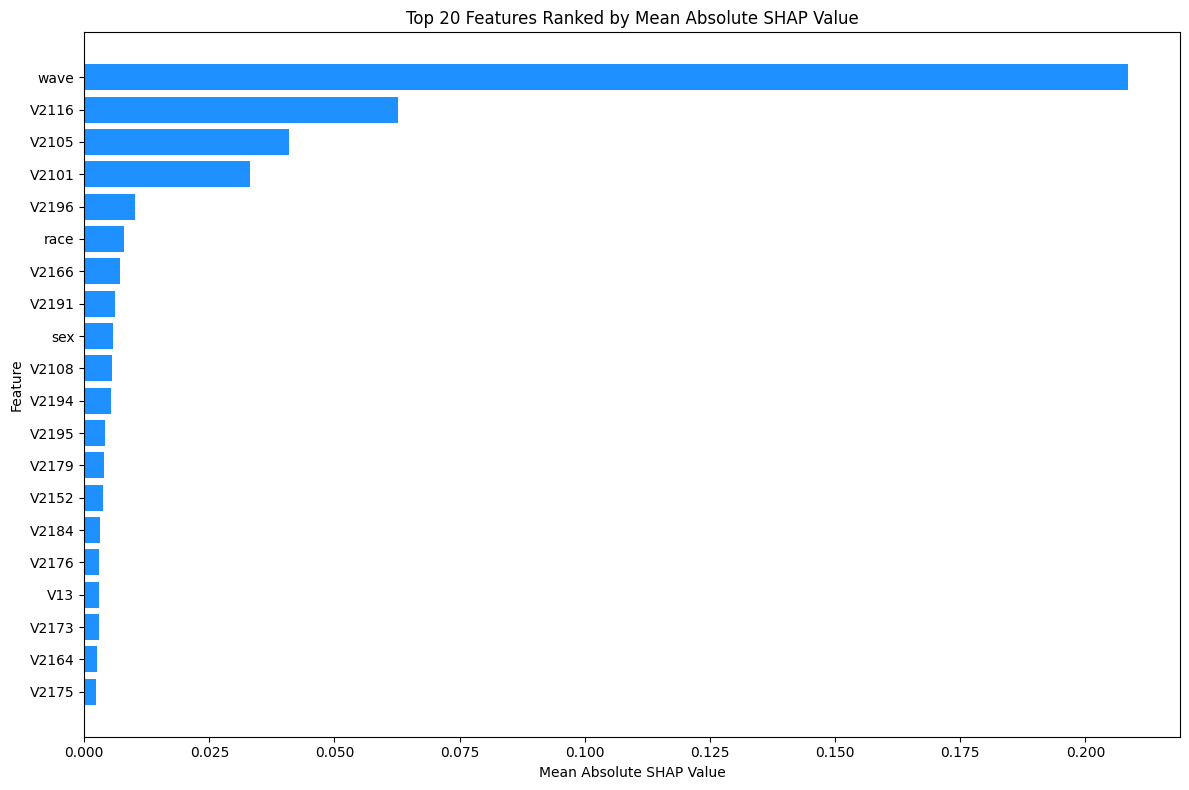

In [12]:
# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

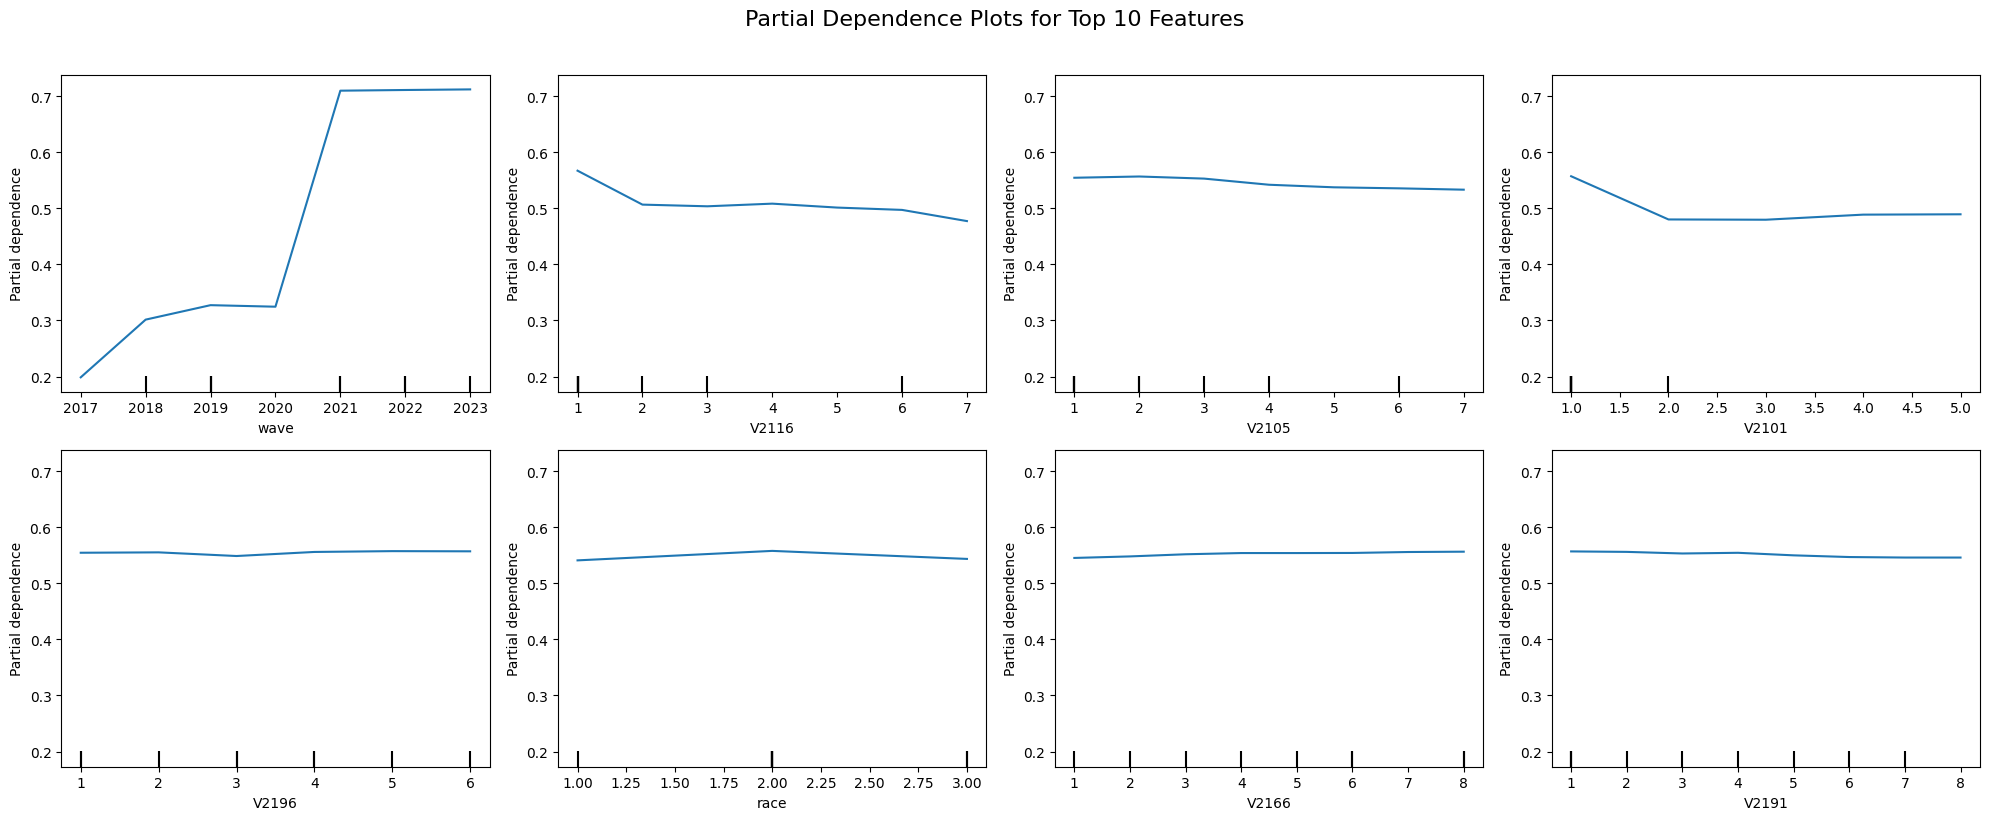

In [90]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

top_10_features = top_20_original_features.index[:8].tolist()

# Create a 2-row x 5-column grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axes array to pass it easily if needed
axs = axs.ravel()

pdp = PartialDependenceDisplay.from_estimator(
    best_rf,
    X_train_with_indicators,
    features=top_10_features,
    feature_names=X_train_with_indicators.columns,
    random_state=42,
    ax=axs  # pass axes array here
)

fig.suptitle("Partial Dependence Plots for Top 10 Features", fontsize=16, y=1.02)
plt.tight_layout()

## Gradient Boosting Trees

In [10]:
import logging
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # Repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Gradient Boosting (Revised) ---")

# Build pipeline
gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
gbc_param_dist = {
    'classifier__n_estimators': [100, 300, 500, 1000],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 10, 20],
    'classifier__subsample': [0.8, 0.9, 1.0],  # Controls sample ratio per tree
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 'log2', None]
}

try:
    logging.info("Starting randomized search for Gradient Boosting...")

    # Use RepeatedStratifiedKFold without shuffle
    cv_gbc = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )

    # RandomizedSearchCV to cover more combinations within reasonable compute time
    gbc_random_search = RandomizedSearchCV(
        estimator=gbc_pipeline,
        param_distributions=gbc_param_dist,
        n_iter=50,  # Increase or decrease based on resources
        cv=cv_gbc,
        scoring=SCORING_METRIC,
        n_jobs=24,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )

    # Fit the RandomizedSearchCV
    gbc_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (GBC): {gbc_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {gbc_random_search.best_score_:.4f}")

    # Extract the best estimator
    best_gbc = gbc_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting randomized search: {e}")
    raise

# Evaluate the best Gradient Boosting model
try:
    best_gbc.fit(X_train_with_indicators, y_train)
    y_pred_gbc = best_gbc.predict(X_test_with_indicators)
    y_pred_proba_gbc = best_gbc.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Gradient Boosting Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_gbc)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_gbc)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gbc):.4f}")

    # Plot ROC Curve
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_gbc, tpr_gbc, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_gbc):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

2025-02-19 15:45:39,885 - INFO - 
--- Gradient Boosting (Revised) ---
2025-02-19 15:45:39,886 - INFO - Starting randomized search for Gradient Boosting...


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [33]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')

# Save the trained model
joblib.dump(best_gbc, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-14 14:49:47,488 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_gbt_model.joblib


In [11]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')
loaded_gbt = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


In [15]:
# Access the pipeline for categorical features
num_pipeline = loaded_gbt.named_steps['preprocessor'].named_transformers_['num']
# Then access the OneHotEncoder within that pipeline
ohe = num_pipeline.named_steps['scaler']
# Now get the encoded feature names
encoded_feature_names = ohe.get_feature_names_out(numeric_features)
encoded_feature_names

NameError: name 'numeric_features' is not defined

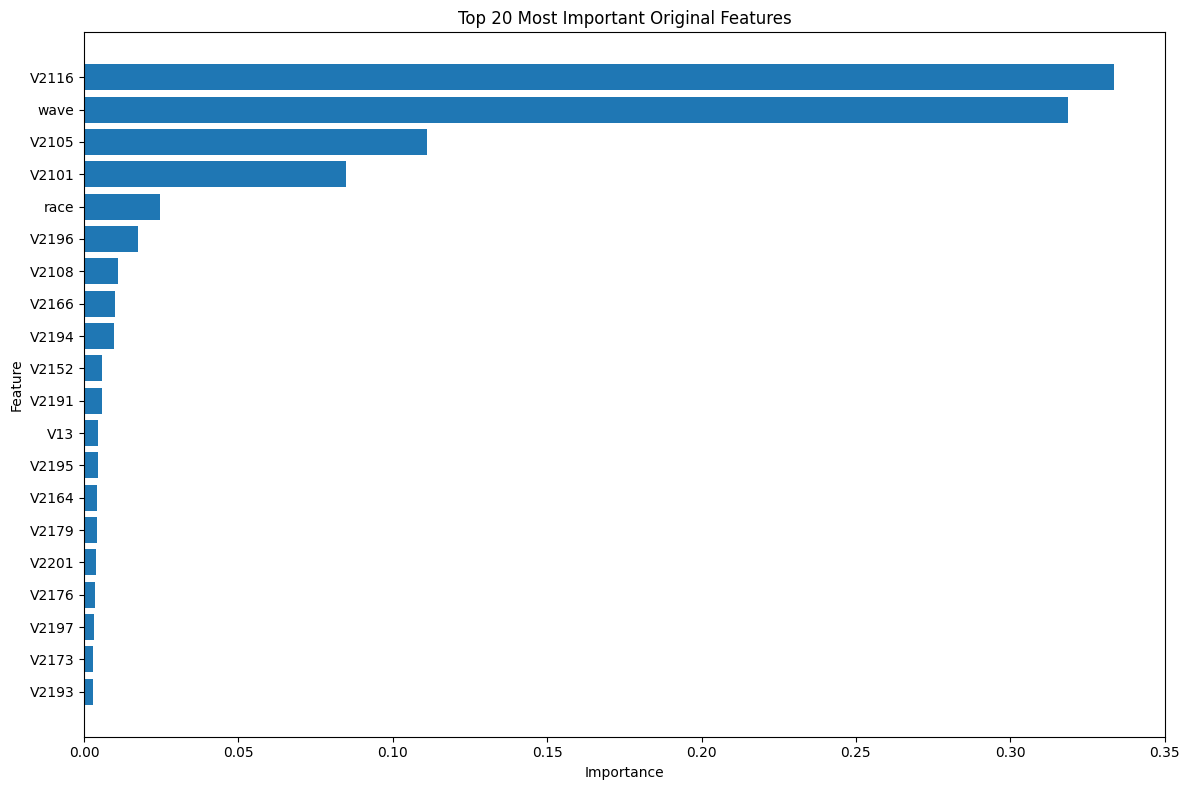


Feature Importance Rankings:
           Feature  Importance
15           V2116    0.333590
11            wave    0.318799
42           V2105    0.111097
27           V2101    0.084814
19            race    0.024483
33           V2196    0.017528
26           V2108    0.011029
10           V2166    0.010013
9            V2194    0.009626
47           V2152    0.005866
30           V2191    0.005776
36             V13    0.004605
31           V2195    0.004590
29           V2164    0.004188
35           V2179    0.004186
7            V2201    0.003781
12           V2176    0.003388
2            V2197    0.003107
8            V2173    0.003022
23           V2193    0.002970
24           V2163    0.002806
18             sex    0.002401
13           V2175    0.002381
3            V2184    0.002251
0            V2178    0.002250
6            V2128    0.002124
14           V2177    0.002117
17           V2182    0.001385
46           V2181    0.001374
39           V2172    0.001293
28       

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Get the numerical pipeline
num_pipeline = loaded_gbt.named_steps['preprocessor'].named_transformers_['num']

# 2. Get the scaler (StandardScaler or whatever you named it)
scaler = num_pipeline.named_steps['scaler']

# 3. Get the feature names out (they will match one-to-one with your numeric_features)
encoded_feature_names = scaler.get_feature_names_out(numeric_features)

# 4. Get the trained classifier and its feature importances
gbt_classifier = loaded_gbt.named_steps['classifier']
importances = gbt_classifier.feature_importances_

# 5. Build a DataFrame of features vs. importances
feature_importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': importances
})

# 6. Sort by ascending order of importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# 7. Take top 20 features and plot
top_20 = feature_importance_df.tail(20)

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 8. Print the DataFrame in descending order for readability
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))


Top 10 original features: ['V2116', 'wave', 'V2105', 'V2101', 'race', 'V2196', 'V2108', 'V2166', 'V2194', 'V2152', 'V2191', 'V13', 'V2195']
Filtered features (excluding 'missing_'):  ['V2116', 'wave', 'V2105', 'V2101', 'race', 'V2196', 'V2108', 'V2166', 'V2194', 'V2152', 'V2191', 'V13', 'V2195']


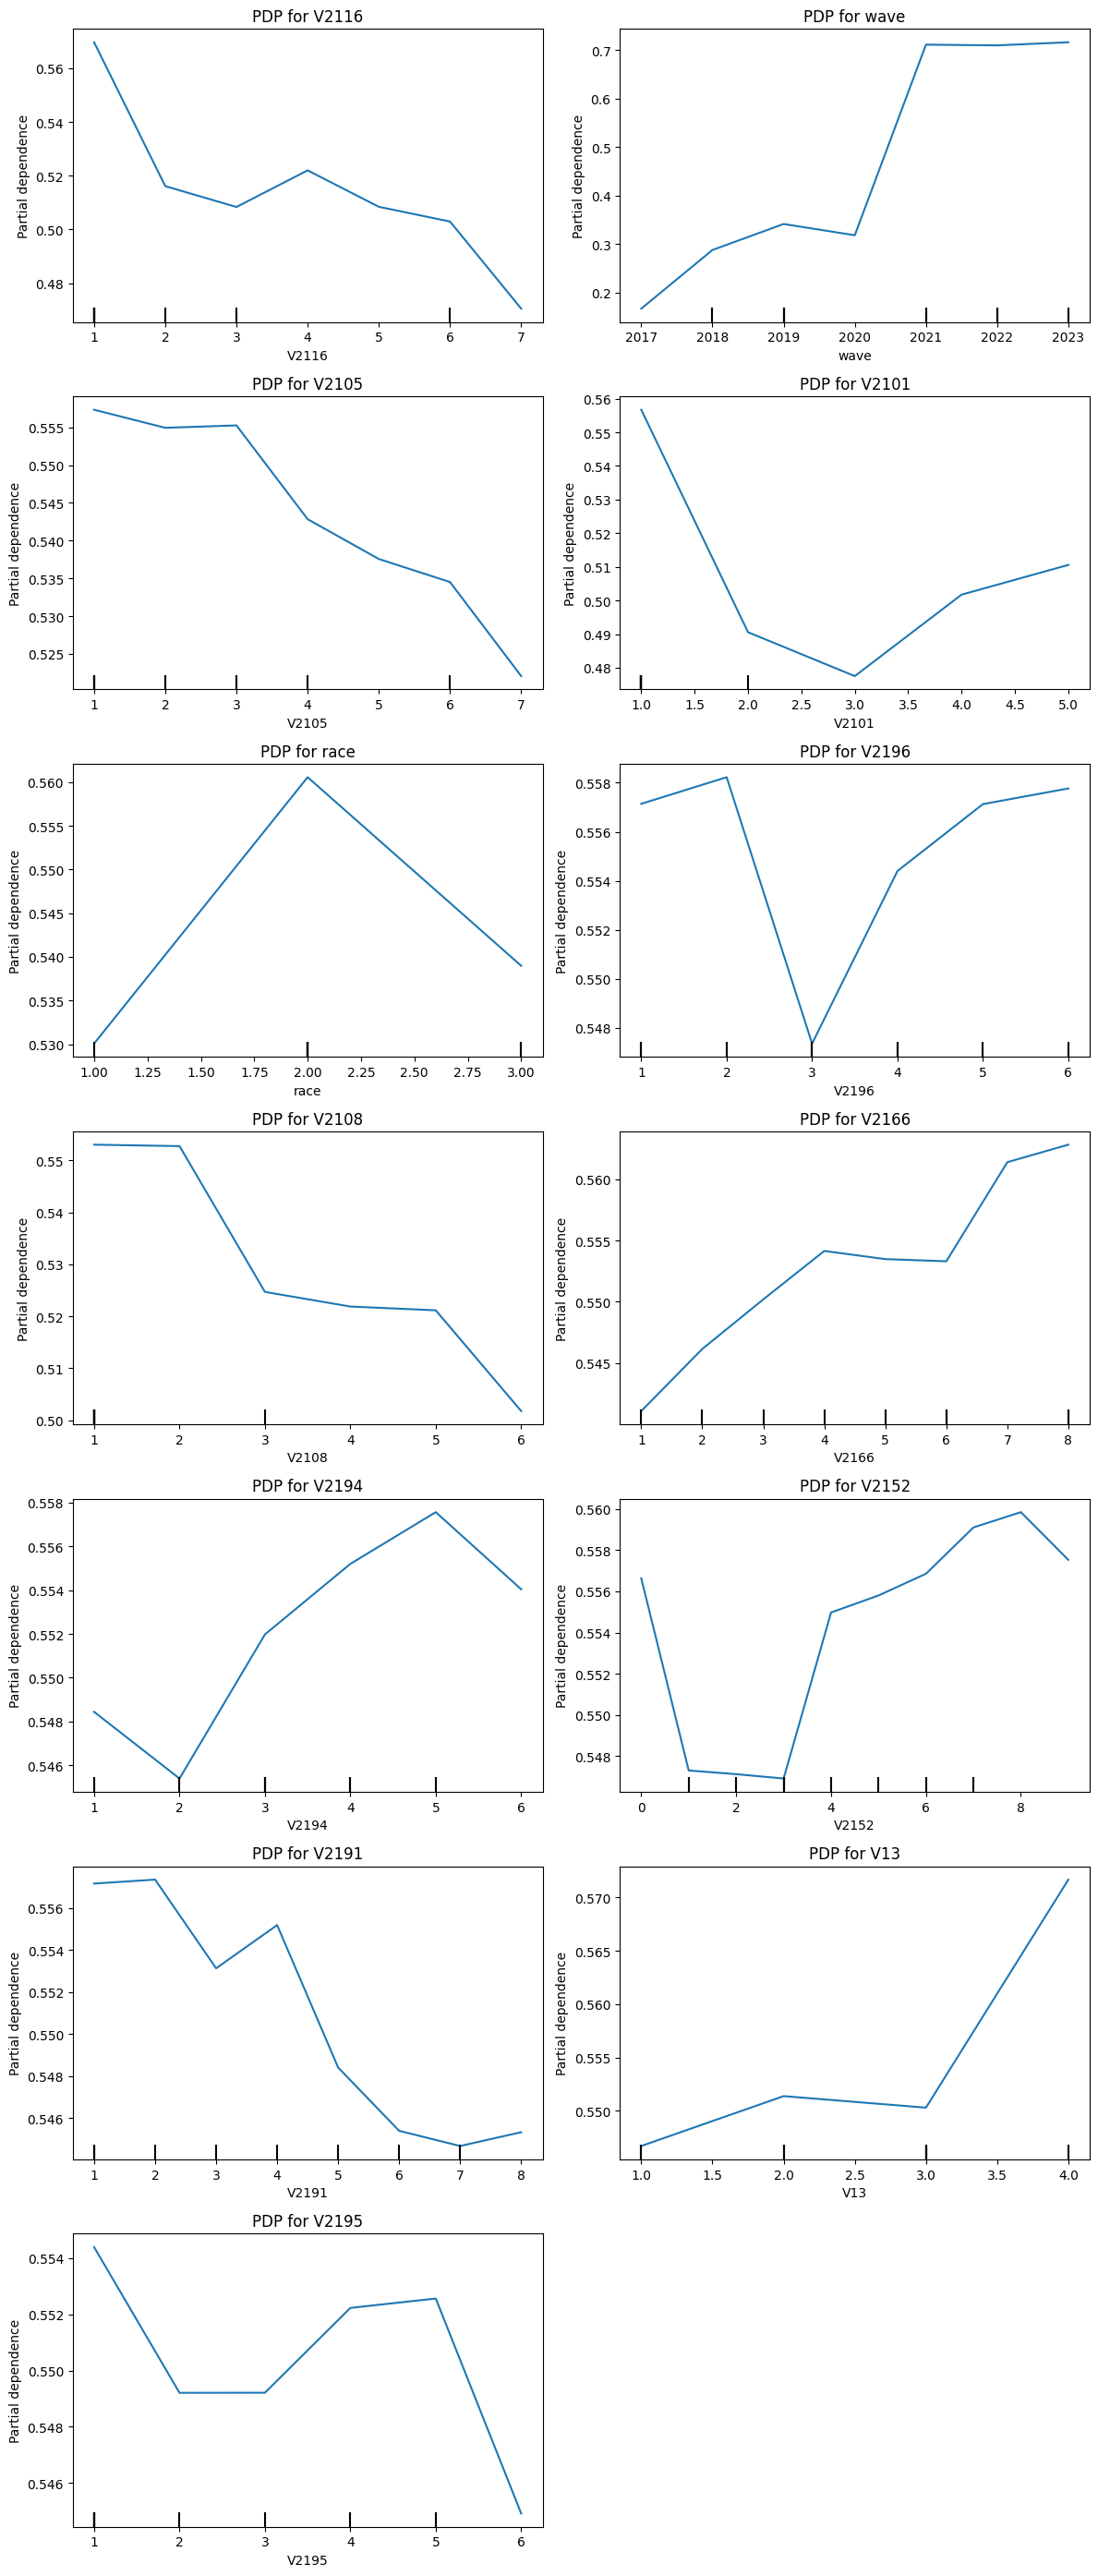

In [53]:
# 1) Sort by descending importance and take top 10.
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = feature_importance_df['Feature'].head(13).tolist()

# 2) Exclude features that start with "missing_" 
#    or that don’t actually exist in X_train_with_indicators.
filtered_features = [
    f for f in top_10_features 
    if not f.startswith('missing_') and f in X_train_with_indicators.columns
]

print("Top 10 original features:", top_10_features)
print("Filtered features (excluding 'missing_'): ", filtered_features)

# 3) Plot PDPs for the filtered features
n_features = len(filtered_features)
n_rows = (n_features + 1) // 2  # so we can arrange them in a grid
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4*n_rows), squeeze=False)
axes = axes.flatten()

for i, feat in enumerate(filtered_features):
    ax = axes[i]
    PartialDependenceDisplay.from_estimator(
        estimator=loaded_gbt,
        X=X_train_with_indicators,
        features=[feat],
        feature_names=X_train_with_indicators.columns,
        kind='average',  # or 'both' if you want ICE lines
        ax=ax
    )
    ax.set_title(f"PDP for {feat}")

# If there are unused subplots, hide them
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
X_train_transformed = preprocessor.transform(X_train_with_indicators)
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Dtypes (if it is a NumPy array):", X_train_transformed.dtype)

# If X_train_transformed is a Pandas DataFrame:
if hasattr(X_train_transformed, 'dtypes'):
    print(X_train_transformed.dtypes)

X_train_with_indicators.info()  # or X_train_with_indicators.isna().sum() if DataFrame


Shape of X_train_transformed: (26184, 305)
Dtypes (if it is a NumPy array): float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26184 entries, 0 to 26183
Data columns (total 100 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   V2178                   25473 non-null  float64
 1   V2188                   25162 non-null  float64
 2   V2197                   24821 non-null  float64
 3   V2184                   24562 non-null  float64
 4   V2186                   25162 non-null  float64
 5   V2171                   25690 non-null  float64
 6   V2128                   25948 non-null  float64
 7   V2201                   24792 non-null  float64
 8   V2173                   25486 non-null  float64
 9   V2194                   25142 non-null  float64
 10  V2166                   25505 non-null  float64
 11  wave                    26184 non-null  int64  
 12  V2176                   24467 non-null  float64
 13  V2175 

In [12]:
##### SHAP Feature Importance ####

# Extract the GradientBoostingClassifier
gbt_models = loaded_gbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_gbt.named_steps['preprocessor'].transform(X_test_with_indicators)
# Create SHAP explainer
explainer = shap.TreeExplainer(gbt_models)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed)
# Get feature names after preprocessing
feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()

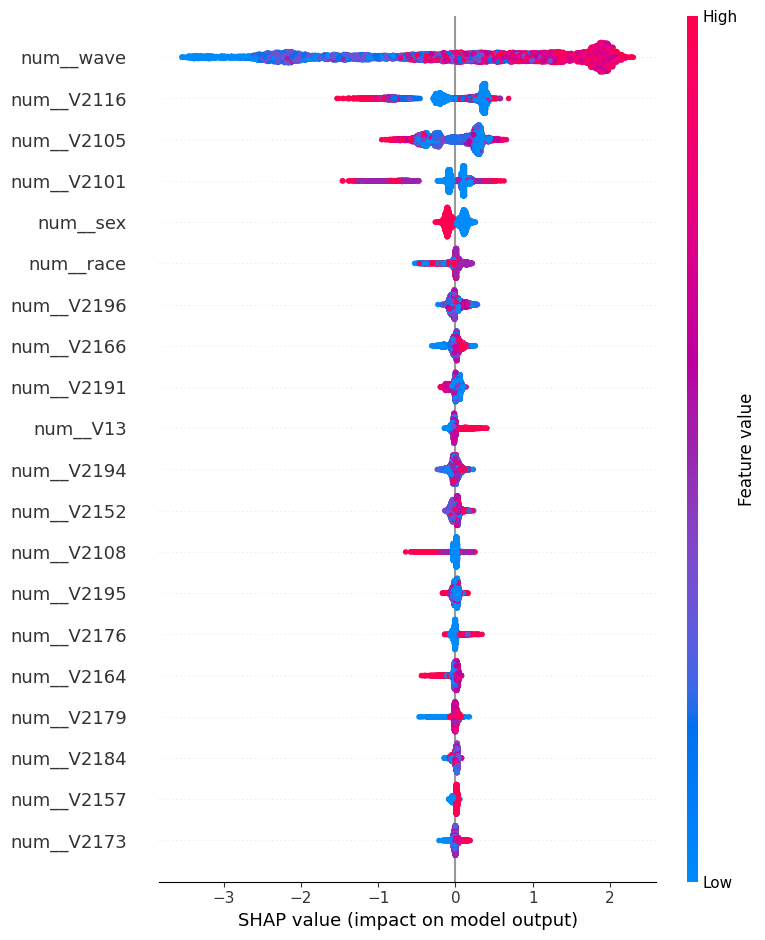

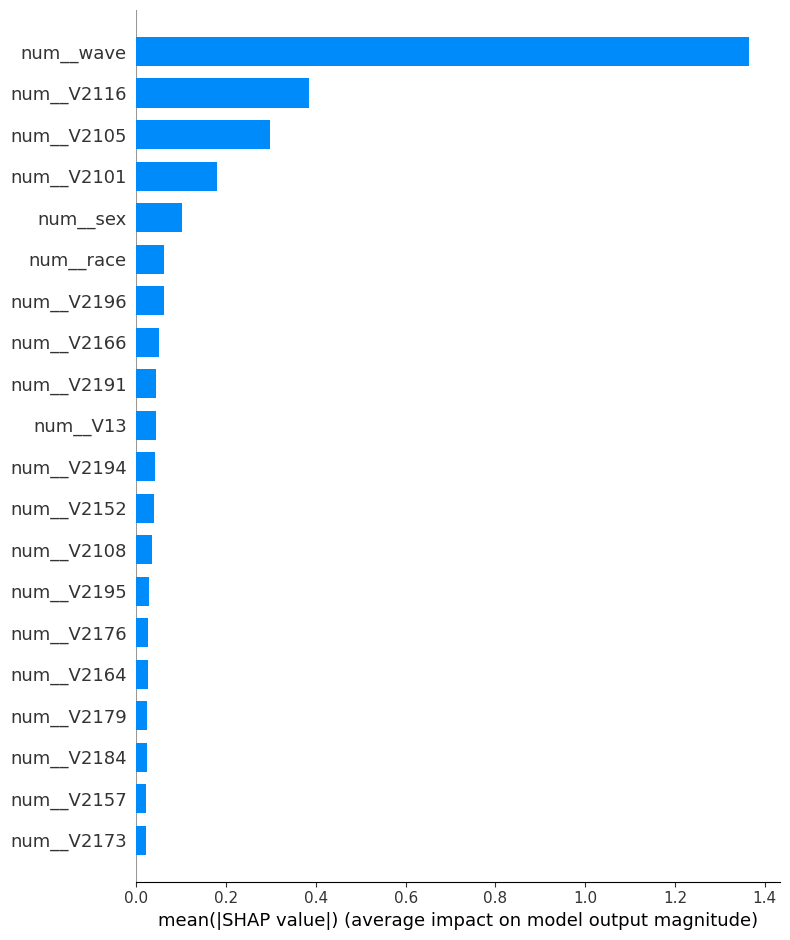

In [18]:
# Create visualizations
# Summary plot
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)
# Bar plot of feature importance
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, plot_type='bar')

In [19]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = col.replace('num__', '')  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

In [20]:
importance_df.head(20)

Feature  Importance
0     wave    1.365843
1    V2116    0.385418
2    V2105    0.298170
3    V2101    0.180036
4      sex    0.101346
5     race    0.060658
6    V2196    0.060315
7    V2166    0.049448
8    V2191    0.044052
9      V13    0.043536
10   V2194    0.040241
11   V2152    0.038175
12   V2108    0.034302
13   V2195    0.028043
14   V2176    0.026151
15   V2164    0.024821
16   V2179    0.023784
17   V2184    0.023351
18   V2157    0.021714
19   V2173    0.021299

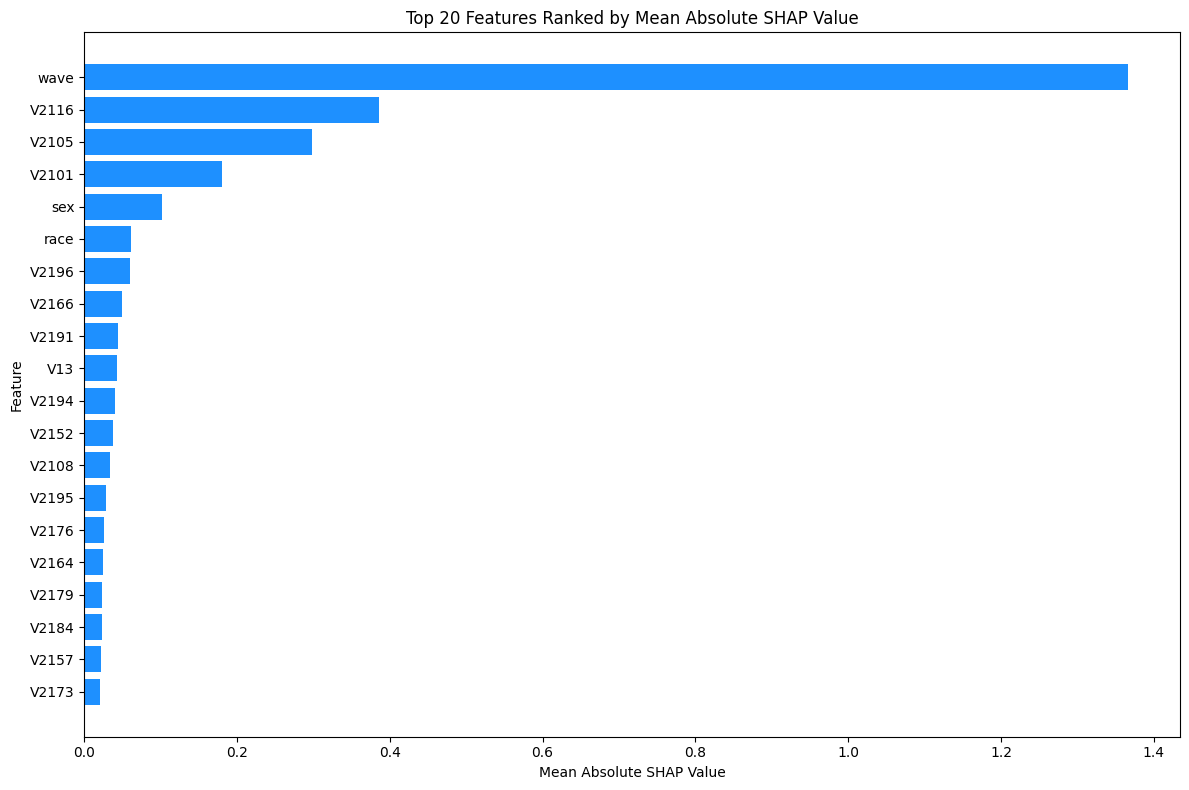

In [66]:
# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

In [68]:
# For individual predictions (e.g., first sample)
shap.initjs()  # Initialize JavaScript visualization
single_sample_idx = 0
shap.force_plot(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx,:],
                X_preprocessed[single_sample_idx],
                feature_names=feature_names)

In [72]:
###### Demonstration of SHAP feature importance for one individual case ###########

# For individual predictions (e.g., first sample)
single_sample_idx = 0
single_sample_shap_values = shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx, :]

# Aggregate SHAP values by base feature for the single sample
feature_importances = {}
for i, feature_name in enumerate(feature_names):
    base_feature = col.replace('num__', '')
  # Extract base feature name
    shap_value = single_sample_shap_values[i]
    feature_importances[base_feature] = feature_importances.get(base_feature, 0) + abs(shap_value)

# Sort features by importance
sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

# Print the ranked feature importance for the single prediction
print(f"Overall Feature Importance for Sample {single_sample_idx}:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Overall Feature Importance for Sample 0:
V2156: 3.5576


In [73]:
# SHAP feature interaction

# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)

In [15]:
#  We'll sample 100 rows (or choose your own size)
SAMPLE_SIZE = 5000
if X_preprocessed.shape[0] > SAMPLE_SIZE:
    idx = np.random.choice(X_preprocessed.shape[0], size=SAMPLE_SIZE, replace=False)
    X_preprocessed_subset = X_preprocessed[idx, :]
else:
    X_preprocessed_subset = X_preprocessed

# Now compute SHAP interaction on the subset
shap_interaction_values = explainer.shap_interaction_values(X_preprocessed_subset)

   Feature1 Feature2  InteractionValue  AbsInteraction
0      wave    V2116          0.381856        0.381856
1      wave    V2105          0.305814        0.305814
2      wave    V2101          0.181126        0.181126
3      wave    V2196          0.057863        0.057863
4      wave     race          0.055804        0.055804
5     V2116    V2105          0.049386        0.049386
6     V2194     wave          0.040912        0.040912
7      wave    V2108          0.035271        0.035271
8     V2166     wave          0.033239        0.033239
9     V2116    V2101          0.033163        0.033163
10     wave    V2191          0.028146        0.028146
11     wave      sex          0.022875        0.022875
12     wave    V2195          0.022266        0.022266
13     wave    V2176          0.020286        0.020286
14    V2116     race          0.017869        0.017869
15    V2101    V2105          0.017857        0.017857
16    V2201     wave          0.017011        0.017011
17    V219

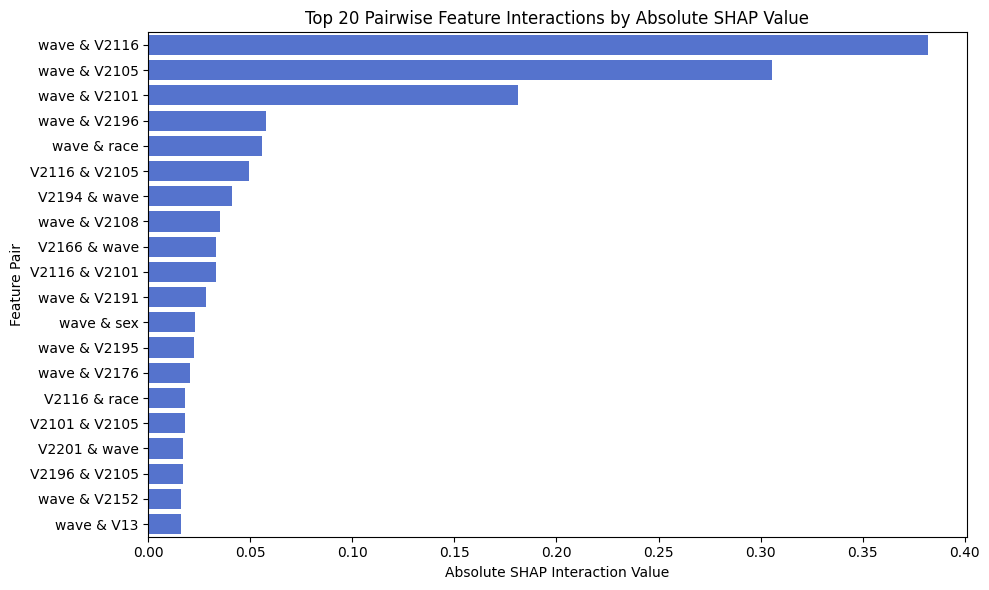

In [75]:
import numpy as np
import pandas as pd

def aggregate_shap_interactions(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features.
    
    Parameters
    ----------
    shap_interaction_values : np.ndarray
        SHAP interaction values of shape [n_samples, n_features, n_features].
    feature_names : list of str
        The one-hot-encoded feature names corresponding to shap_interaction_values.
    get_base_feature : callable
        A function that takes a one-hot-encoded feature name and returns the base/original feature name.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with ["Feature1", "Feature2", "InteractionValue", "AbsInteraction"] 
        sorted in descending order of AbsInteraction.
    """
    # 1. Aggregate across samples (e.g., mean absolute interactions)
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)
    
    # 2. Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(n) for n in feature_names]
    unique_base_features = list(set(base_feature_names))
    
    # 3. Build a structure to accumulate aggregated pairwise interactions
    aggregated_interactions = {
        bf_i: {bf_j: 0.0 for bf_j in unique_base_features}
        for bf_i in unique_base_features
    }

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i+1, n_features): # i+1 => no diagonal, no duplicates
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated_interactions[bf_i][bf_j] += interaction_matrix[i, j]
    
    # 4. Convert to DataFrame
    data_records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # If you want to keep only i <= j, add a condition to avoid duplicates
            interaction_val = aggregated_interactions[bf_i][bf_j]
            data_records.append((bf_i, bf_j, interaction_val))
    
    df_interactions = pd.DataFrame(data_records, columns=["Feature1", "Feature2", "InteractionValue"])
    df_interactions["AbsInteraction"] = df_interactions["InteractionValue"].abs()
    
    # Sort descending by absolute interaction
    df_interactions.sort_values("AbsInteraction", ascending=False, inplace=True)
    df_interactions.reset_index(drop=True, inplace=True)
    df_interactions_no_diagonal = df_interactions[df_interactions['Feature1'] != df_interactions['Feature2']]
    return df_interactions_no_diagonal


# Example usage:
def simple_get_base_feature(name):
    # If it has the "num__" prefix, strip it off
    if name.startswith("num__"):
        name = name[len("num__"):]  # "V2178"
    # If it has the "cat__" prefix, strip that as well
    if name.startswith("cat__"):
        name = name[len("cat__"):] 
    # Now 'name' might look like "V2178"
    # Just return it as the base feature
    return name

df_agg_interactions = aggregate_shap_interactions(
    shap_interaction_values=shap_interaction_values,
    feature_names=feature_names,
    get_base_feature=simple_get_base_feature
)

# Print the top 20 interactions
print(df_agg_interactions.head(20))

# --- Pick Top 20 Interactions ---
df_top_20 = df_agg_interactions.head(20).copy()

# Create a convenient label for each pair
df_top_20["Pair"] = df_top_20["Feature1"] + " & " + df_top_20["Feature2"]

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_20, 
    y="Pair", 
    x="AbsInteraction", 
    color="royalblue"
)
plt.title("Top 20 Pairwise Feature Interactions by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Pair")
plt.tight_layout()
plt.show()

In [76]:
# Interaction of the top 2 features
top_features_indices = np.argsort(np.abs(shap_values).mean(0))[-2:]  # Get indices of top 2 features
feature1_idx = top_features_indices[0]
feature2_idx = top_features_indices[1]
feature1_name = feature_names[feature1_idx]
feature2_name = feature_names[feature2_idx]

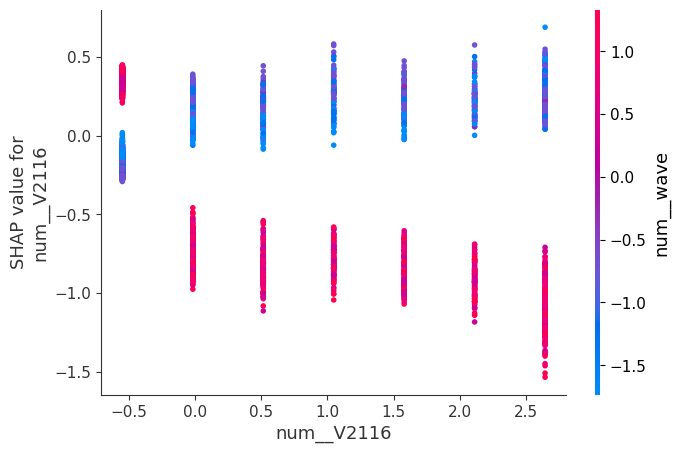

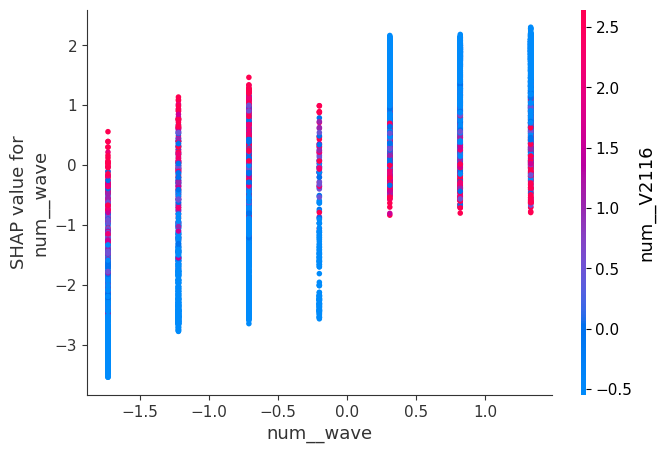

In [88]:
# Visualize the interaction between the top two features
shap.dependence_plot(
    feature1_idx,
    shap_values,
    X_preprocessed,
    feature_names=feature_names,
    interaction_index=feature2_idx,
)

shap.dependence_plot(
    feature2_idx,
    shap_values,
    X_preprocessed,
    feature_names=feature_names,
    interaction_index=feature1_idx,
)

In [89]:
# 1. Group feature indices by base feature (removing "num__" prefix).
base_feature_indices = {}
for i, feature_name in enumerate(feature_names):
    # Remove "num__" so each feature remains distinct
    base_feature = feature_name.replace("num__", "")
    if base_feature not in base_feature_indices:
        base_feature_indices[base_feature] = []
    base_feature_indices[base_feature].append(i)

base_feature_list = list(base_feature_indices.keys())

# 2. Calculate overall interaction importance for each pair of base features
#    without duplicating reversed pairs (bf1,bf2) vs (bf2,bf1).
base_feature_interaction_importance = {}

for bf1_idx in range(len(base_feature_list)):
    for bf2_idx in range(bf1_idx + 1, len(base_feature_list)):
        bf1 = base_feature_list[bf1_idx]
        bf2 = base_feature_list[bf2_idx]

        # Sum up the pairwise interactions between *all* sub-indices of bf1 and bf2.
        interaction_sum = 0.0
        for i in base_feature_indices[bf1]:
            for j in base_feature_indices[bf2]:
                if isinstance(shap_interaction_values, list):
                    # e.g., for multiclass or ensemble, focusing on shap_interaction_values[0]
                    interaction_sum += shap_interaction_values[0][0, i, j]
                    # If you want both i->j and j->i, add shap_interaction_values[0][0, j, i]
                    # but usually shap_interaction_values[i,j] == shap_interaction_values[j,i].
                else:
                    interaction_sum += shap_interaction_values[0, i, j]
                    # Same note here if you want both directions.

        # Use absolute value as "importance"
        pair_key = (bf1, bf2)  # We already enforce bf1_idx < bf2_idx
        base_feature_interaction_importance[pair_key] = abs(interaction_sum)

# 3. Sort base feature interactions by importance
sorted_base_feature_interactions = sorted(
    base_feature_interaction_importance.items(),
    key=lambda item: item[1],
    reverse=True
)

# 4. Print the top 50 ranked base feature interactions (no (bf, bf), no reversed duplicates)
print("Top 50 Overall Base Feature Interaction Importance (Skipping self-interactions & duplicates):")
for (bf1, bf2), importance in sorted_base_feature_interactions[:50]:
    print(f"Interaction between {bf1} and {bf2}: {importance:.4f}")


Top 50 Overall Base Feature Interaction Importance (Skipping self-interactions & duplicates):
Interaction between wave and V2105: 0.4028
Interaction between wave and V2116: 0.3704
Interaction between wave and V2101: 0.1144
Interaction between V2201 and wave: 0.1128
Interaction between V2166 and wave: 0.0705
Interaction between wave and V2196: 0.0540
Interaction between wave and race: 0.0299
Interaction between V2184 and wave: 0.0246
Interaction between V2116 and race: 0.0215
Interaction between wave and V2195: 0.0202
Interaction between wave and sex: 0.0202
Interaction between wave and V2176: 0.0186
Interaction between V2194 and wave: 0.0180
Interaction between wave and V2108: 0.0171
Interaction between wave and V2191: 0.0163
Interaction between V2166 and V2116: 0.0128
Interaction between race and V2105: 0.0127
Interaction between V2184 and V2175: 0.0121
Interaction between V2175 and sex: 0.0117
Interaction between wave and V2152: 0.0094
Interaction between V2116 and V2105: 0.0090
Inte

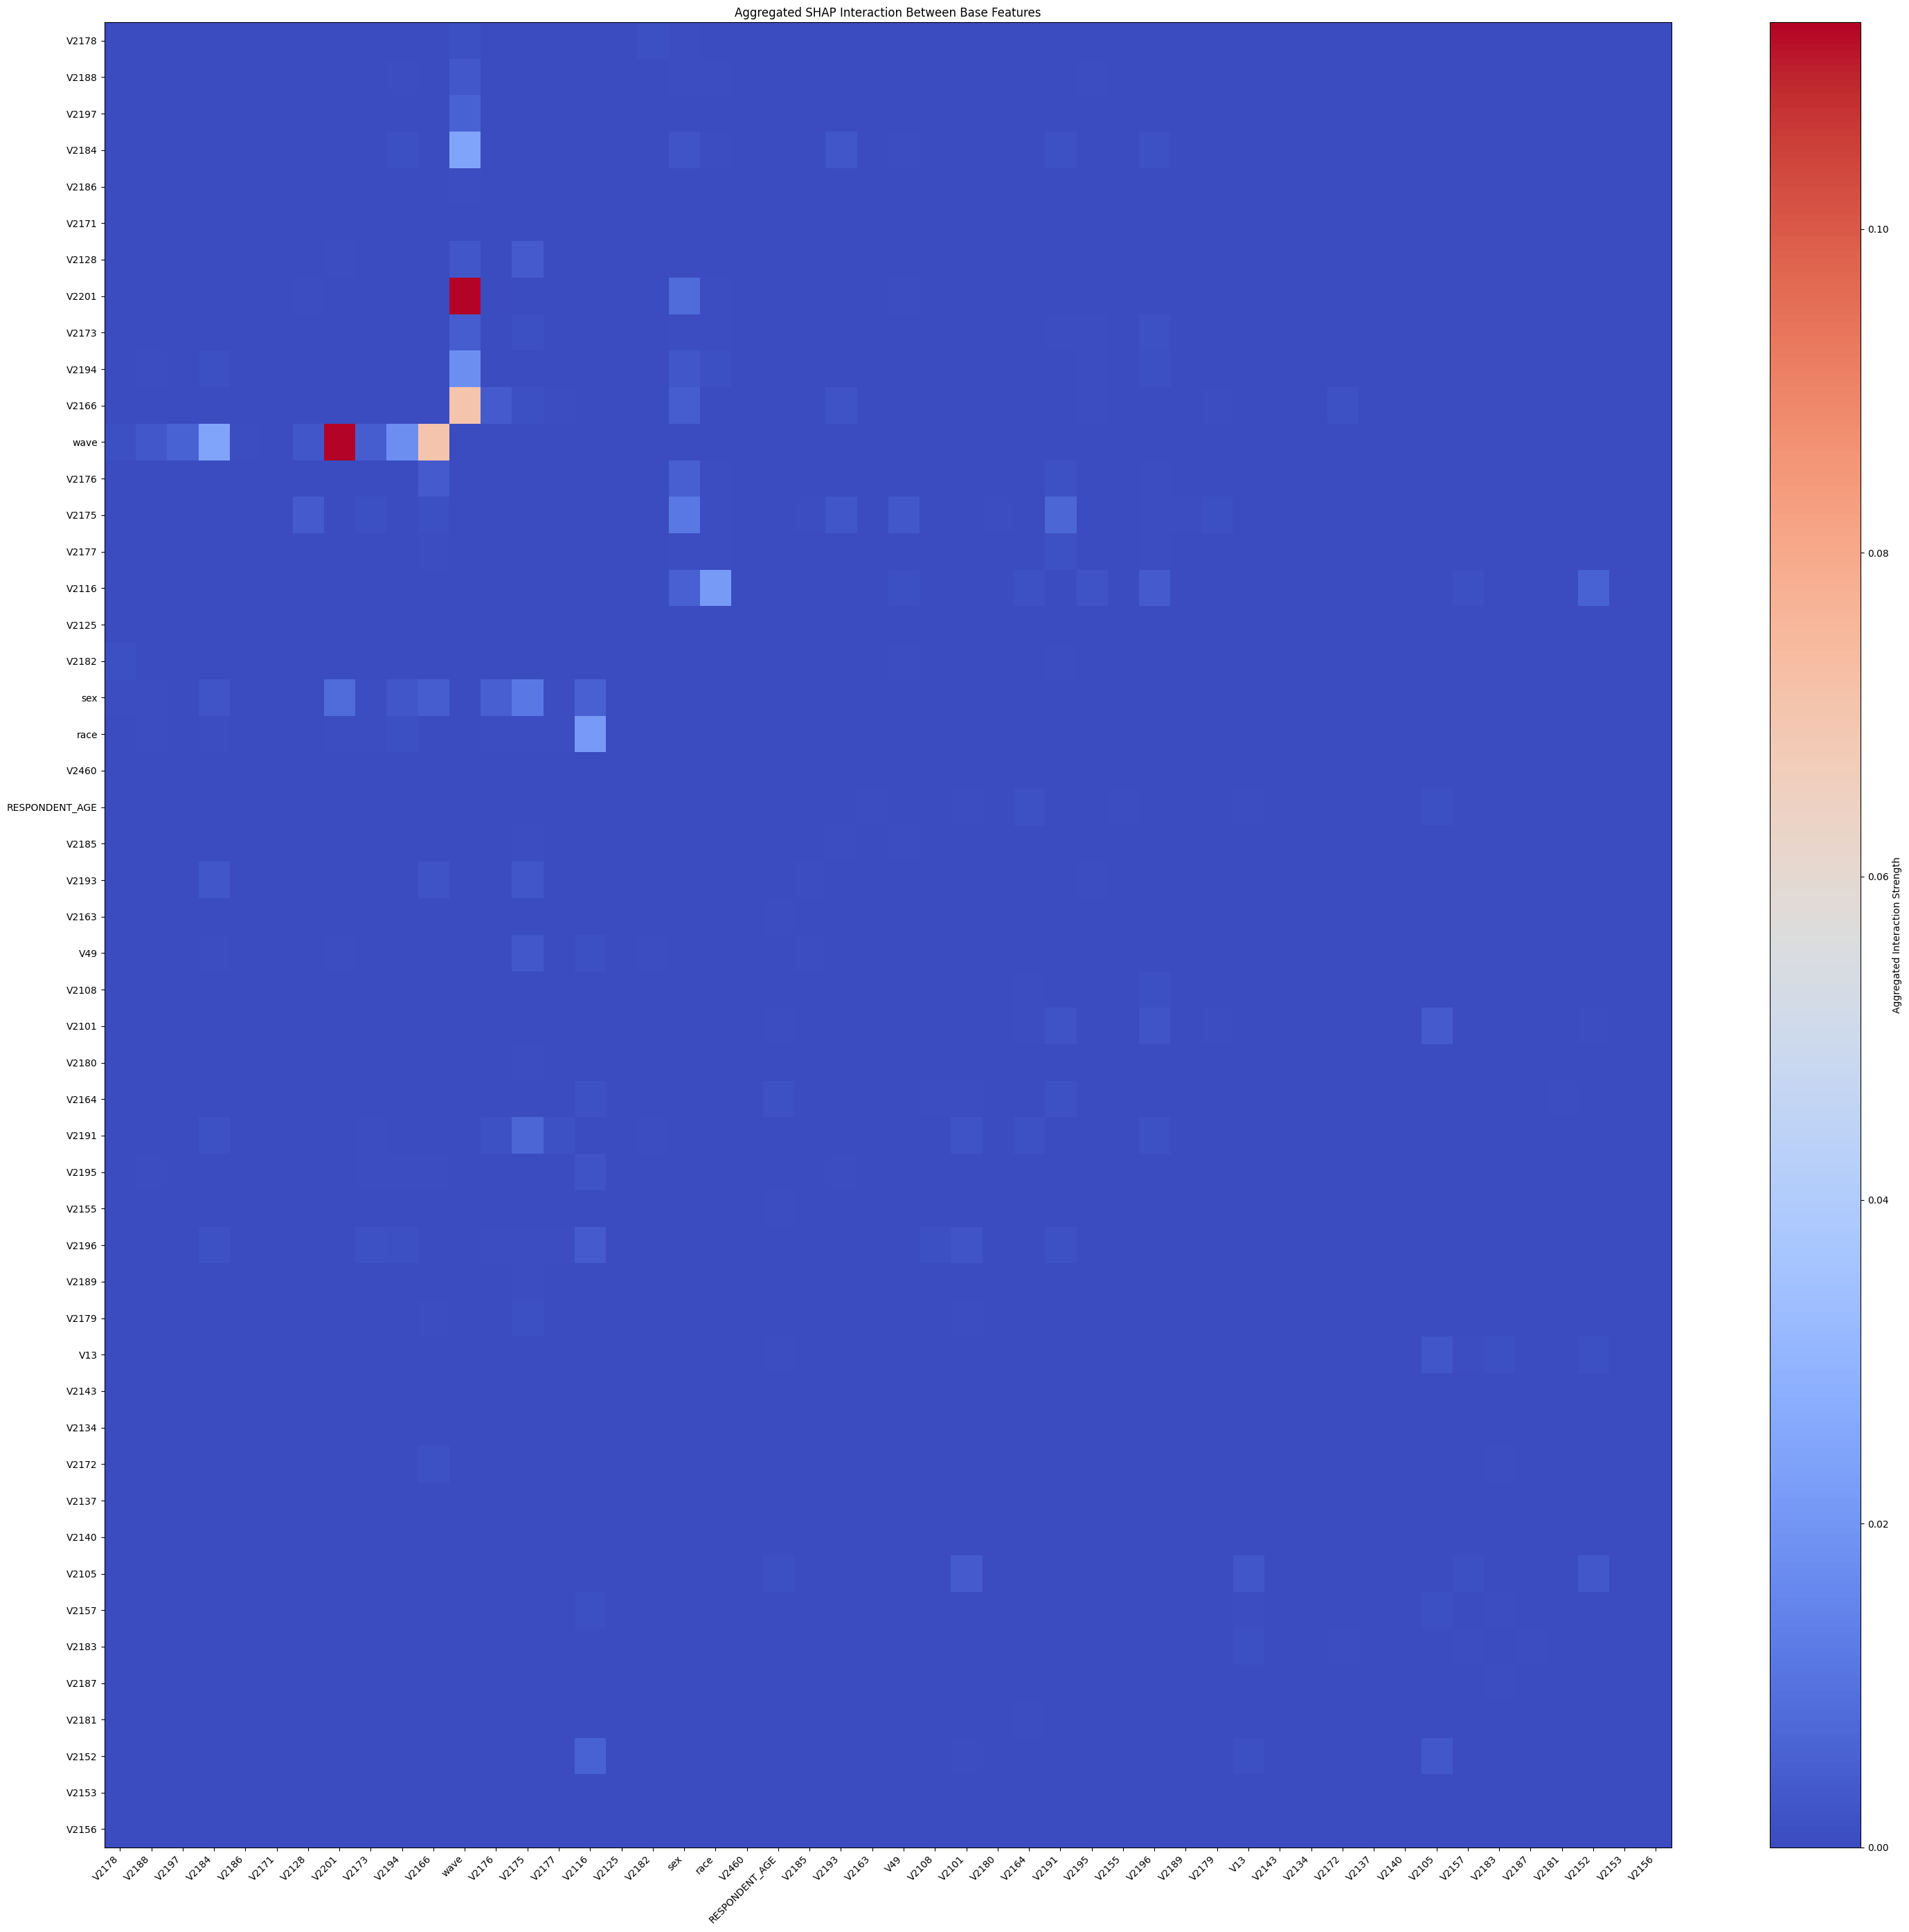

In [90]:
# 3. Create a matrix for the heatmap
num_base_features = len(base_feature_names)
interaction_matrix = np.zeros((num_base_features, num_base_features))

for i, bf1 in enumerate(base_feature_names):
    for j, bf2 in enumerate(base_feature_names):
        # Use the sorted tuple for lookup
        key = tuple(sorted((bf1, bf2)))
        if key in base_feature_interaction_importance:
            interaction_matrix[i, j] = base_feature_interaction_importance[key]
        #else:
        #    print(f"Warning: Interaction not found for {bf1}, {bf2}") # Optional debugging

# 4. Visualize the aggregated interaction using a heatmap
plt.figure(figsize=(30, 28))
plt.imshow(interaction_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Aggregated Interaction Strength')
plt.xticks(range(num_base_features), base_feature_names, rotation=45, ha="right")
plt.yticks(range(num_base_features), base_feature_names)
plt.title('Aggregated SHAP Interaction Between Base Features')
plt.tight_layout()
plt.show()

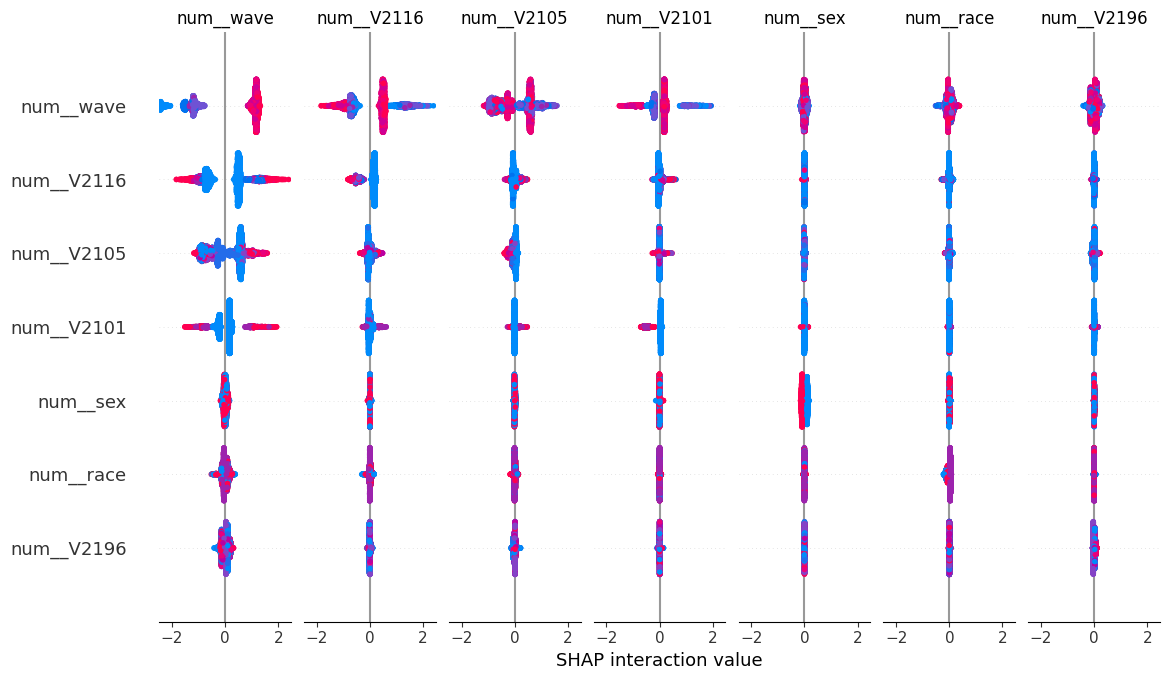

In [85]:
# Interaction Summary Plot (for overall interaction strengths)
shap.summary_plot(shap_interaction_values, X_preprocessed, feature_names=feature_names)

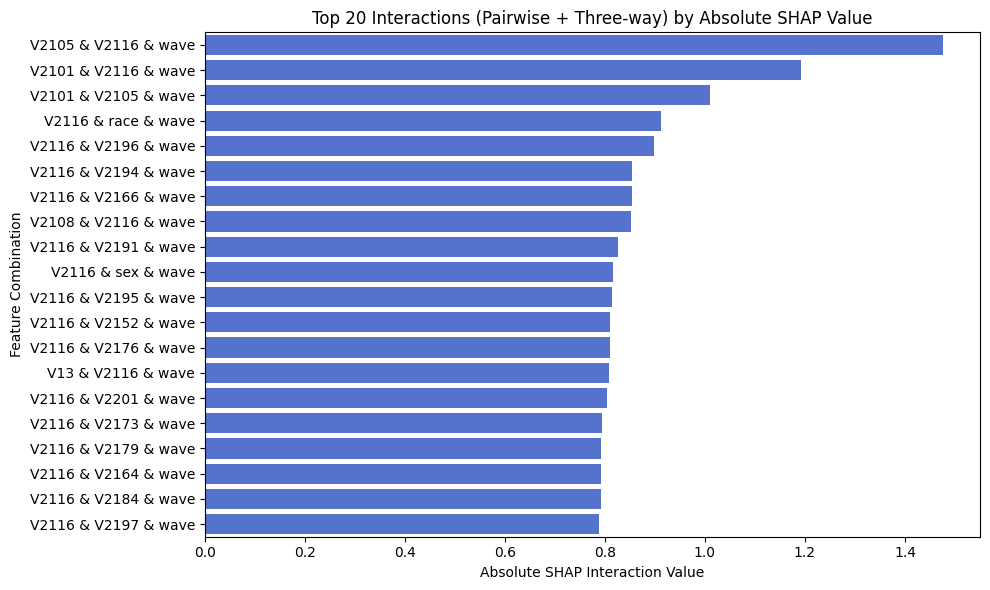

In [16]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

##############################
# 1. Pairwise Aggregation
##############################
def aggregate_shap_interactions_pairwise(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features,
    and returns a DataFrame of the mean absolute interaction for each (Feature1, Feature2).
    """
    # shap_interaction_values: [n_samples, n_features, n_features]
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) Accumulate pairwise interactions
    #    We'll sum interactions for each pair (bf_i, bf_j)
    #    Because i<j is symmetric in the shap_interaction_values, we avoid double counting.
    aggregated = {}
    for bf_i in unique_base_features:
        aggregated[bf_i] = {}
        for bf_j in unique_base_features:
            aggregated[bf_i][bf_j] = 0.0

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated[bf_i][bf_j] += interaction_matrix[i, j]
            # You could also decide to add symmetrical entries if desired:
            aggregated[bf_j][bf_i] += interaction_matrix[i, j]  # for simpler referencing

    # 4) Convert to a long DataFrame
    records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # Avoid i == j and only keep i < j in the final output (unique pairs)
            if bf_i < bf_j:
                val = aggregated[bf_i][bf_j]
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "InteractionValue": val,
                    "AbsInteraction": abs(val),
                    "Order": 2  # Mark as pairwise
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

##############################
# 2. "Three-way" Aggregation
##############################
def aggregate_shap_interactions_three_way(shap_interaction_values, feature_names, get_base_feature):
    """
    Naively computes a 'three-way' measure by summing the absolute pairwise interactions
    (i,j), (i,k), and (j,k) for each triple i < j < k.

    NOTE: This does not represent a true SHAP 3-way synergy. It's a proxy 
    by combining the pairwise interactions among the triple.
    """
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) We will group by base features for i,j,k. Because different OHE columns might map
    #    to the same base feature, let's gather all indices that map to each base feature.
    feature_indices_by_base = {}
    for idx, bf in enumerate(base_feature_names):
        if bf not in feature_indices_by_base:
            feature_indices_by_base[bf] = []
        feature_indices_by_base[bf].append(idx)

    # 4) For each triple (bf_i, bf_j, bf_k) with i < j < k, compute sum of pairwise interactions
    records = []
    bf_list = list(unique_base_features)
    n_bf = len(bf_list)

    for i in range(n_bf):
        for j in range(i + 1, n_bf):
            for k in range(j + 1, n_bf):
                bf_i, bf_j, bf_k = bf_list[i], bf_list[j], bf_list[k]

                # For all actual columns that map to bf_i, bf_j, bf_k, sum the relevant pairwise interactions:
                indices_i = feature_indices_by_base[bf_i]
                indices_j = feature_indices_by_base[bf_j]
                indices_k = feature_indices_by_base[bf_k]

                # We'll sum the absolute interaction_matrix across all pairs (i', j'), (i', k'), (j', k')
                total_interaction = 0.0
                for ii in indices_i:
                    for jj in indices_j:
                        total_interaction += interaction_matrix[ii, jj]
                        total_interaction += interaction_matrix[jj, ii]  # symmetrical

                    for kk in indices_k:
                        total_interaction += interaction_matrix[ii, kk]
                        total_interaction += interaction_matrix[kk, ii]

                for jj in indices_j:
                    for kk in indices_k:
                        total_interaction += interaction_matrix[jj, kk]
                        total_interaction += interaction_matrix[kk, jj]

                # We'll keep it as the approximate measure
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j} & {bf_k}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "Feature3": bf_k,
                    "InteractionValue": total_interaction,
                    "AbsInteraction": abs(total_interaction),
                    "Order": 3  # Mark as three-way
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


##############################
# 3. Putting it all together
##############################

# Suppose you already have:
#   shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)
#   feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()
#   We'll reuse your simple_get_base_feature function:
def simple_get_base_feature(name):
    if name.startswith("num__"):
        name = name[len("num__"):]  # e.g. "V2178"
    if name.startswith("cat__"):
        name = name[len("cat__"):]
    return name

# -- 3.1 Compute pairwise and "three-way" aggregates --
df_pairwise = aggregate_shap_interactions_pairwise(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

df_three_way = aggregate_shap_interactions_three_way(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

# -- 3.2 Combine them into one table --
#    For consistency, we can unify the column names
df_pairwise["Feature3"] = None  # no third feature for pairs
combined_df = pd.concat([df_pairwise, df_three_way], ignore_index=True)

# Sort by absolute interaction
combined_df.sort_values("AbsInteraction", ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# -- 3.3 Pick top 20 overall --
df_top_20 = combined_df.head(20).copy()

# For a nicer label that works for both pairwise and triple combos:
df_top_20["Label"] = df_top_20["FeatureCombo"]

# -- 3.4 Plot a bar chart of the top 20 combos --
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_20, y="Label", x="AbsInteraction", color="royalblue")
plt.title("Top 20 Interactions (Pairwise + Three-way) by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

# You now have a bar plot of the top 20 interactions (including both 2- and 3-feature combos).


In [17]:
df_top_20

FeatureCombo Feature1 Feature2  InteractionValue  AbsInteraction  \
0   V2105 & V2116 & wave    V2105    V2116          1.476226        1.476226   
1   V2101 & V2116 & wave    V2101    V2116          1.191638        1.191638   
2   V2101 & V2105 & wave    V2101    V2105          1.010630        1.010630   
3    V2116 & race & wave    V2116     race          0.911699        0.911699   
4   V2116 & V2196 & wave    V2116    V2196          0.897519        0.897519   
5   V2116 & V2194 & wave    V2116    V2194          0.854598        0.854598   
6   V2116 & V2166 & wave    V2116    V2166          0.853512        0.853512   
7   V2108 & V2116 & wave    V2108    V2116          0.851438        0.851438   
8   V2116 & V2191 & wave    V2116    V2191          0.826597        0.826597   
9     V2116 & sex & wave    V2116      sex          0.816372        0.816372   
10  V2116 & V2195 & wave    V2116    V2195          0.814632        0.814632   
11  V2116 & V2152 & wave    V2116    V2152          0.810475        0.810475   
12  V2116 & V2176 & wave    V2116    V2176          0.809971        0.809971   
13    V13 & V2116 & wave      V13    V2116          0.808698        0.808698   
14  V2116 & V2201 & wave    V2116    V2201          0.803737        0.803737   
15  V2116 & V2173 & wave    V2116    V2173          0.794532        0.794532   
16  V2116 & V2179 & wave    V2116    V2179          0.792970        0.792970   
17  V2116 & V2164 & wave    V2116    V2164          0.792126        0.792126   
18  V2116 & V2184 & wave    V2116    V2184          0.791779        0.791779   
19  V2116 & V2197 & wave    V2116    V2197          0.789024        0.789024   

    Order Feature3                 Label  
0       3     wave  V2105 & V2116 & wave  
1       3     wave  V2101 & V2116 & wave  
2       3     wave  V2101 & V2105 & wave  
3       3     wave   V2116 & race & wave  
4       3     wave  V2116 & V2196 & wave  
5       3     wave  V2116 & V2194 & wave  
6       3     wave  V2116 & V2166 & wave  
7       3     wave  V2108 & V2116 & wave  
8       3     wave  V2116 & V2191 & wave  
9       3     wave    V2116 & sex & wave  
10      3     wave  V2116 & V2195 & wave  
11      3     wave  V2116 & V2152 & wave  
12      3     wave  V2116 & V2176 & wave  
13      3     wave    V13 & V2116 & wave  
14      3     wave  V2116 & V2201 & wave  
15      3     wave  V2116 & V2173 & wave  
16      3     wave  V2116 & V2179 & wave  
17      3     wave  V2116 & V2164 & wave  
18      3     wave  V2116 & V2184 & wave  
19      3     wave  V2116 & V2197 & wave

## Histogram-based Gradient Boost Classifier

2025-02-14 17:06:17,375 - INFO - 
--- Gradient Boosting (Revised) ---
2025-02-14 17:06:17,376 - INFO - Starting randomized search for Gradient Boosting...


Fitting 10 folds for each of 50 candidates, totalling 500 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categorie

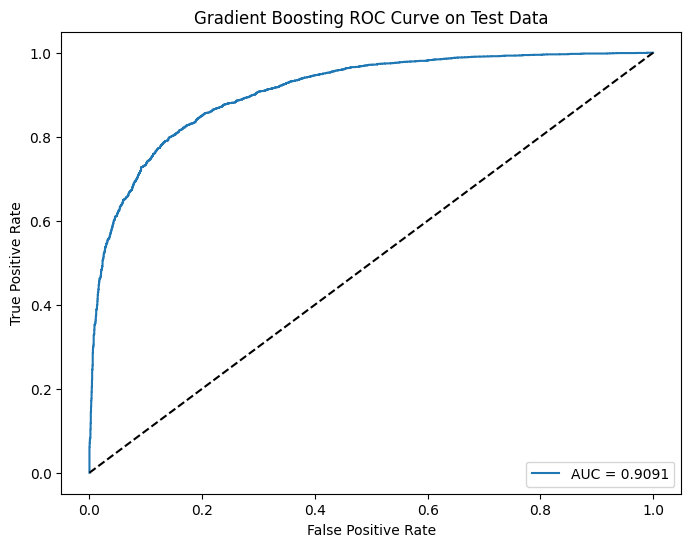

2025-02-14 17:15:31,421 - INFO - Script completed successfully.


In [8]:
import logging
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer

# Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 2  # Repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Gradient Boosting (Revised) ---")

# Define the transformer:
from sklearn.preprocessing import FunctionTransformer

def to_dense_func(X):
    """Convert sparse matrices to dense arrays (if needed)."""
    return X.toarray() if hasattr(X, 'toarray') else X

to_dense = FunctionTransformer(to_dense_func)

# Build pipeline
gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('to_dense', to_dense),
    ('classifier', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
# Optimized parameter grid for 24-core/100GB RAM
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Wider range including very low rates
    'classifier__max_depth': [6, 12, 18],                 # Deeper trees with more variation
    'classifier__min_samples_leaf': [20, 50, 100],        # More granular leaf sizes
    'classifier__l2_regularization': [0.0, 0.1, 0.5, 1.0],# Stronger regularization options
    'classifier__max_bins': [255],                        # Keep max bins for accuracy
    'classifier__max_leaf_nodes': [64, 128, 256],         # Control tree complexity
    'classifier__max_iter': [2000],                       # Let early stopping handle actual iterations
}

try:
    logging.info("Starting randomized search for Gradient Boosting...")

    # Use RepeatedStratifiedKFold without shuffle
    cv_gbc = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )

    # RandomizedSearchCV to cover more combinations within reasonable compute time
    gbc_random_search = RandomizedSearchCV(
        estimator=gbc_pipeline,
        param_distributions=param_grid,
        n_iter=50,  # Increase or decrease based on resources
        cv=cv_gbc,
        scoring=SCORING_METRIC,
        n_jobs=24,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )

    # Fit the RandomizedSearchCV
    gbc_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (GBC): {gbc_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {gbc_random_search.best_score_:.4f}")

    # Extract the best estimator
    best_gbc = gbc_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting randomized search: {e}")
    raise

# Evaluate the best Gradient Boosting model
try:
    best_gbc.fit(X_train_with_indicators, y_train)
    y_pred_gbc = best_gbc.predict(X_test_with_indicators)
    y_pred_proba_gbc = best_gbc.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Gradient Boosting Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_gbc)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_gbc)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gbc):.4f}")

    # Plot ROC Curve
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_gbc, tpr_gbc, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_gbc):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [9]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_hgbt_model.joblib')

# Save the trained model
joblib.dump(best_gbc, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-14 17:16:56,234 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_hgbt_model.joblib


In [18]:
# Load the model (when needed)
# Define the transformer:
from sklearn.preprocessing import FunctionTransformer

def to_dense_func(X):
    """Convert sparse matrices to dense arrays (if needed)."""
    return X.toarray() if hasattr(X, 'toarray') else X

to_dense = FunctionTransformer(to_dense_func)


file_path = os.path.expanduser('~/work/vaping_project_data/best_hgbt_model.joblib')
loaded_hgbt = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categorie

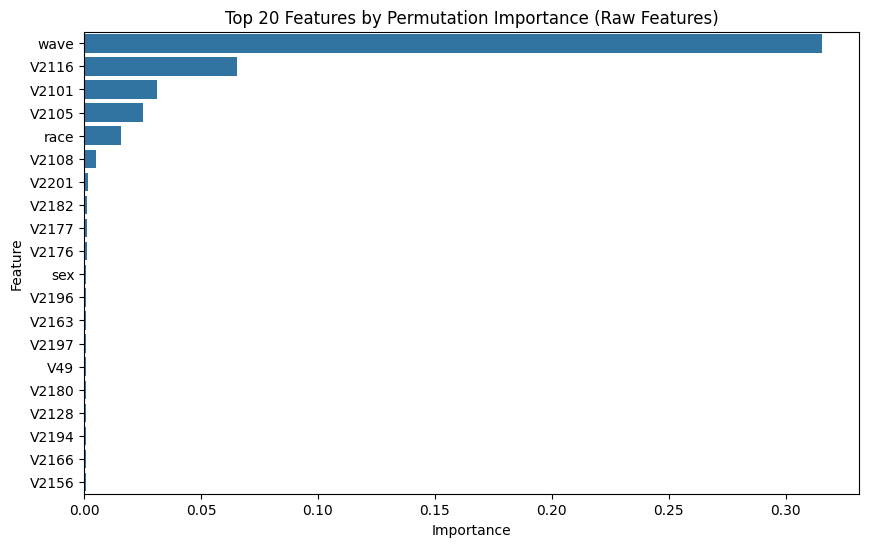

In [11]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on RAW DATA (let pipeline handle preprocessing)
result = permutation_importance(
    loaded_hgbt,  # This is your full pipeline
    X_test_with_indicators,  # Raw data with missing indicators
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=CPU_COUNT
)

# Get feature names from the raw data (including missing indicators)
feature_names = X_test_with_indicators.columns.tolist()

# Create importance DataFrame
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance.head(20))
plt.title("Top 20 Features by Permutation Importance (Raw Features)")
plt.show()

In [12]:
# Create a table for top 20 feature importances
top_20_features = perm_importance.head(20)

# Display the table
print("Top 20 Feature Importances:")
display(top_20_features.style.background_gradient(cmap='Blues', subset=['Importance']))

Top 20 Feature Importances:


In [19]:
##### SHAP Feature Importance ####

# Extract the GradientBoostingClassifier
hgbt_models = loaded_hgbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_hgbt.named_steps['preprocessor'].transform(X_test_with_indicators)
# Convert sparse matrix to DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed.toarray())
# Create SHAP explainer
explainer = shap.TreeExplainer(hgbt_models)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed)
# Get feature names after preprocessing
feature_names = loaded_hgbt.named_steps['preprocessor'].get_feature_names_out()

/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


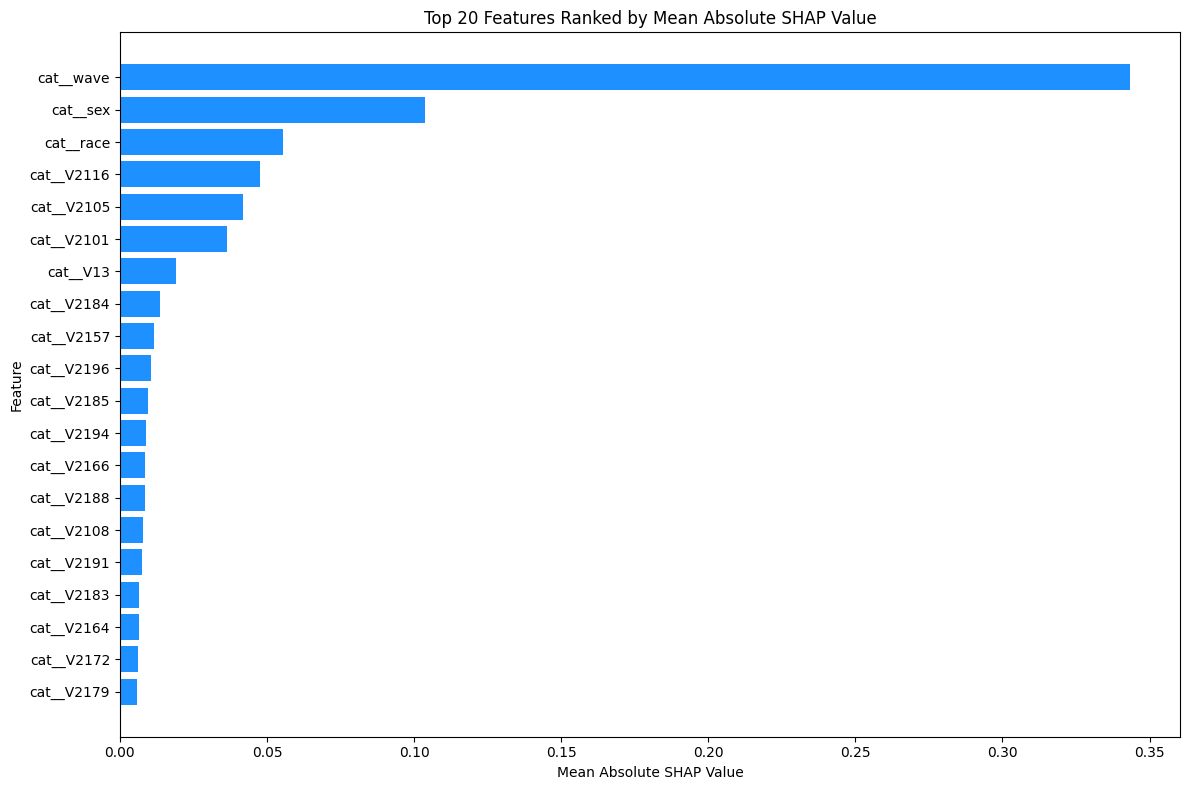

In [20]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = '_'.join(col.split('_')[:-1])  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

In [21]:
top_20_importance_df

Feature  Importance
0    cat__wave    0.343188
1     cat__sex    0.103714
2    cat__race    0.055590
3   cat__V2116    0.047660
4   cat__V2105    0.041843
5   cat__V2101    0.036403
6     cat__V13    0.018992
7   cat__V2184    0.013681
8   cat__V2157    0.011698
9   cat__V2196    0.010458
10  cat__V2185    0.009718
11  cat__V2194    0.008786
12  cat__V2166    0.008481
13  cat__V2188    0.008477
14  cat__V2108    0.007862
15  cat__V2191    0.007461
16  cat__V2183    0.006544
17  cat__V2164    0.006369
18  cat__V2172    0.006272
19  cat__V2179    0.005822

In [22]:
import numpy as np

# Suppose your X_preprocessed is shape (n_samples, n_features).
# Randomly sample e.g. 300 rows:
sample_size = 300
if X_preprocessed.shape[0] > sample_size:
    rnd_idx = np.random.choice(X_preprocessed.shape[0], sample_size, replace=False)
    X_sampled = X_preprocessed.iloc[rnd_idx]

else:
    X_sampled = X_preprocessed

# Now compute interaction values on this smaller subset
shap_interaction_values = explainer.shap_interaction_values(X_sampled)

   Feature1 Feature2  InteractionValue  AbsInteraction
1      wave    V2116          0.512344        0.512344
2      wave    V2105          0.453857        0.453857
3      wave    V2101          0.280974        0.280974
4      wave     race          0.173988        0.173988
5      wave    V2196          0.081804        0.081804
6      wave    V2108          0.077313        0.077313
7     V2166     wave          0.053517        0.053517
8     V2194     wave          0.050455        0.050455
9      wave      sex          0.049956        0.049956
10     wave      V13          0.041606        0.041606
11    V2116    V2105          0.038339        0.038339
12    V2116    V2101          0.035215        0.035215
13     wave    V2191          0.033705        0.033705
14     wave    V2152          0.033623        0.033623
15     wave    V2179          0.033035        0.033035
17    V2201     wave          0.031867        0.031867
18    V2116     race          0.030408        0.030408
19     wav

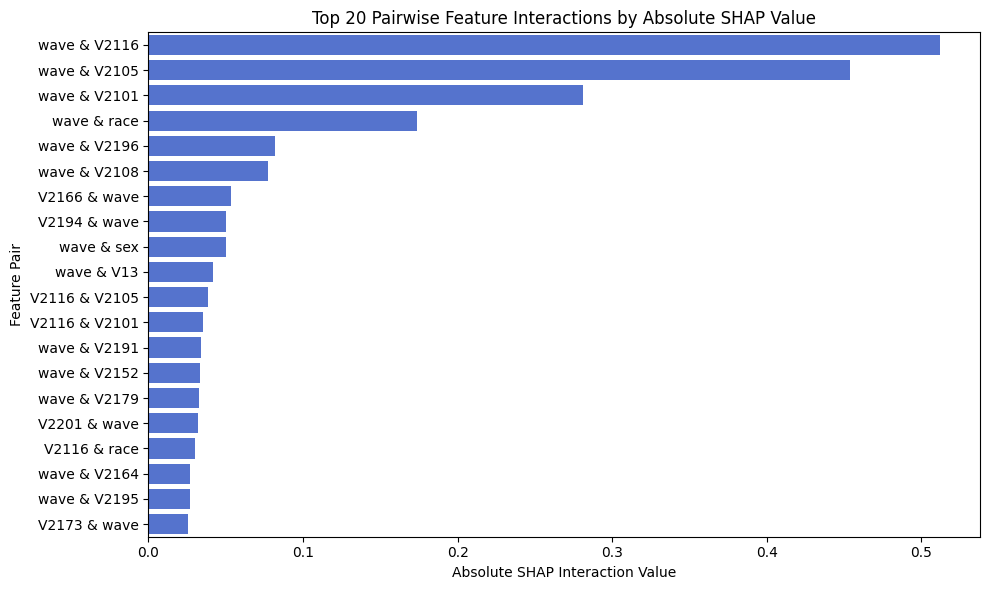

In [22]:
import numpy as np
import pandas as pd

def aggregate_shap_interactions(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features.
    
    Parameters
    ----------
    shap_interaction_values : np.ndarray
        SHAP interaction values of shape [n_samples, n_features, n_features].
    feature_names : list of str
        The one-hot-encoded feature names corresponding to shap_interaction_values.
    get_base_feature : callable
        A function that takes a one-hot-encoded feature name and returns the base/original feature name.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with ["Feature1", "Feature2", "InteractionValue", "AbsInteraction"] 
        sorted in descending order of AbsInteraction.
    """
    # 1. Aggregate across samples (e.g., mean absolute interactions)
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)
    
    # 2. Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(n) for n in feature_names]
    unique_base_features = list(set(base_feature_names))
    
    # 3. Build a structure to accumulate aggregated pairwise interactions
    aggregated_interactions = {
        bf_i: {bf_j: 0.0 for bf_j in unique_base_features}
        for bf_i in unique_base_features
    }

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i+1, n_features): # i+1 => no diagonal, no duplicates
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated_interactions[bf_i][bf_j] += interaction_matrix[i, j]
    
    # 4. Convert to DataFrame
    data_records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # If you want to keep only i <= j, add a condition to avoid duplicates
            interaction_val = aggregated_interactions[bf_i][bf_j]
            data_records.append((bf_i, bf_j, interaction_val))
    
    df_interactions = pd.DataFrame(data_records, columns=["Feature1", "Feature2", "InteractionValue"])
    df_interactions["AbsInteraction"] = df_interactions["InteractionValue"].abs()
    
    # Sort descending by absolute interaction
    df_interactions.sort_values("AbsInteraction", ascending=False, inplace=True)
    df_interactions.reset_index(drop=True, inplace=True)
    df_interactions_no_diagonal = df_interactions[df_interactions['Feature1'] != df_interactions['Feature2']]
    return df_interactions_no_diagonal


# Example usage:
def simple_get_base_feature(name):
    # Remove the cat__ prefix if present
    if name.startswith("cat__"):
        name = name[len("cat__"):]
    # Then split on the first underscore only
    return name.split("_", 1)[0]

df_agg_interactions = aggregate_shap_interactions(
    shap_interaction_values=shap_interaction_values,
    feature_names=feature_names,
    get_base_feature=simple_get_base_feature
)

# Print the top 20 interactions
print(df_agg_interactions.head(20))

# --- Pick Top 20 Interactions ---
df_top_20 = df_agg_interactions.head(20).copy()

# Create a convenient label for each pair
df_top_20["Pair"] = df_top_20["Feature1"] + " & " + df_top_20["Feature2"]

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_20, 
    y="Pair", 
    x="AbsInteraction", 
    color="royalblue"
)
plt.title("Top 20 Pairwise Feature Interactions by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Pair")
plt.tight_layout()
plt.show()



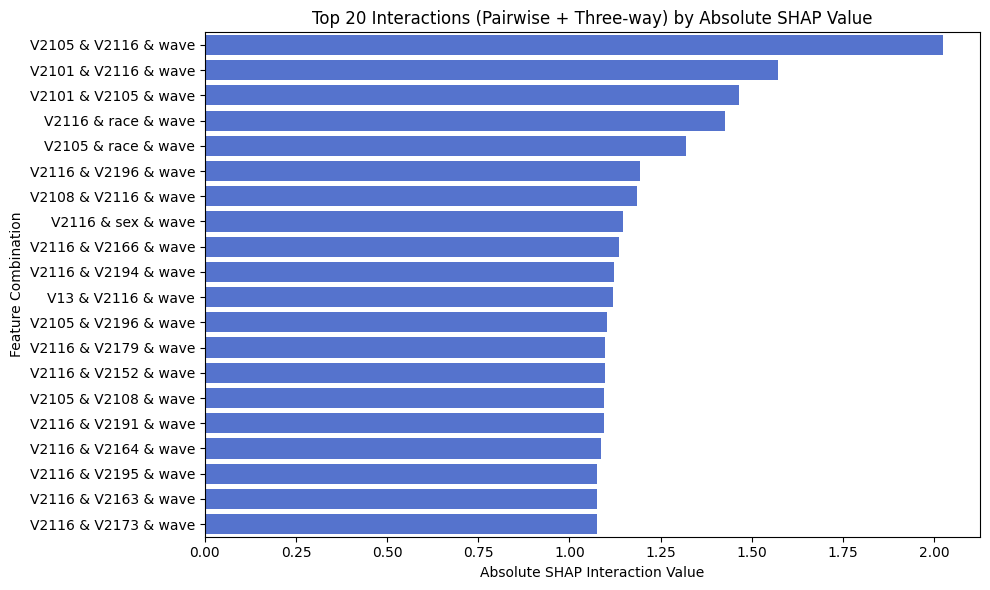

In [25]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

##############################
# 1. Pairwise Aggregation
##############################
def aggregate_shap_interactions_pairwise(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features,
    and returns a DataFrame of the mean absolute interaction for each (Feature1, Feature2).
    """
    # shap_interaction_values: [n_samples, n_features, n_features]
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) Accumulate pairwise interactions
    #    We'll sum interactions for each pair (bf_i, bf_j)
    #    Because i<j is symmetric in the shap_interaction_values, we avoid double counting.
    aggregated = {}
    for bf_i in unique_base_features:
        aggregated[bf_i] = {}
        for bf_j in unique_base_features:
            aggregated[bf_i][bf_j] = 0.0

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated[bf_i][bf_j] += interaction_matrix[i, j]
            # You could also decide to add symmetrical entries if desired:
            aggregated[bf_j][bf_i] += interaction_matrix[i, j]  # for simpler referencing

    # 4) Convert to a long DataFrame
    records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # Avoid i == j and only keep i < j in the final output (unique pairs)
            if bf_i < bf_j:
                val = aggregated[bf_i][bf_j]
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "InteractionValue": val,
                    "AbsInteraction": abs(val),
                    "Order": 2  # Mark as pairwise
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

##############################
# 2. "Three-way" Aggregation
##############################
def aggregate_shap_interactions_three_way(shap_interaction_values, feature_names, get_base_feature):
    """
    Naively computes a 'three-way' measure by summing the absolute pairwise interactions
    (i,j), (i,k), and (j,k) for each triple i < j < k.

    NOTE: This does not represent a true SHAP 3-way synergy. It's a proxy 
    by combining the pairwise interactions among the triple.
    """
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) We will group by base features for i,j,k. Because different OHE columns might map
    #    to the same base feature, let's gather all indices that map to each base feature.
    feature_indices_by_base = {}
    for idx, bf in enumerate(base_feature_names):
        if bf not in feature_indices_by_base:
            feature_indices_by_base[bf] = []
        feature_indices_by_base[bf].append(idx)

    # 4) For each triple (bf_i, bf_j, bf_k) with i < j < k, compute sum of pairwise interactions
    records = []
    bf_list = list(unique_base_features)
    n_bf = len(bf_list)

    for i in range(n_bf):
        for j in range(i + 1, n_bf):
            for k in range(j + 1, n_bf):
                bf_i, bf_j, bf_k = bf_list[i], bf_list[j], bf_list[k]

                # For all actual columns that map to bf_i, bf_j, bf_k, sum the relevant pairwise interactions:
                indices_i = feature_indices_by_base[bf_i]
                indices_j = feature_indices_by_base[bf_j]
                indices_k = feature_indices_by_base[bf_k]

                # We'll sum the absolute interaction_matrix across all pairs (i', j'), (i', k'), (j', k')
                total_interaction = 0.0
                for ii in indices_i:
                    for jj in indices_j:
                        total_interaction += interaction_matrix[ii, jj]
                        total_interaction += interaction_matrix[jj, ii]  # symmetrical

                    for kk in indices_k:
                        total_interaction += interaction_matrix[ii, kk]
                        total_interaction += interaction_matrix[kk, ii]

                for jj in indices_j:
                    for kk in indices_k:
                        total_interaction += interaction_matrix[jj, kk]
                        total_interaction += interaction_matrix[kk, jj]

                # We'll keep it as the approximate measure
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j} & {bf_k}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "Feature3": bf_k,
                    "InteractionValue": total_interaction,
                    "AbsInteraction": abs(total_interaction),
                    "Order": 3  # Mark as three-way
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


##############################
# 3. Putting it all together
##############################

# Suppose you already have:
#   shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)
#   feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()
#   We'll reuse your simple_get_base_feature function:
import re

def simple_get_base_feature(name):
    """
    Strips off numerical one-hot encoding suffixes (e.g., 'wave_2021' → 'wave').
    """
    # Remove 'num__' or 'cat__' prefix if present
    if name.startswith("num__"):
        name = name[len("num__"):]
    if name.startswith("cat__"):
        name = name[len("cat__"):]

    # Remove one-hot encoding suffix (_YYYY or _X.X for categorical variables)
    name = re.sub(r"_\d+(\.\d+)?$", "", name)  # Removes _2021, _2.0, etc.

    return name

# -- 3.1 Compute pairwise and "three-way" aggregates --
df_pairwise = aggregate_shap_interactions_pairwise(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

df_three_way = aggregate_shap_interactions_three_way(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

# -- 3.2 Combine them into one table --
#    For consistency, we can unify the column names
df_pairwise["Feature3"] = None  # no third feature for pairs
combined_df = pd.concat([df_pairwise, df_three_way], ignore_index=True)

# Sort by absolute interaction
combined_df.sort_values("AbsInteraction", ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# -- 3.3 Pick top 20 overall --
df_top_20 = combined_df.head(20).copy()

# For a nicer label that works for both pairwise and triple combos:
df_top_20["Label"] = df_top_20["FeatureCombo"]

# -- 3.4 Plot a bar chart of the top 20 combos --
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_20, y="Label", x="AbsInteraction", color="royalblue")
plt.title("Top 20 Interactions (Pairwise + Three-way) by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

# You now have a bar plot of the top 20 interactions (including both 2- and 3-feature combos).


In [26]:
df_top_20

FeatureCombo Feature1 Feature2  InteractionValue  AbsInteraction  \
0   V2105 & V2116 & wave    V2105    V2116          2.024536        2.024536   
1   V2101 & V2116 & wave    V2101    V2116          1.572898        1.572898   
2   V2101 & V2105 & wave    V2101    V2105          1.466181        1.466181   
3    V2116 & race & wave    V2116     race          1.426327        1.426327   
4    V2105 & race & wave    V2105     race          1.318628        1.318628   
5   V2116 & V2196 & wave    V2116    V2196          1.194406        1.194406   
6   V2108 & V2116 & wave    V2108    V2116          1.185153        1.185153   
7     V2116 & sex & wave    V2116      sex          1.147406        1.147406   
8   V2116 & V2166 & wave    V2116    V2166          1.136976        1.136976   
9   V2116 & V2194 & wave    V2116    V2194          1.122110        1.122110   
10    V13 & V2116 & wave      V13    V2116          1.119324        1.119324   
11  V2105 & V2196 & wave    V2105    V2196          1.102067        1.102067   
12  V2116 & V2179 & wave    V2116    V2179          1.098296        1.098296   
13  V2116 & V2152 & wave    V2116    V2152          1.097879        1.097879   
14  V2105 & V2108 & wave    V2105    V2108          1.095919        1.095919   
15  V2116 & V2191 & wave    V2116    V2191          1.094992        1.094992   
16  V2116 & V2164 & wave    V2116    V2164          1.085193        1.085193   
17  V2116 & V2195 & wave    V2116    V2195          1.076498        1.076498   
18  V2116 & V2163 & wave    V2116    V2163          1.075862        1.075862   
19  V2116 & V2173 & wave    V2116    V2173          1.074293        1.074293   

    Order Feature3                 Label  
0       3     wave  V2105 & V2116 & wave  
1       3     wave  V2101 & V2116 & wave  
2       3     wave  V2101 & V2105 & wave  
3       3     wave   V2116 & race & wave  
4       3     wave   V2105 & race & wave  
5       3     wave  V2116 & V2196 & wave  
6       3     wave  V2108 & V2116 & wave  
7       3     wave    V2116 & sex & wave  
8       3     wave  V2116 & V2166 & wave  
9       3     wave  V2116 & V2194 & wave  
10      3     wave    V13 & V2116 & wave  
11      3     wave  V2105 & V2196 & wave  
12      3     wave  V2116 & V2179 & wave  
13      3     wave  V2116 & V2152 & wave  
14      3     wave  V2105 & V2108 & wave  
15      3     wave  V2116 & V2191 & wave  
16      3     wave  V2116 & V2164 & wave  
17      3     wave  V2116 & V2195 & wave  
18      3     wave  V2116 & V2163 & wave  
19      3     wave  V2116 & V2173 & wave

## XGBOOST

2025-02-15 10:33:01,124 - INFO - Starting RandomizedSearchCV for expanded XGBoost grid...


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/s

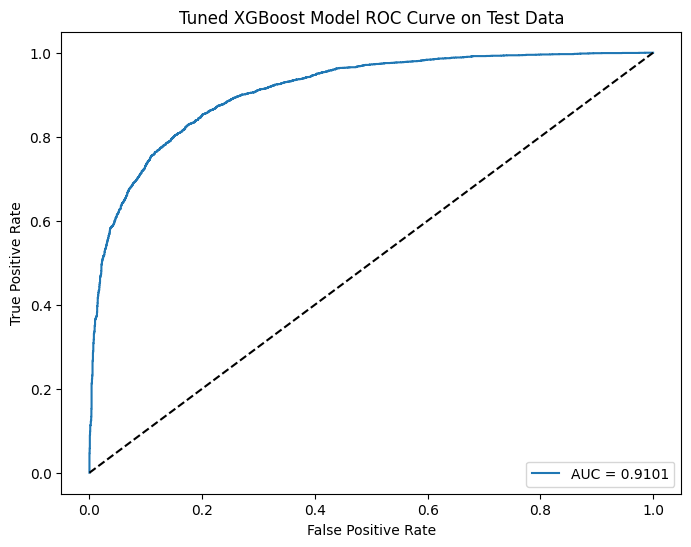

2025-02-15 10:38:07,350 - INFO - Final XGBoost model saved to: /storage/home/szn5432/work/vaping_project_data/best_xgb_model.joblib


In [19]:
import os
import logging
import joblib
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# ======================
# 1. Expanded Hyperparameter Grid
# ======================
param_dist = {
    # Increase n_estimators up to 1000 (or more)
    'classifier__n_estimators': [100, 300, 500, 800, 1000],
    
    # Smaller learning rates for finer updates
    'classifier__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
    
    # Broader range for max_depth
    'classifier__max_depth': [3, 5, 7, 9, 12],
    
    # Tweak min_child_weight to control complexity
    'classifier__min_child_weight': [1, 3, 5, 7, 10],
    
    # Keep or enlarge subsample
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # Potentially try colsample_bytree > 1.0 (uncommon, but possible)
    'classifier__colsample_bytree': [0.6, 0.8, 1.0, 1.2],
    
    # Adjust gamma (larger => more conservative splits)
    'classifier__gamma': [0, 0.1, 0.3, 0.6, 1.0],
    
    # Expand regularization range
    'classifier__reg_alpha': [0, 0.1, 0.2, 0.5, 1.0, 2.0],
    'classifier__reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
}

# ============================
# 2. OPTIONAL FEATURE ENGINEERING
# ============================
# Example: add a custom transformer to create domain-specific or interaction features
# (Here, we just pass data through, but you'd modify 'feature_engineering' to transform the input DataFrame.)

def feature_engineering(X):
    """
    Placeholder function where you can create domain-specific,
    polynomial, or ratio features. This must return a DataFrame or array.
    """
    # Example: create a simple ratio of two columns (if they exist)
    # if 'colA' in X and 'colB' in X:
    #     X['ratio_A_B'] = X['colA'] / (X['colB'] + 1e-9)
    
    return X

feature_eng_transformer = FunctionTransformer(feature_engineering, validate=False)

# ============================
# 3. Build Pipeline
# ============================
# We assume:
#   - You already have 'preprocessor' for OneHotEncoder, etc.
#   - 'X_train_with_indicators', 'y_train', 'X_test_with_indicators', 'y_test'
#   - 'train_evaluate_model(...)' function
#   - Constants: RANDOM_STATE, SCORING_METRIC, N_SPLITS_CV

xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

# Here we insert a feature engineering step *before* the preprocessor:
xgb_pipeline = Pipeline([
    ('feature_engineering', feature_eng_transformer),
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

# =========================
# 4. (Optional) Early Stopping
# =========================
# In scikit-learn's RandomizedSearchCV, providing early_stopping_rounds is non-trivial because
# you need a separate validation set or a custom approach inside each CV fold.
# If you wish to do a simple holdout for early stopping, you'd do something like:
#
# fit_params = {
#    'classifier__early_stopping_rounds': 30,
#    'classifier__eval_metric': 'logloss',
#    'classifier__eval_set': [(X_val, y_val)],  # separate validation set
# }
#
# Then pass fit_params=fit_params to random_search.fit(...).
# This is more advanced; we’ll skip it here for brevity.

# ============================
# 5. Randomized Search Setup
# ============================
cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Increase if you have time/resources
    cv=cv,
    scoring=SCORING_METRIC,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

logging.info("Starting RandomizedSearchCV for expanded XGBoost grid...")
random_search.fit(X_train_with_indicators, y_train)
logging.info("RandomizedSearchCV complete.")

best_xgb_model = random_search.best_estimator_
logging.info(f"Best parameters: {random_search.best_params_}")
logging.info(f"Best CV {SCORING_METRIC}: {random_search.best_score_:.4f}")

# ============================
# 6. Evaluate & Save Best Model
# ============================
trained_best_xgb = train_evaluate_model(
    model=best_xgb_model,
    X_train=X_train_with_indicators,
    y_train=y_train,
    X_test=X_test_with_indicators,
    y_test=y_test,
    model_name="Tuned XGBoost Model"
)

model_filename = os.path.expanduser('~/work/vaping_project_data/best_xgb_model.joblib')
joblib.dump(trained_best_xgb, model_filename)
logging.info(f"Final XGBoost model saved to: {model_filename}")


In [10]:
# Load the model (when needed)
def feature_engineering(X):
    """
    Placeholder function where you can create domain-specific,
    polynomial, or ratio features. This must return a DataFrame or array.
    """
    # Example: create a simple ratio of two columns (if they exist)
    # if 'colA' in X and 'colB' in X:
    #     X['ratio_A_B'] = X['colA'] / (X['colB'] + 1e-9)
    
    return X

file_path = os.path.expanduser('~/work/vaping_project_data/best_xgb_model.joblib')
loaded_xgb = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


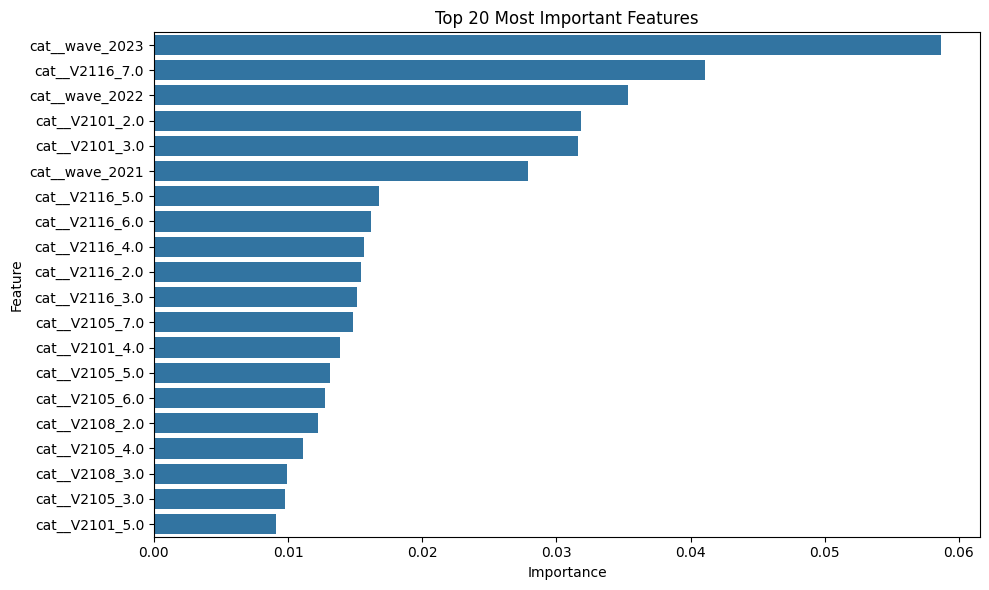

In [10]:
# Function to plot feature importances
def plot_feature_importance(loaded_xgb, feature_names, top_n=20, title="Feature Importance"):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(loaded_xgb, 'feature_importances_'):
        importances = loaded_xgb.feature_importances_
    elif hasattr(loaded_xgb, 'named_steps') and 'classifier' in loaded_xgb.named_steps:
        if hasattr(loaded_xgb.named_steps['classifier'], 'feature_importances_'):
            importances = loaded_xgb.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")

    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get the feature names from the preprocessor
feature_names = loaded_xgb.named_steps['preprocessor'].get_feature_names_out()

# Plot the top 20 most important features
plot_feature_importance(loaded_xgb, feature_names, top_n=20, title="Top 20 Most Important Features")

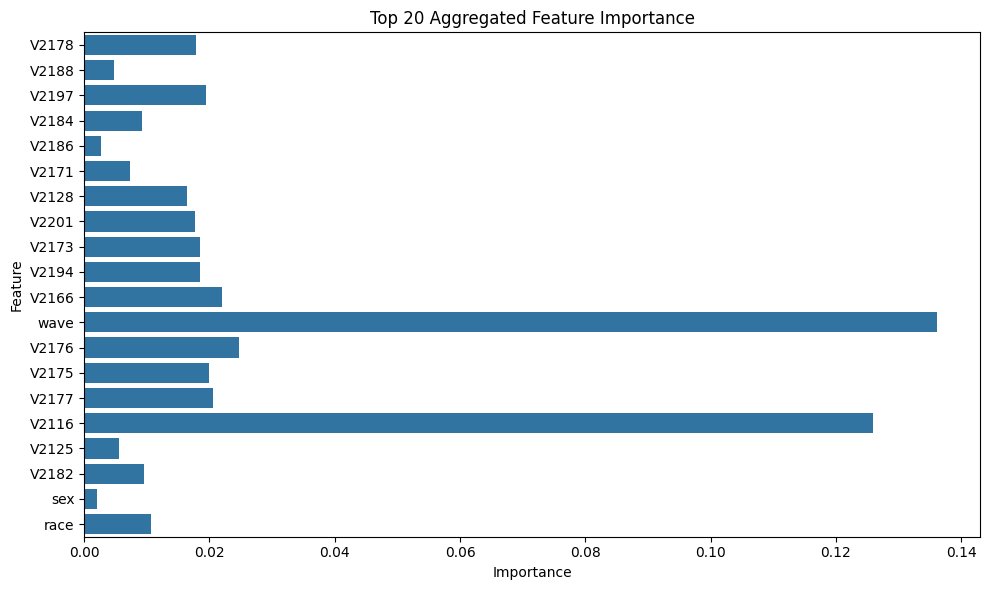

   Feature  Importance
0    V2178    0.017874
1    V2188    0.004687
2    V2197    0.019518
3    V2184    0.009190
4    V2186    0.002748
5    V2171    0.007341
6    V2128    0.016467
7    V2201    0.017721
8    V2173    0.018521
9    V2194    0.018506
10   V2166    0.022006
11    wave    0.136195
12   V2176    0.024716
13   V2175    0.019908
14   V2177    0.020626
15   V2116    0.125918
16   V2125    0.005521
17   V2182    0.009545
18     sex    0.001981
19    race    0.010658


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_aggregated_feature_importance(model, top_n=20, title="Top 20 Aggregated Feature Importance"):
    """
    Plots the top N aggregated feature importances for a CatBoost model
    that is wrapped inside a Pipeline with a ColumnTransformer.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline that includes:
          - 'preprocessor': a ColumnTransformer or other transformer
          - 'classifier': a CatBoostClassifier
    top_n : int, optional (default=20)
        How many top aggregated features to display.
    title : str, optional
        Title of the plot.
    """
    # 1. Get the feature names after the preprocessor step
    feature_names = loaded_xgb.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Get the feature importances from CatBoost
    xgboost_estimator = loaded_xgb.named_steps['classifier']
    if not hasattr(xgboost_estimator, 'feature_importances_'):
        raise AttributeError("The CatBoost classifier does not expose 'feature_importances_'.")

    importances = xgboost_estimator.feature_importances_

    # 3. Aggregate importances by original feature
    aggregated_importance = {}
    
    for name, imp in zip(feature_names, importances):
        # Example naming conventions after ColumnTransformer + OneHotEncoder:
        #   "onehotencoder__Gender_Male"
        #   "remainder__Age"
        # Adjust this parsing logic as necessary for your pipeline.
        
        if "__" in name:
            # Split on the double underscore to separate the transformer name vs. the actual column
            parts = name.split("__", maxsplit=1)
            # parts[0] might be 'onehotencoder' or 'remainder'
            # parts[1] might be 'Gender_Male' or 'Age'
            # We'll then split again on '_' if needed to get just the original column name
            col_part = parts[1]
            
            # If the column was numeric (remainder), it may be simply 'Age'.
            # If the column was OHE, it might be 'Gender_Male' or 'Gender_Female'.
            # A simple approach is to take everything before the first underscore as the feature name:
            if "_" in col_part:
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                original_feature = col_part
        else:
            # If there's no double underscore, assume the whole name is the feature
            original_feature = name
        
        # Sum up the importances
        aggregated_importance[original_feature] = aggregated_importance.get(original_feature, 0.0) + imp

    # 4. Make a DataFrame of aggregated importances and sort
    agg_df = pd.DataFrame(list(aggregated_importance.items()), columns=["Feature", "Importance"])
    agg_df.sort_values("Importance", ascending=False)

    # 5. Plot top N aggregated feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=agg_df.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # 6. Print the importance table (Top 20 Features)
    print(agg_df.head(20))


# --- Usage Example ---
# Assuming you have your best_model pipeline (with 'preprocessor' and CatBoost 'classifier'):

plot_aggregated_feature_importance(loaded_xgb, top_n=20, title="Top 20 Aggregated Feature Importance")


Top 10 aggregated features:
 ['wave', 'V2116', 'V2101', 'V2105', 'V2108', 'V2193', 'V2152', 'V2191', 'V2176', 'V2179']


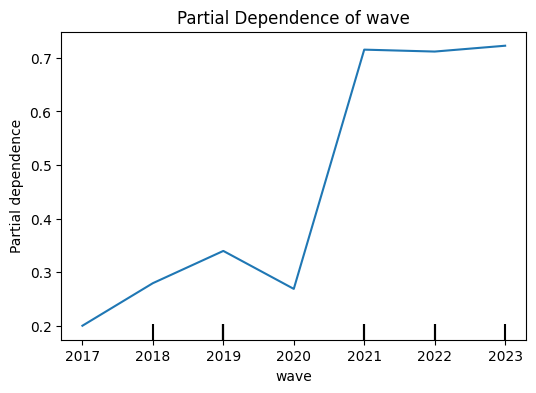

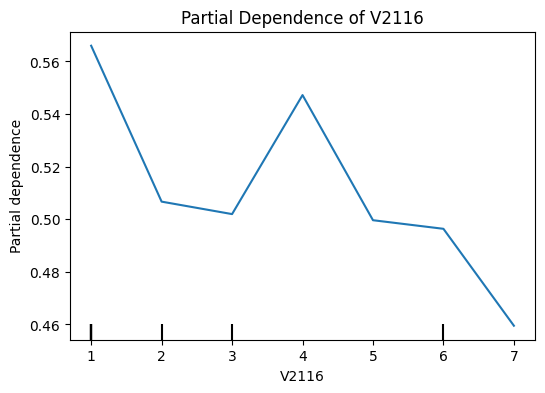

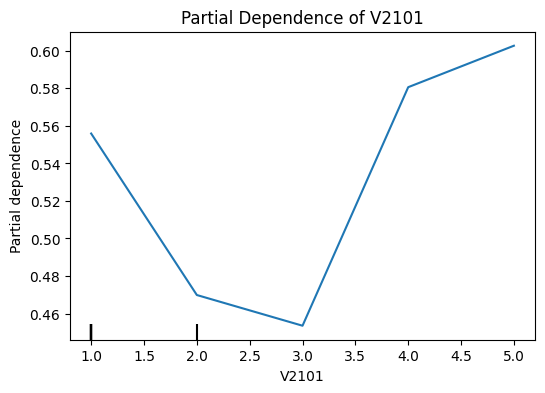

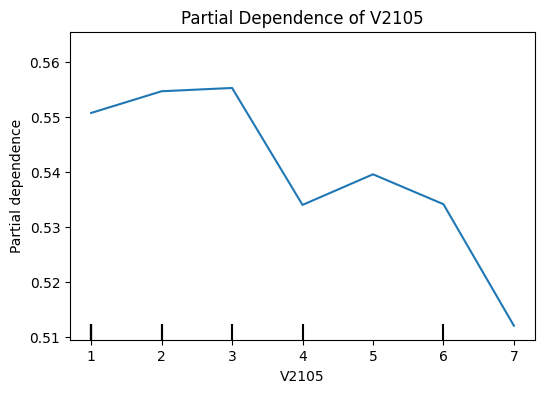

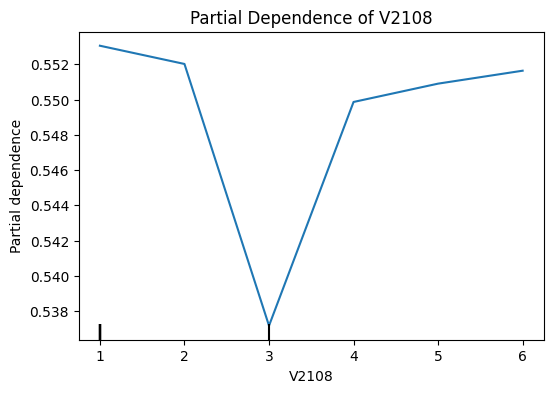

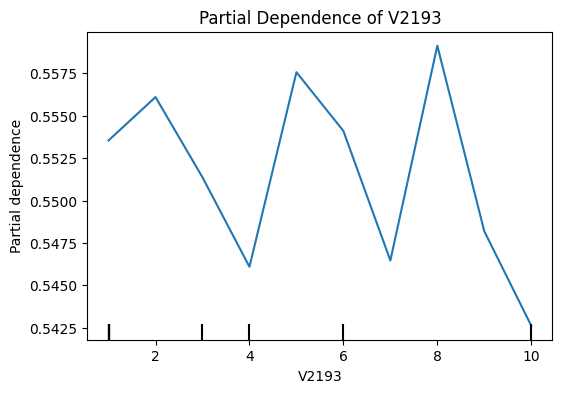

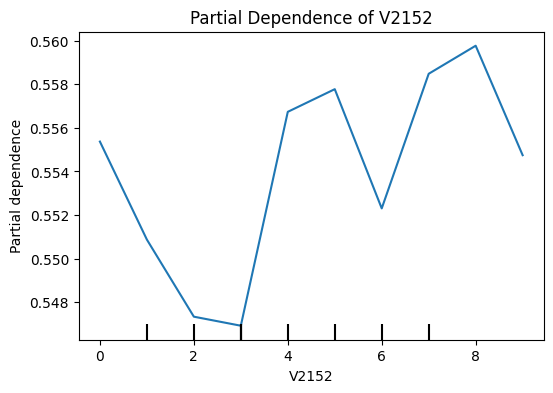

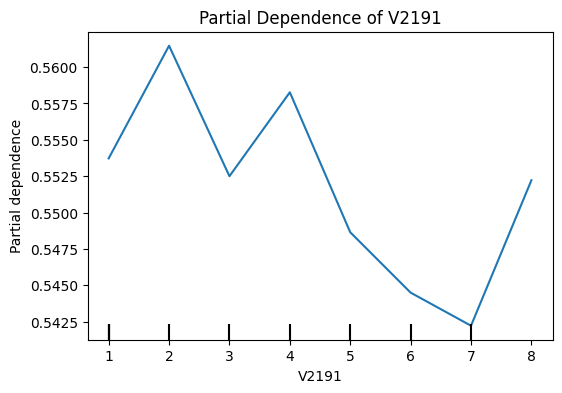

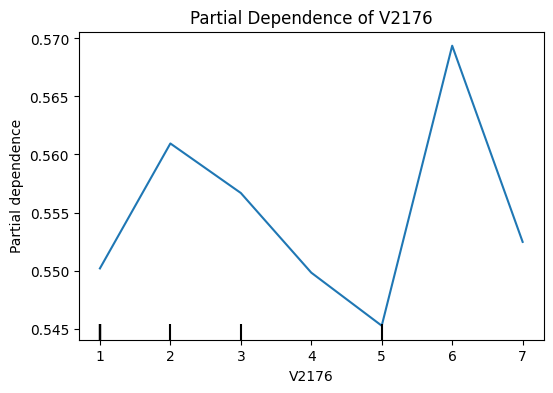

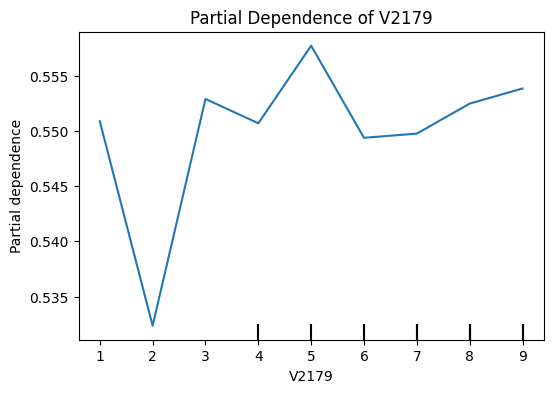

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


def get_top_aggregated_features(loaded_xgb, top_n=10):
    """
    Returns a list of top_n original (aggregated) feature names
    based on the CatBoost feature importances in a Pipeline.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline with steps:
          - "preprocessor" : ColumnTransformer (or similar)
          - "classifier" : CatBoostClassifier
    top_n : int
        Number of top features to return
        
    Returns
    -------
    list of str
        Top N aggregated feature names
    """
    # Extract feature names that come out of the preprocessor
    feature_names = loaded_xgb.named_steps['preprocessor'].get_feature_names_out()
    
    # Extract importances from CatBoost
    xgboost_estimator = loaded_xgb.named_steps['classifier']
    importances = xgboost_estimator.feature_importances_

    # Aggregate importances by the original (pre-encoding) feature name
    aggregated_importance = {}
    for name, imp in zip(feature_names, importances):
        if "__" in name:
            # Example: "onehotencoder__Gender_Male" -> original_feature = "Gender"
            parts = name.split("__", maxsplit=1)
            col_part = parts[1]
            if "_" in col_part: 
                # For OHE columns like "Gender_Male"
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                # For remainder numeric columns
                original_feature = col_part
        else:
            # If no __, assume name is the feature
            original_feature = name
        
        aggregated_importance[original_feature] = (
            aggregated_importance.get(original_feature, 0.0) + imp
        )

    # Turn into a DataFrame, sort, and get top_n
    agg_df = pd.DataFrame(
        list(aggregated_importance.items()), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    return agg_df.head(top_n)["Feature"].tolist()

# 1. Get the top 10 features by aggregated importance
top_features = get_top_aggregated_features(loaded_xgb, top_n=10)
print("Top 10 aggregated features:\n", top_features)

# Plot the partial dependence plot
for feat in top_features:
    if feat not in X_train_with_indicators.columns:
        print(f"Skipping feature '{feat}' as it is not found in the DataFrame.")
        continue

    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        estimator=loaded_xgb,
        X=X_train_with_indicators,
        features=[feat],
        kind='average',
        grid_resolution=50,
        target=1,  # positive class for binary classification
        ax=ax
    )
    plt.title(f"Partial Dependence of {feat}")
    plt.show()




In [11]:
# Add this import at the top of your script
from scipy import sparse

# --- SHAP Feature Importance ---
# Suppose your ColumnTransformer has the name "cat" for the OneHotEncoder step
# and you pass in categorical_features as the input_features:
encoded_feature_names = (
    preprocessor
    .named_transformers_['cat']  # "cat" is the name of the OHE step in ColumnTransformer
    .get_feature_names_out(input_features=categorical_features)
)


# Extract components from the pipeline
preprocessor = loaded_xgb.named_steps['preprocessor']
classifier = loaded_xgb.named_steps['classifier']

# Process the data through the pipeline
X_processed = preprocessor.transform(X_train_with_indicators)

# Convert sparse matrix to dense if needed
if isinstance(X_processed, (sparse.csr_matrix, sparse.csc_matrix)):
    X_processed = X_processed.toarray()

# Create a SHAP explainer
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values (using a sample for faster computation)
sample_idx = np.random.choice(X_processed.shape[0], 100, replace=False)
shap_values = explainer.shap_values(X_processed[sample_idx])

# Get feature names from the preprocessor
feature_names = encoded_feature_names  # From your existing code

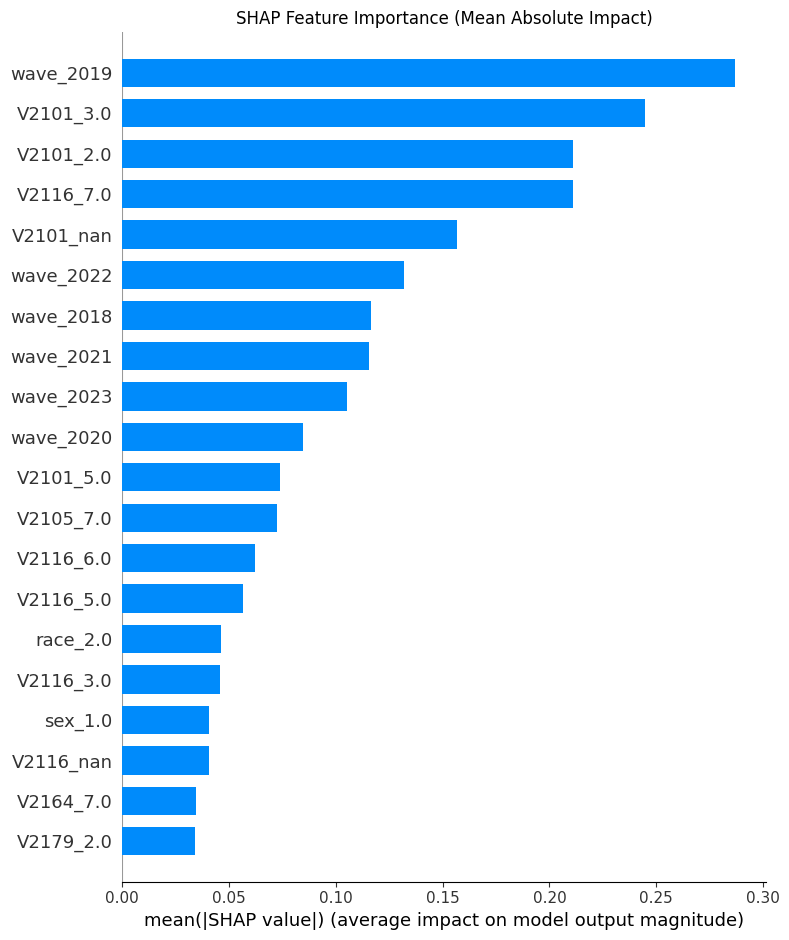

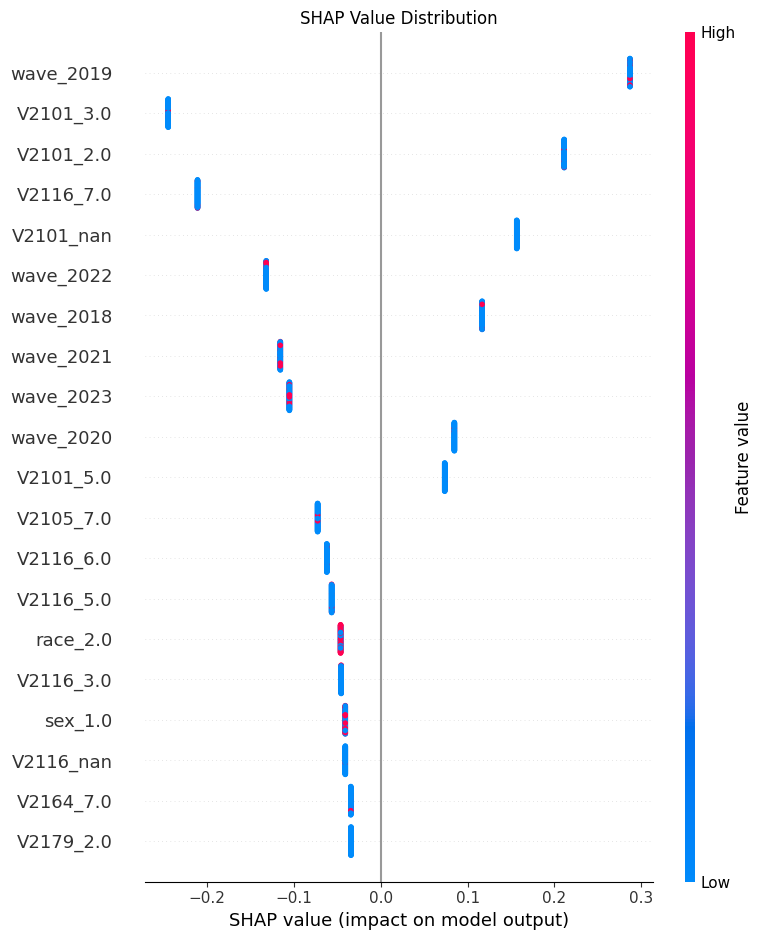

In [14]:
# Summary plot (feature importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, 
                 X_processed[sample_idx], 
                 feature_names=feature_names,
                 plot_type="bar",
                 show=False)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, 
                 X_processed[sample_idx], 
                 feature_names=feature_names,
                 show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

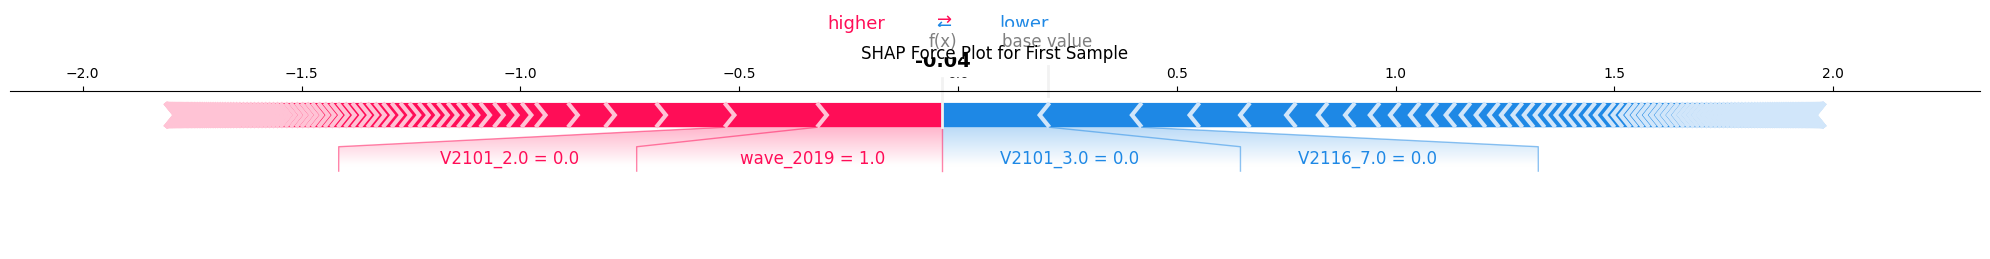

In [15]:
# Force plot for average prediction
plt.figure()
shap.force_plot(explainer.expected_value, 
                shap_values[0], 
                X_processed[0], 
                feature_names=feature_names,
                matplotlib=True,
                show=False)
plt.title("SHAP Force Plot for First Sample")
plt.tight_layout()
plt.show()

In [16]:
# Extract original categorical features from one-hot encoded column names
import re

# Get the list of one-hot encoded column names
one_hot_encoded_columns = feature_names.tolist()

# Extract original categorical features by splitting at the first underscore or dot
original_categorical_features = list(set([re.split(r'[_.]', col)[0] for col in one_hot_encoded_columns]))

print("Original Categorical Features:")
print(original_categorical_features)

Original Categorical Features:
['V2188', 'V2163', 'V2116', 'V2134', 'V49', 'sex', 'V2105', 'V2175', 'V2460', 'V2128', 'V2108', 'V2195', 'missing', 'V2181', 'V2183', 'V2140', 'V2143', 'V2193', 'V2197', 'V2153', 'V2101', 'V2186', 'V2166', 'V2178', 'V2157', 'V2156', 'wave', 'V2137', 'V2196', 'V2187', 'V2182', 'V2176', 'V2180', 'V2185', 'V2125', 'V2171', 'RESPONDENT', 'V13', 'V2201', 'V2189', 'V2152', 'V2177', 'V2164', 'race', 'V2155', 'V2179', 'V2194', 'V2184', 'V2191', 'V2173', 'V2172']


Top 20 Aggregated SHAP Features:
   Feature  Aggregated_SHAP
58    wave         0.840751
57   V2101         0.704158
42   V2116         0.459052
11   V2105         0.208962
24   V2164         0.107361
10   V2128         0.087983
55   V2179         0.085944
45   V2166         0.083725
29   V2152         0.074671
56   V2193         0.068521
12   V2175         0.061661
34   V2108         0.056134
30   V2176         0.055857
28     V13         0.054423
18   V2184         0.054002
17   V2143         0.049636
20    race         0.049562
41   V2195         0.048198
33   V2173         0.047251
36   V2177         0.045113


/tmp/ipykernel_1702033/2393572530.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aggregated_SHAP', y='Feature', data=aggregated_shap_df.head(top_n), palette='viridis')


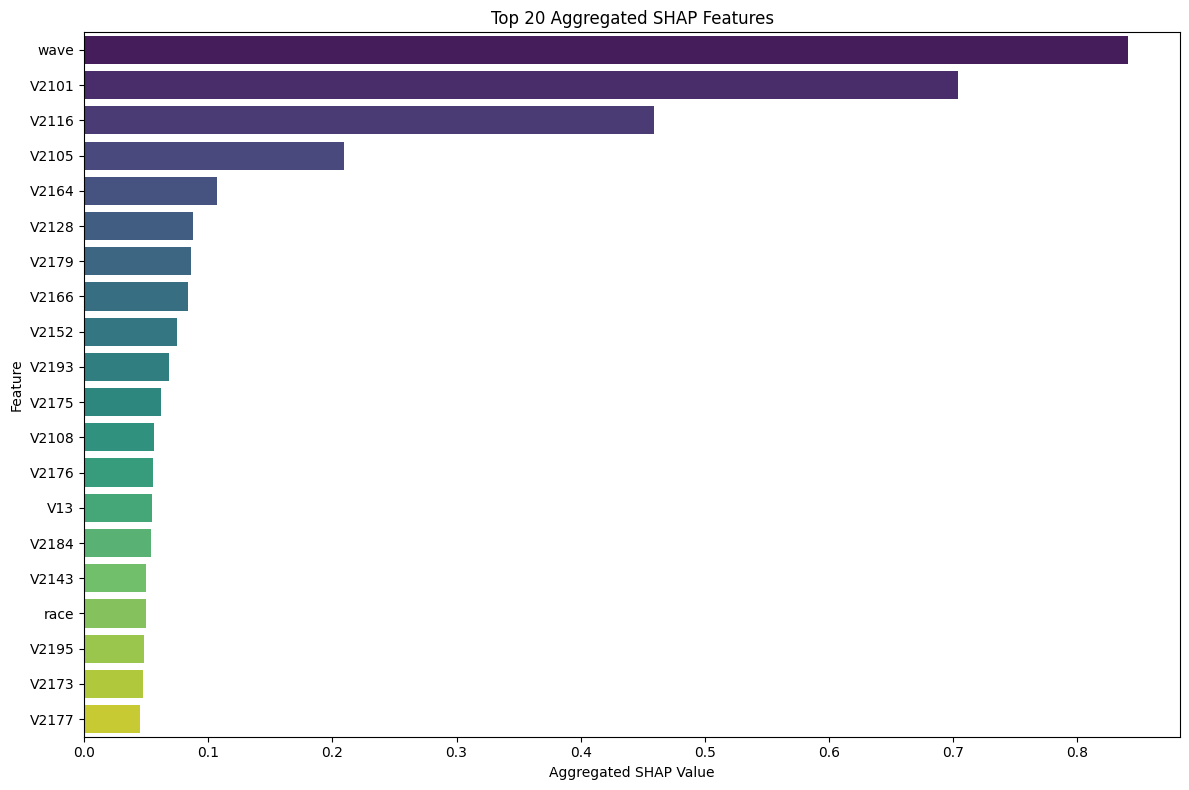

In [17]:
# List of original categorical features
original_categorical_features = [
    'V2137', 'V2172', 'V2181', 'V2178', 'V2134', 'V2163', 'V2197', 'V2188', 'V2191', 'V2155', 
    'V2128', 'V2105', 'V2175', 'V2185', 'V2153', 'V2194', 'V2183', 'V2143', 'V2184', 'V2460', 
    'race', 'V2907', 'V2494', 'RESPONDENT', 'V2164', 'V2146', 'V49', 'V2182', 'V13', 'V2152', 
    'V2176', 'V2196', 'V2187', 'V2173', 'V2108', 'V2033', 'V2177', 'V2030', 'V2171', 'V2119', 
    'V2908', 'V2195', 'V2116', 'V2180', 'V2186', 'V2166', 'V2140', 'V2156', 'V2189', 'V2201', 
    'V2169', 'V2122', 'missing', 'sex', 'V2125', 'V2179', 'V2193', 'V2101', 'wave', 'V2157'
]

# Compute mean absolute SHAP values
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a dictionary to map one-hot encoded features to their original features
feature_mapping = {}
for feature in original_categorical_features:
    feature_mapping[feature] = [col for col in feature_names if col.startswith(feature)]

# Aggregate SHAP values for each original feature
aggregated_shap_values = {}
for feature, cols in feature_mapping.items():
    # Find the indices of the one-hot encoded columns for this feature
    indices = [feature_names.tolist().index(col) for col in cols]
    # Sum the mean absolute SHAP values for these columns
    aggregated_shap_values[feature] = np.sum(mean_abs_shap_values[indices])

# Convert the aggregated SHAP values to a DataFrame
aggregated_shap_df = pd.DataFrame({
    'Feature': list(aggregated_shap_values.keys()),
    'Aggregated_SHAP': list(aggregated_shap_values.values())
})

# Sort by aggregated SHAP values in descending order
aggregated_shap_df = aggregated_shap_df.sort_values(by='Aggregated_SHAP', ascending=False)

# Display the top 20 aggregated features
top_n = 20  # Set to 20 for top 20 features
print("Top 20 Aggregated SHAP Features:")
print(aggregated_shap_df.head(top_n))

# Plot the top 20 aggregated features
plt.figure(figsize=(12, 8))
sns.barplot(x='Aggregated_SHAP', y='Feature', data=aggregated_shap_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Aggregated SHAP Features')
plt.xlabel('Aggregated SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [12]:
# Ensure SHAP is installed
import shap
shap.initjs()  # For visualization in notebooks

# Compute SHAP interaction values (using a sample for faster computation)
sample_idx = np.random.choice(X_processed.shape[0], 100, replace=False)  # Use a sample of 100 instances
shap_interaction_values = explainer.shap_interaction_values(X_processed[sample_idx])

# Get feature names from the preprocessor
feature_names = encoded_feature_names  # From your existing code

Top 30 Feature Interactions (Unique Pairs):
    Interaction Value Feature A Feature B
0           94.461174     V2116      wave
1           68.112961     V2105      wave
2           57.410591     V2101      wave
3           29.019850     V2101     V2116
4           24.331301     V2105     V2116
5           21.626293     V2108      wave
6           14.987869     V2101     V2105
7           12.275227     V2108     V2116
8           11.319855     V2164      wave
9           11.317589     V2166      wave
10          11.201500      race      wave
11          11.175924     V2196      wave
12          10.676391     V2163      wave
13          10.323991     V2194      wave
14           9.517755     V2179      wave
15           9.090555     V2152      wave
16           8.913261     V2191      wave
17           8.352642     V2176      wave
18           7.616253     V2101     V2108
19           7.319203     V2116     V2166
20           7.314087       V13      wave
21           6.935249     V2173 

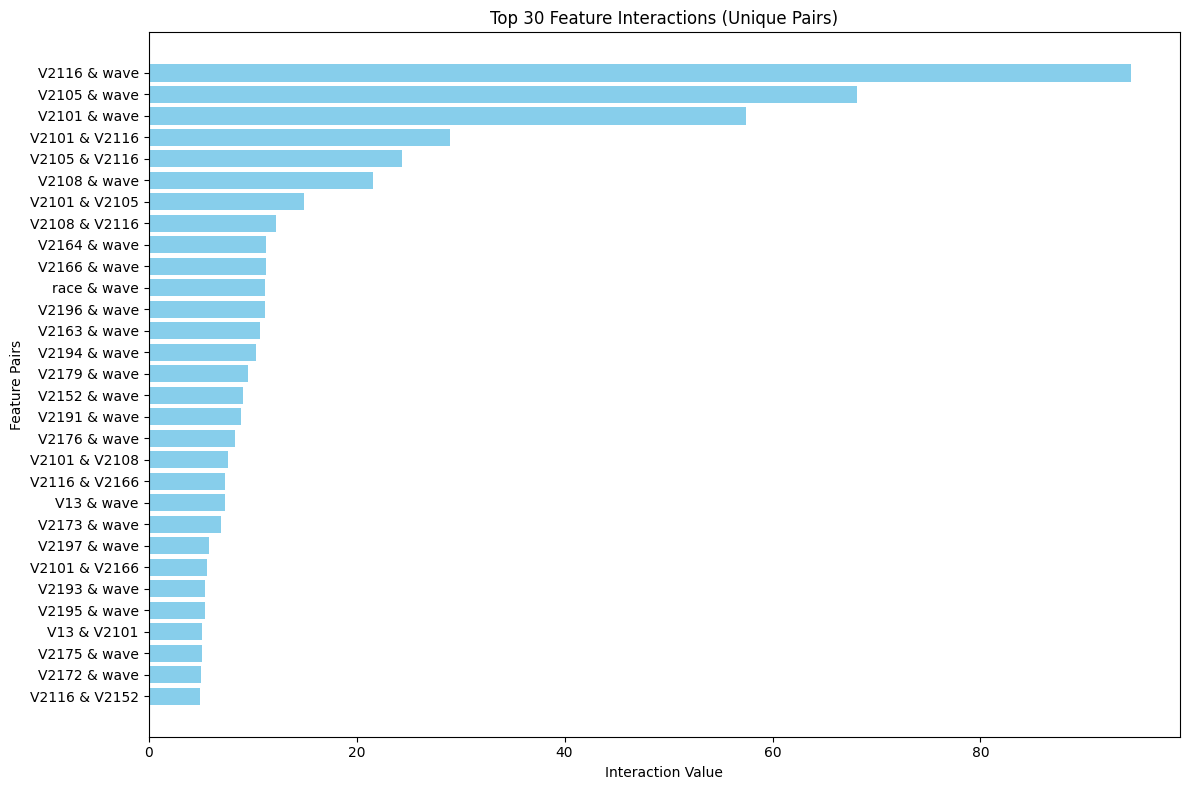

In [19]:
# Step 1: Store interactions and their values, avoiding duplicates and self-interactions
interaction_results = []

for i, feature_i in enumerate(original_categorical_features):
    for j, feature_j in enumerate(original_categorical_features):
        # Skip self-interactions
        if feature_i == feature_j:
            continue

        # Ensure unique pairs by sorting feature names
        feature_pair = tuple(sorted([feature_i, feature_j]))

        # Skip if the pair is already processed
        if feature_pair in [result[0] for result in interaction_results]:
            continue

        # Get indices for feature_i and feature_j
        indices_i = [feature_names.tolist().index(col) for col in feature_mapping[feature_i] if col in feature_names.tolist()]
        indices_j = [feature_names.tolist().index(col) for col in feature_mapping[feature_j] if col in feature_names.tolist()]

        if not indices_i or not indices_j:
            continue

        # Compute interaction value
        value = np.sum(np.abs(shap_interaction_values[:, indices_i, :][:, :, indices_j]))
        interaction_results.append((feature_pair, value))

# Step 2: Sort the interactions by their values
sorted_interactions = sorted(interaction_results, key=lambda x: x[1], reverse=True)

# Step 3: Convert results to a DataFrame for easy aggregation
interaction_df = pd.DataFrame(sorted_interactions, columns=["Feature Pair", "Interaction Value"])
interaction_df[["Feature A", "Feature B"]] = pd.DataFrame(interaction_df["Feature Pair"].tolist(), index=interaction_df.index)
interaction_df = interaction_df.drop(columns=["Feature Pair"])

# Step 4: Select the top 30 interactions
top_30_interactions = interaction_df.sort_values(by="Interaction Value", ascending=False).head(30)

# Step 5: Display the results
print("Top 30 Feature Interactions (Unique Pairs):")
print(top_30_interactions)

# Step 6: Visualize the top 30 interactions
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(
    top_30_interactions.apply(lambda row: f"{row['Feature A']} & {row['Feature B']}", axis=1),
    top_30_interactions["Interaction Value"],
    color="skyblue",
)
plt.xlabel("Interaction Value")
plt.ylabel("Feature Pairs")
plt.title("Top 30 Feature Interactions (Unique Pairs)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


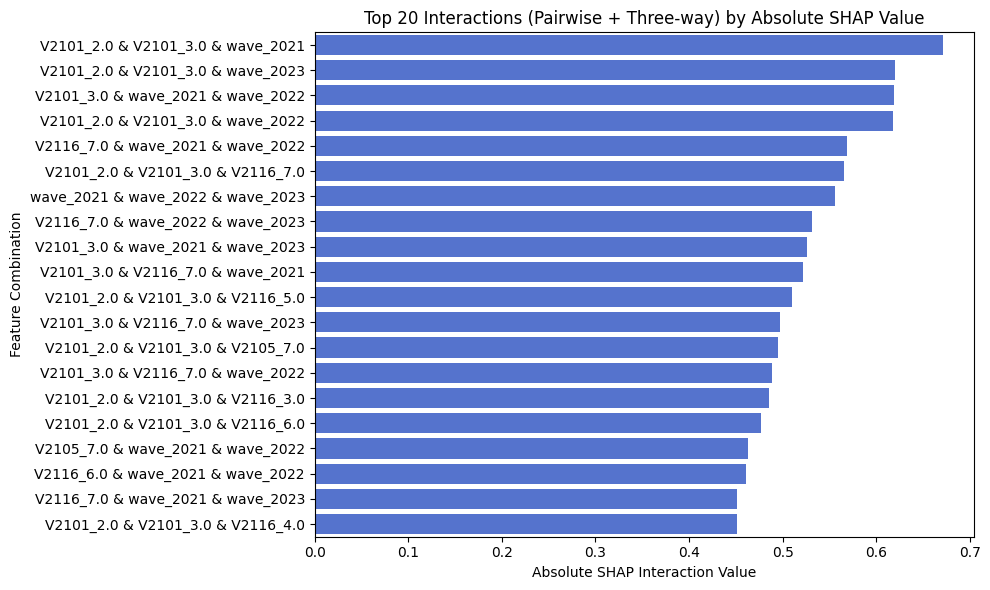

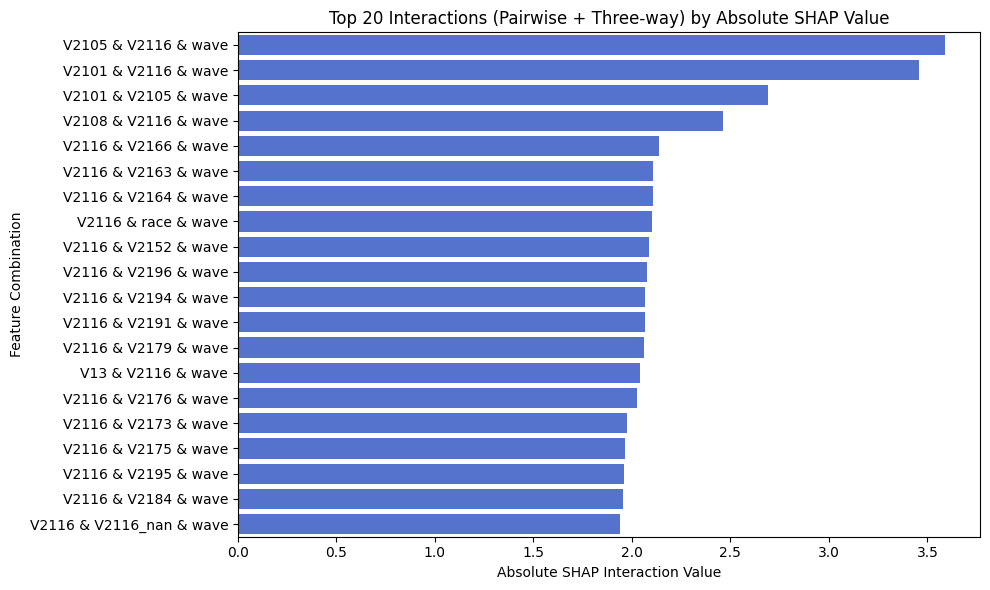

In [16]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

##############################
# 1. Pairwise Aggregation
##############################
def aggregate_shap_interactions_pairwise(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features,
    and returns a DataFrame of the mean absolute interaction for each (Feature1, Feature2).
    """
    # shap_interaction_values: [n_samples, n_features, n_features]
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) Accumulate pairwise interactions
    #    We'll sum interactions for each pair (bf_i, bf_j)
    #    Because i<j is symmetric in the shap_interaction_values, we avoid double counting.
    aggregated = {}
    for bf_i in unique_base_features:
        aggregated[bf_i] = {}
        for bf_j in unique_base_features:
            aggregated[bf_i][bf_j] = 0.0

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated[bf_i][bf_j] += interaction_matrix[i, j]
            # You could also decide to add symmetrical entries if desired:
            aggregated[bf_j][bf_i] += interaction_matrix[i, j]  # for simpler referencing

    # 4) Convert to a long DataFrame
    records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # Avoid i == j and only keep i < j in the final output (unique pairs)
            if bf_i < bf_j:
                val = aggregated[bf_i][bf_j]
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "InteractionValue": val,
                    "AbsInteraction": abs(val),
                    "Order": 2  # Mark as pairwise
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

##############################
# 2. "Three-way" Aggregation
##############################
def aggregate_shap_interactions_three_way(shap_interaction_values, feature_names, get_base_feature):
    """
    Naively computes a 'three-way' measure by summing the absolute pairwise interactions
    (i,j), (i,k), and (j,k) for each triple i < j < k.

    NOTE: This does not represent a true SHAP 3-way synergy. It's a proxy 
    by combining the pairwise interactions among the triple.
    """
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) We will group by base features for i,j,k. Because different OHE columns might map
    #    to the same base feature, let's gather all indices that map to each base feature.
    feature_indices_by_base = {}
    for idx, bf in enumerate(base_feature_names):
        if bf not in feature_indices_by_base:
            feature_indices_by_base[bf] = []
        feature_indices_by_base[bf].append(idx)

    # 4) For each triple (bf_i, bf_j, bf_k) with i < j < k, compute sum of pairwise interactions
    records = []
    bf_list = list(unique_base_features)
    n_bf = len(bf_list)

    for i in range(n_bf):
        for j in range(i + 1, n_bf):
            for k in range(j + 1, n_bf):
                bf_i, bf_j, bf_k = bf_list[i], bf_list[j], bf_list[k]

                # For all actual columns that map to bf_i, bf_j, bf_k, sum the relevant pairwise interactions:
                indices_i = feature_indices_by_base[bf_i]
                indices_j = feature_indices_by_base[bf_j]
                indices_k = feature_indices_by_base[bf_k]

                # We'll sum the absolute interaction_matrix across all pairs (i', j'), (i', k'), (j', k')
                total_interaction = 0.0
                for ii in indices_i:
                    for jj in indices_j:
                        total_interaction += interaction_matrix[ii, jj]
                        total_interaction += interaction_matrix[jj, ii]  # symmetrical

                    for kk in indices_k:
                        total_interaction += interaction_matrix[ii, kk]
                        total_interaction += interaction_matrix[kk, ii]

                for jj in indices_j:
                    for kk in indices_k:
                        total_interaction += interaction_matrix[jj, kk]
                        total_interaction += interaction_matrix[kk, jj]

                # We'll keep it as the approximate measure
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j} & {bf_k}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "Feature3": bf_k,
                    "InteractionValue": total_interaction,
                    "AbsInteraction": abs(total_interaction),
                    "Order": 3  # Mark as three-way
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


##############################
# 3. Putting it all together
##############################

# Suppose you already have:
#   shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)
#   feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()
#   We'll reuse your simple_get_base_feature function:
import re

def simple_get_base_feature(name):
    """
    Strips off numerical one-hot encoding suffixes (e.g., 'wave_2021' → 'wave').
    """
    # Remove 'num__' or 'cat__' prefix if present
    if name.startswith("num__"):
        name = name[len("num__"):]
    if name.startswith("cat__"):
        name = name[len("cat__"):]

    # Remove one-hot encoding suffix (_YYYY or _X.X for categorical variables)
    name = re.sub(r"_\d+(\.\d+)?$", "", name)  # Removes _2021, _2.0, etc.

    return name

# -- 3.1 Compute pairwise and "three-way" aggregates --
df_pairwise = aggregate_shap_interactions_pairwise(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

df_three_way = aggregate_shap_interactions_three_way(
    shap_interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

# -- 3.2 Combine them into one table --
#    For consistency, we can unify the column names
df_pairwise["Feature3"] = None  # no third feature for pairs
combined_df = pd.concat([df_pairwise, df_three_way], ignore_index=True)

# Sort by absolute interaction
combined_df.sort_values("AbsInteraction", ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# -- 3.3 Pick top 20 overall --
df_top_20 = combined_df.head(20).copy()

# For a nicer label that works for both pairwise and triple combos:
df_top_20["Label"] = df_top_20["FeatureCombo"]

# -- 3.4 Plot a bar chart of the top 20 combos --
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_20, y="Label", x="AbsInteraction", color="royalblue")
plt.title("Top 20 Interactions (Pairwise + Three-way) by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

# You now have a bar plot of the top 20 interactions (including both 2- and 3-feature combos).


In [17]:
df_top_20

FeatureCombo Feature1   Feature2  InteractionValue  \
0       V2105 & V2116 & wave    V2105      V2116          3.587579   
1       V2101 & V2116 & wave    V2101      V2116          3.458103   
2       V2101 & V2105 & wave    V2101      V2105          2.692748   
3       V2108 & V2116 & wave    V2108      V2116          2.459937   
4       V2116 & V2166 & wave    V2116      V2166          2.137924   
5       V2116 & V2163 & wave    V2116      V2163          2.107955   
6       V2116 & V2164 & wave    V2116      V2164          2.105725   
7        V2116 & race & wave    V2116       race          2.101741   
8       V2116 & V2152 & wave    V2116      V2152          2.086793   
9       V2116 & V2196 & wave    V2116      V2196          2.076759   
10      V2116 & V2194 & wave    V2116      V2194          2.065137   
11      V2116 & V2191 & wave    V2116      V2191          2.065007   
12      V2116 & V2179 & wave    V2116      V2179          2.061879   
13        V13 & V2116 & wave      V13      V2116          2.042954   
14      V2116 & V2176 & wave    V2116      V2176          2.025205   
15      V2116 & V2173 & wave    V2116      V2173          1.976396   
16      V2116 & V2175 & wave    V2116      V2175          1.964295   
17      V2116 & V2195 & wave    V2116      V2195          1.958421   
18      V2116 & V2184 & wave    V2116      V2184          1.954090   
19  V2116 & V2116_nan & wave    V2116  V2116_nan          1.939227   

    AbsInteraction  Order Feature3                     Label  
0         3.587579      3     wave      V2105 & V2116 & wave  
1         3.458103      3     wave      V2101 & V2116 & wave  
2         2.692748      3     wave      V2101 & V2105 & wave  
3         2.459937      3     wave      V2108 & V2116 & wave  
4         2.137924      3     wave      V2116 & V2166 & wave  
5         2.107955      3     wave      V2116 & V2163 & wave  
6         2.105725      3     wave      V2116 & V2164 & wave  
7         2.101741      3     wave       V2116 & race & wave  
8         2.086793      3     wave      V2116 & V2152 & wave  
9         2.076759      3     wave      V2116 & V2196 & wave  
10        2.065137      3     wave      V2116 & V2194 & wave  
11        2.065007      3     wave      V2116 & V2191 & wave  
12        2.061879      3     wave      V2116 & V2179 & wave  
13        2.042954      3     wave        V13 & V2116 & wave  
14        2.025205      3     wave      V2116 & V2176 & wave  
15        1.976396      3     wave      V2116 & V2173 & wave  
16        1.964295      3     wave      V2116 & V2175 & wave  
17        1.958421      3     wave      V2116 & V2195 & wave  
18        1.954090      3     wave      V2116 & V2184 & wave  
19        1.939227      3     wave  V2116 & V2116_nan & wave

## CatBoost

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-02-15 09:46:30,631 - INFO - Best parameters found: {'classifier__bagging_temperature': 0.45924889196586716, 'classifier__border_count': 148, 'classifier__depth': 7, 'classifier__iterations': 3919, 'classifier__l2_leaf_reg': 7.090725777960454, 'classifier__learning_rate': 0.016175348288740735, 'classifier__od_type': 'Iter', 'classifier__od_wait': 33, 'classifier__random_strength': 8.324426409004218}
2025-02-15 09:46:30,633 - INFO - Best cross-validation roc_auc: 0.9065
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn

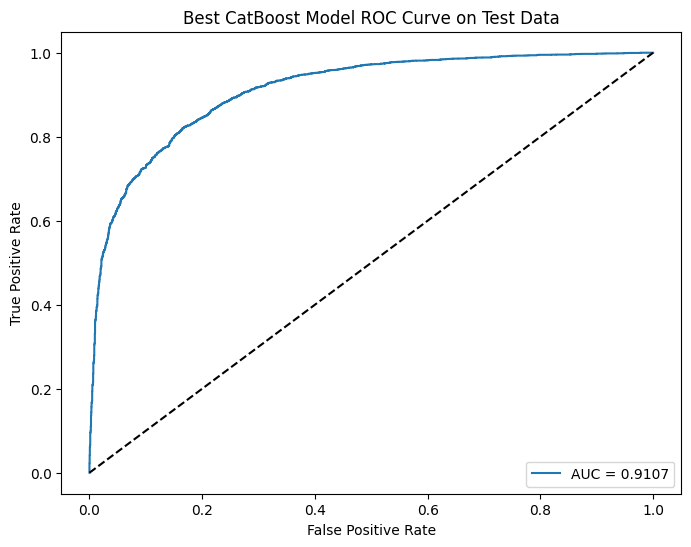

2025-02-15 09:46:31,706 - INFO - Best CatBoost model saved to 'best_catboost_model.pkl'.


In [6]:
import os
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint

# Create a pipeline with the preprocessor and CatBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations= 500,  # Increase the number of iterations if needed
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        verbose=0,
        random_seed=RANDOM_STATE
    ))
])

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'classifier__iterations': randint(1000, 5000),  # Wider range for iterations
    'classifier__learning_rate': uniform(0.01, 0.3),  # Wider range for learning rate
    'classifier__depth': randint(4, 12),  # Wider range for depth
    'classifier__l2_leaf_reg': uniform(1e-2, 10),  # L2 regularization
    'classifier__border_count': randint(32, 255),  # Border count
    'classifier__bagging_temperature': uniform(0, 1),  # Bagging temperature
    'classifier__random_strength': uniform(1e-9, 10),  # Random strength
    'classifier__od_type': ['IncToDec', 'Iter'],  # Overfitting detector type
    'classifier__od_wait': randint(10, 50)  # Overfitting detector wait
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Increase the number of parameter settings sampled if needed
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC,
    n_jobs=CPU_COUNT,
    verbose=VERBOSE,
    random_state=RANDOM_STATE
)

random_search.fit(X_train_with_indicators, y_train)

# Log the best parameters and score
logging.info("Best parameters found: " + str(random_search.best_params_))
logging.info(f"Best cross-validation {SCORING_METRIC}: {random_search.best_score_:.4f}")

# Evaluate the best model
best_model = random_search.best_estimator_

# Transform the data using the fitted preprocessor in the best model
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train_with_indicators)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test_with_indicators)

# Predict and evaluate
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]

logging.info("=== Best CatBoost Model Evaluation ===")
logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))
logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best CatBoost Model ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

# Save the best model
model_save_path = 'best_catboost_model.pkl'
joblib.dump(best_model, model_save_path)
logging.info(f"Best CatBoost model saved to '{model_save_path}'.")

In [7]:
model_filename = os.path.expanduser('~/work/vaping_project_data/best_cb_model.joblib')
joblib.dump(best_model, model_filename)
logging.info(f"Final CatBoost model saved to: {model_filename}")

2025-02-15 09:49:03,429 - INFO - Final CatBoost model saved to: /storage/home/szn5432/work/vaping_project_data/best_cb_model.joblib


In [6]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_cb_model.joblib')
loaded_cb = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


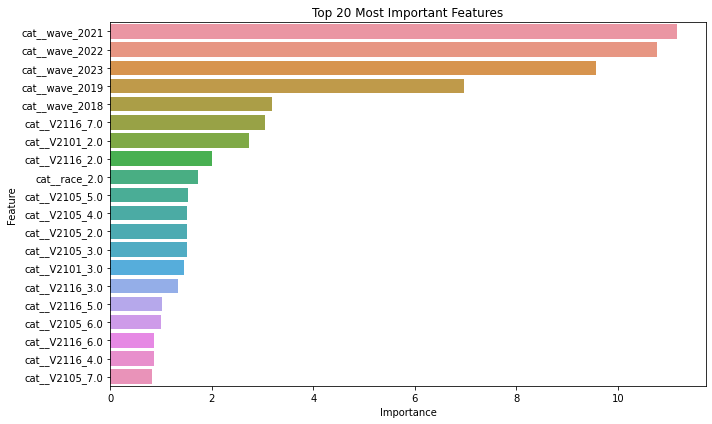

In [7]:
# Function to plot feature importances
def plot_feature_importance(loaded_cb, feature_names, top_n=20, title="Feature Importance"):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(loaded_cb, 'feature_importances_'):
        importances = loaded_cb.feature_importances_
    elif hasattr(loaded_cb, 'named_steps') and 'classifier' in loaded_cb.named_steps:
        if hasattr(loaded_cb.named_steps['classifier'], 'feature_importances_'):
            importances = loaded_cb.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")

    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get the feature names from the preprocessor
feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()

# Plot the top 20 most important features
plot_feature_importance(loaded_cb, feature_names, top_n=20, title="Top 20 Most Important Features")

    Feature  Importance
11     wave   42.470199
15    V2116    9.260863
42    V2105    8.033713
27    V2101    4.949176
19     race    1.935681
33    V2196    1.747739
47    V2152    1.724427
30    V2191    1.668882
35    V2179    1.661493
26    V2108    1.660298
10    V2166    1.517221
9     V2194    1.475027
31    V2195    1.290147
29    V2164    1.251019
24    V2163    1.245204
8     V2173    1.231446
36      V13    1.204014
50  missing    1.120715
12    V2176    0.973473
3     V2184    0.958860


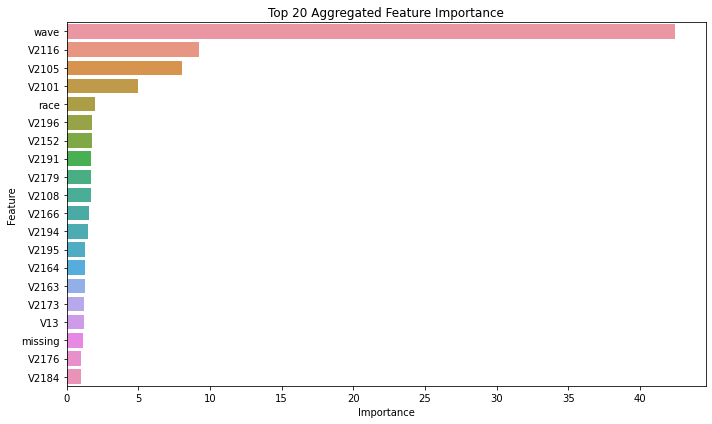

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_aggregated_feature_importance(model, top_n=20, title="Top 20 Aggregated Feature Importance"):
    """
    Plots the top N aggregated feature importances for a CatBoost model
    that is wrapped inside a Pipeline with a ColumnTransformer.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline that includes:
          - 'preprocessor': a ColumnTransformer or other transformer
          - 'classifier': a CatBoostClassifier
    top_n : int, optional (default=20)
        How many top aggregated features to display.
    title : str, optional
        Title of the plot.
    """
    # 1. Get the feature names after the preprocessor step
    feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Get the feature importances from CatBoost
    catboost_estimator = loaded_cb.named_steps['classifier']
    if not hasattr(catboost_estimator, 'feature_importances_'):
        raise AttributeError("The CatBoost classifier does not expose 'feature_importances_'.")

    importances = catboost_estimator.feature_importances_

    # 3. Aggregate importances by original feature
    aggregated_importance = {}
    
    for name, imp in zip(feature_names, importances):
        # Example naming conventions after ColumnTransformer + OneHotEncoder:
        #   "onehotencoder__Gender_Male"
        #   "remainder__Age"
        # Adjust this parsing logic as necessary for your pipeline.
        
        if "__" in name:
            # Split on the double underscore to separate the transformer name vs. the actual column
            parts = name.split("__", maxsplit=1)
            # parts[0] might be 'onehotencoder' or 'remainder'
            # parts[1] might be 'Gender_Male' or 'Age'
            # We'll then split again on '_' if needed to get just the original column name
            col_part = parts[1]
            
            # If the column was numeric (remainder), it may be simply 'Age'.
            # If the column was OHE, it might be 'Gender_Male' or 'Gender_Female'.
            # A simple approach is to take everything before the first underscore as the feature name:
            if "_" in col_part:
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                original_feature = col_part
        else:
            # If there's no double underscore, assume the whole name is the feature
            original_feature = name
        
        # Sum up the importances
        aggregated_importance[original_feature] = aggregated_importance.get(original_feature, 0.0) + imp

    # 4. Make a DataFrame of aggregated importances and sort
    agg_df = pd.DataFrame(list(aggregated_importance.items()), columns=["Feature", "Importance"])
    agg_df = agg_df.sort_values("Importance", ascending=False)

    print(agg_df.head(20))

    # 5. Plot top N aggregated feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=agg_df.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- Usage Example ---
# Assuming you have your best_model pipeline (with 'preprocessor' and CatBoost 'classifier'):

plot_aggregated_feature_importance(loaded_cb, top_n=20, title="Top 20 Aggregated Feature Importance")


Top 10 aggregated features:
 ['wave', 'V2116', 'V2105', 'V2101', 'race', 'V2196', 'V2152', 'V2191', 'V2179', 'V2108']


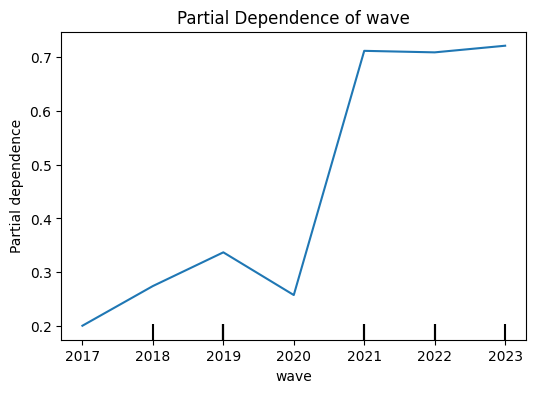

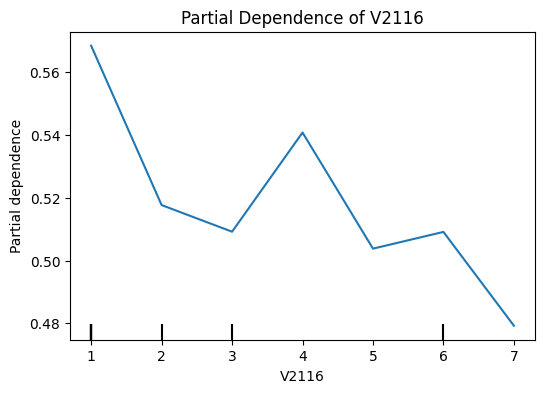

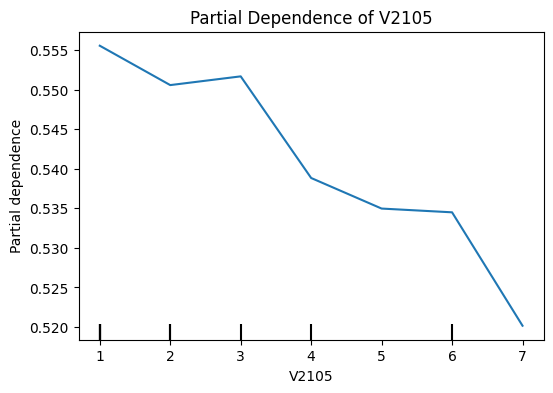

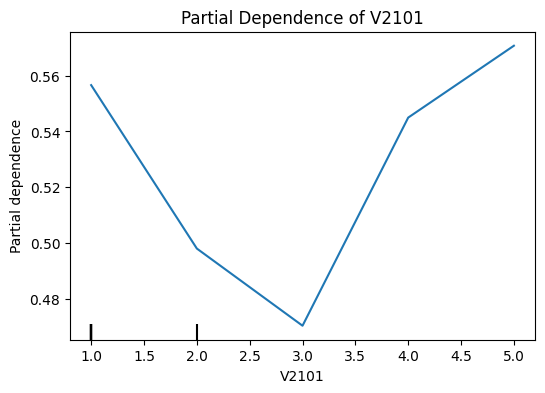

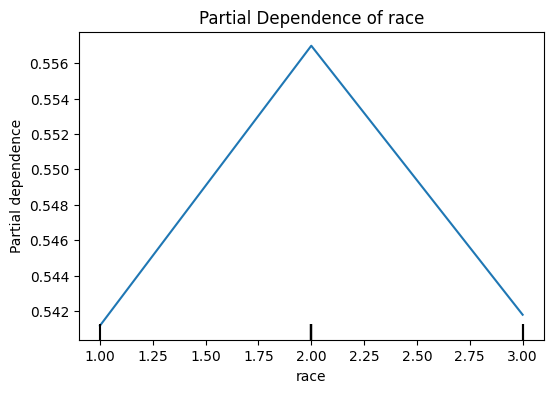

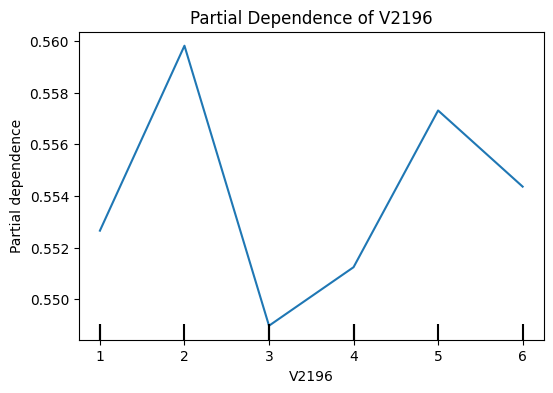

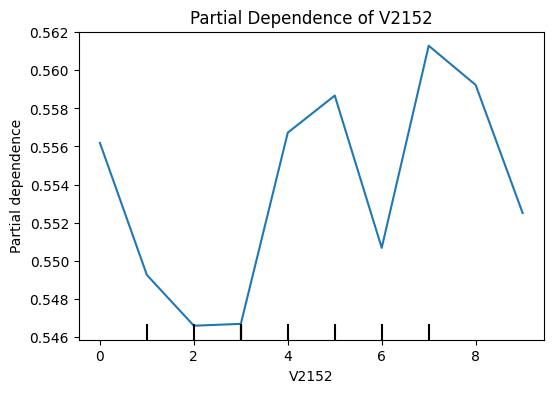

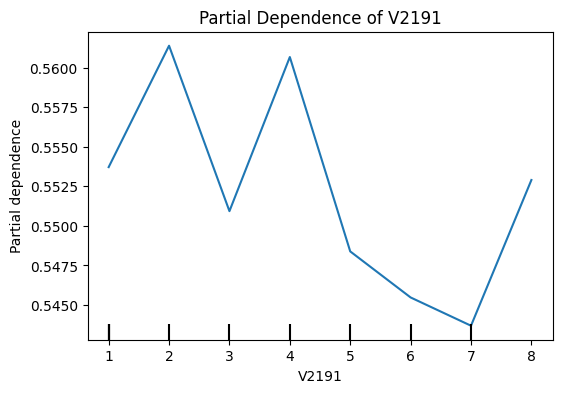

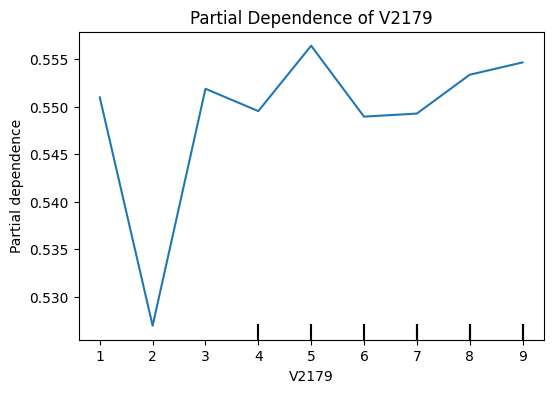

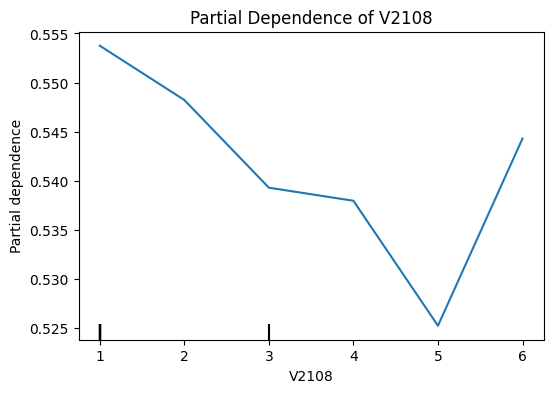

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


def get_top_aggregated_features(loaded_cb, top_n=10):
    """
    Returns a list of top_n original (aggregated) feature names
    based on the CatBoost feature importances in a Pipeline.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline with steps:
          - "preprocessor" : ColumnTransformer (or similar)
          - "classifier" : CatBoostClassifier
    top_n : int
        Number of top features to return
        
    Returns
    -------
    list of str
        Top N aggregated feature names
    """
    # Extract feature names that come out of the preprocessor
    feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()
    
    # Extract importances from CatBoost
    catboost_estimator = loaded_cb.named_steps['classifier']
    importances = catboost_estimator.feature_importances_

    # Aggregate importances by the original (pre-encoding) feature name
    aggregated_importance = {}
    for name, imp in zip(feature_names, importances):
        if "__" in name:
            # Example: "onehotencoder__Gender_Male" -> original_feature = "Gender"
            parts = name.split("__", maxsplit=1)
            col_part = parts[1]
            if "_" in col_part: 
                # For OHE columns like "Gender_Male"
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                # For remainder numeric columns
                original_feature = col_part
        else:
            # If no __, assume name is the feature
            original_feature = name
        
        aggregated_importance[original_feature] = (
            aggregated_importance.get(original_feature, 0.0) + imp
        )

    # Turn into a DataFrame, sort, and get top_n
    agg_df = pd.DataFrame(
        list(aggregated_importance.items()), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    return agg_df.head(top_n)["Feature"].tolist()

# 1. Get the top 10 features by aggregated importance
top_features = get_top_aggregated_features(loaded_cb, top_n=10)
print("Top 10 aggregated features:\n", top_features)

# Plot the partial dependence plot
for feat in top_features:
    if feat not in X_train_with_indicators.columns:
        print(f"Skipping feature '{feat}' as it is not found in the DataFrame.")
        continue

    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        estimator=loaded_cb,
        X=X_train_with_indicators,
        features=[feat],
        kind='average',
        grid_resolution=50,
        target=1,  # positive class for binary classification
        ax=ax
    )
    plt.title(f"Partial Dependence of {feat}")
    plt.show()




    Feature  SHAP Importance
11     wave         2.362931
42    V2105         0.379803
15    V2116         0.376451
27    V2101         0.190879
19     race         0.119995
18      sex         0.115159
10    V2166         0.103096
47    V2152         0.089604
33    V2196         0.083192
35    V2179         0.077603
30    V2191         0.075586
3     V2184         0.074585
29    V2164         0.070858
9     V2194         0.069394
36      V13         0.068180
50  missing         0.065523
26    V2108         0.058134
31    V2195         0.055234
8     V2173         0.054151
14    V2177         0.048123


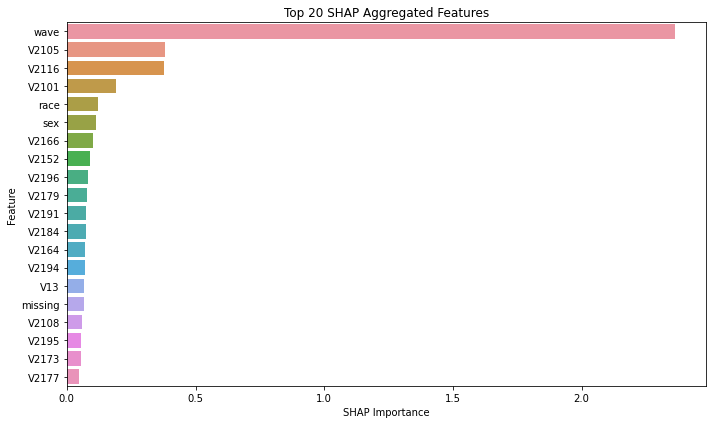

In [9]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train_transformed = loaded_cb.named_steps['preprocessor'].transform(X_train_with_indicators)


def plot_top_shap_aggregated_features(model, X_train_transformed, feature_names, top_n=20, title="Top 20 SHAP Aggregated Features"):
    """
    Plots the top N aggregated SHAP feature importances for a model.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline that includes:
          - 'preprocessor': a ColumnTransformer or other transformer
          - 'classifier': a CatBoostClassifier
    X_train_transformed : array-like
        Transformed training data (output of the preprocessor).
    feature_names : array-like
        Feature names after transformation.
    top_n : int, optional (default=20)
        How many top aggregated features to display.
    title : str, optional
        Title of the plot.
    """
    # 1. Extract the classifier from the pipeline
    catboost_estimator = loaded_cb.named_steps['classifier']
    
    # 2. Initialize SHAP explainer for the CatBoost model
    explainer = shap.TreeExplainer(catboost_estimator)
    
    # 3. Compute SHAP values for the transformed training data
    shap_values = explainer.shap_values(X_train_transformed)

    # For classification problems, shap_values is a list (one element per class).
    # We use the positive class for binary classification (index 1).
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # 4. Aggregate SHAP values back to the original feature names
    aggregated_shap = {}
    for i, name in enumerate(feature_names):
        # Parse original feature name from encoded feature name
        if "__" in name:
            col_part = name.split("__", maxsplit=1)[1]  # Split after the double underscore
            if "_" in col_part:
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                original_feature = col_part
        else:
            original_feature = name

        # Sum SHAP values for the same original feature
        aggregated_shap[original_feature] = aggregated_shap.get(original_feature, 0.0) + abs(shap_values[:, i]).mean()
    
    # 5. Create a DataFrame of aggregated SHAP values and sort by importance
    shap_df = pd.DataFrame(list(aggregated_shap.items()), columns=["Feature", "SHAP Importance"])
    shap_df = shap_df.sort_values("SHAP Importance", ascending=False)

    print(shap_df.head(20))

    # 6. Plot the top N SHAP aggregated feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x="SHAP Importance", y="Feature", data=shap_df.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- Usage Example ---
# Assuming you have:
# - 'best_model': your fitted pipeline
# - 'X_train_transformed': the transformed training data
# - 'feature_names': the output of 'get_feature_names_out()' from the preprocessor

plot_top_shap_aggregated_features(
     model=loaded_cb,
     X_train_transformed=X_train_transformed,
     feature_names=loaded_cb.named_steps['preprocessor'].get_feature_names_out(),
     top_n=20,
     title="Top 20 SHAP Aggregated Features"
)


In [10]:
###################################
# SHAP Interactions
###################################

import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Extract the classifier from the pipeline ---
catboost_estimator = loaded_cb.named_steps['classifier']

# --- Step 2: Initialize SHAP explainer ---
explainer = shap.TreeExplainer(catboost_estimator)

In [ ]:
# Sample a subset of the training data
sample_size = 300  # Adjust based on available memory and dataset size
X_train_sample = X_train_with_indicators.sample(n=sample_size, random_state=42)

# Transform the sampled data
X_train_sample_transformed = loaded_cb.named_steps['preprocessor'].transform(X_train_sample)

# Compute SHAP interaction values for the sample
interaction_values = explainer.shap_interaction_values(X_train_sample_transformed)

In [14]:
# Save interaction values to a .npy file
np.save('catboost_shap_interaction_values.npy', interaction_values)

# To load it later:
# loaded_interaction_values = np.load('shap_interaction_values.npy')

In [12]:
import numpy as np
import pandas as pd

# List of original categorical features
original_categorical_features = [
    'V2137', 'V2172', 'V2181', 'V2178', 'V2134', 'V2163', 'V2197', 'V2188', 'V2191', 'V2155', 
    'V2128', 'V2105', 'V2175', 'V2185', 'V2153', 'V2194', 'V2183', 'V2143', 'V2184', 'V2460', 
    'race', 'V2907', 'V2494', 'RESPONDENT', 'V2164', 'V2146', 'V49', 'V2182', 'V13', 'V2152', 
    'V2176', 'V2196', 'V2187', 'V2173', 'V2108', 'V2033', 'V2177', 'V2030', 'V2171', 'V2119', 
    'V2908', 'V2195', 'V2116', 'V2180', 'V2186', 'V2166', 'V2140', 'V2156', 'V2189', 'V2201', 
    'V2169', 'V2122', 'missing', 'sex', 'V2125', 'V2179', 'V2193', 'V2101', 'wave', 'V2157'
]

# Get the feature names from your fitted pipeline
feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()

# Inspect them to see how they're named
print("Transformed feature names:\n", feature_names)

# A helper function to check if a transformed column belongs to a given original feature
def belongs_to_original(col_name: str, original_feat: str) -> bool:
    parts = col_name.split("__", maxsplit=1)
    if len(parts) == 2:
        encoded_part = parts[1]  # e.g. "V2137_0"
    else:
        encoded_part = parts[0]
    return (encoded_part == original_feat) or encoded_part.startswith(original_feat + "_")

# Create a dictionary to map each original categorical feature to its transformed columns
feature_mapping = {}
for feature in original_categorical_features:
    matched_cols = [
        col for col in feature_names 
        if belongs_to_original(col, feature)
    ]
    feature_mapping[feature] = matched_cols

# Now do your SHAP interaction aggregation
aggregated_interaction_matrix = np.zeros((len(original_categorical_features), len(original_categorical_features)))

for i, feature_i in enumerate(original_categorical_features):
    for j, feature_j in enumerate(original_categorical_features):
        indices_i = [feature_names.tolist().index(c) for c in feature_mapping[feature_i]]
        indices_j = [feature_names.tolist().index(c) for c in feature_mapping[feature_j]]
        
        # Sum absolute interaction values for these columns
        aggregated_interaction_matrix[i, j] = np.sum(np.abs(interaction_values[:, indices_i, :][:, :, indices_j]))

aggregated_interaction_df = pd.DataFrame(
    aggregated_interaction_matrix,
    index=original_categorical_features,
    columns=original_categorical_features
)

print("Aggregated Interaction DataFrame:\n", aggregated_interaction_df)


Transformed feature names:
 ['cat__V2178_2.0' 'cat__V2178_3.0' 'cat__V2178_4.0' 'cat__V2178_5.0'
 'cat__V2178_6.0' 'cat__V2178_nan' 'cat__V2188_1.0' 'cat__V2188_nan'
 'cat__V2197_1.0' 'cat__V2197_2.0' 'cat__V2197_3.0' 'cat__V2197_4.0'
 'cat__V2197_nan' 'cat__V2184_2.0' 'cat__V2184_3.0' 'cat__V2184_4.0'
 'cat__V2184_nan' 'cat__V2186_1.0' 'cat__V2186_nan' 'cat__V2171_2.0'
 'cat__V2171_6.0' 'cat__V2171_nan' 'cat__V2128_2.0' 'cat__V2128_3.0'
 'cat__V2128_4.0' 'cat__V2128_5.0' 'cat__V2128_6.0' 'cat__V2128_7.0'
 'cat__V2128_nan' 'cat__V2201_1.0' 'cat__V2201_2.0' 'cat__V2201_3.0'
 'cat__V2201_4.0' 'cat__V2201_nan' 'cat__V2173_2.0' 'cat__V2173_3.0'
 'cat__V2173_4.0' 'cat__V2173_5.0' 'cat__V2173_6.0' 'cat__V2173_7.0'
 'cat__V2173_nan' 'cat__V2194_2.0' 'cat__V2194_3.0' 'cat__V2194_4.0'
 'cat__V2194_5.0' 'cat__V2194_6.0' 'cat__V2194_nan' 'cat__V2166_2.0'
 'cat__V2166_3.0' 'cat__V2166_4.0' 'cat__V2166_5.0' 'cat__V2166_6.0'
 'cat__V2166_7.0' 'cat__V2166_8.0' 'cat__V2166_nan' 'cat__wave_2018'
 'cat_

Top 30 Feature Interactions (Excluding Self-Interactions & Duplicates):
Interaction (V2116, wave): 171.6953723941663
Interaction (V2105, wave): 164.22630171791923
Interaction (V2101, wave): 93.08387213523304
Interaction (race, wave): 55.35839971137099
Interaction (V2196, wave): 30.738420661744524
Interaction (V2108, wave): 24.368001964928993
Interaction (V2194, wave): 22.64041475926205
Interaction (V2152, wave): 16.94272941845952
Interaction (V2179, wave): 15.783769283422082
Interaction (V2191, wave): 15.00438230587993
Interaction (V2195, wave): 13.97585954541562
Interaction (V2173, wave): 13.918515863018115
Interaction (V2166, wave): 13.747254005708161
Interaction (V2164, wave): 11.705684801387722
Interaction (V13, wave): 11.62276511841868
Interaction (V2176, wave): 9.905214426866046
Interaction (missing, wave): 9.568631280037593
Interaction (V2197, wave): 9.420352083962843
Interaction (V2201, wave): 8.594517387117856
Interaction (V2184, wave): 8.438909649938672
Interaction (V2163, wa

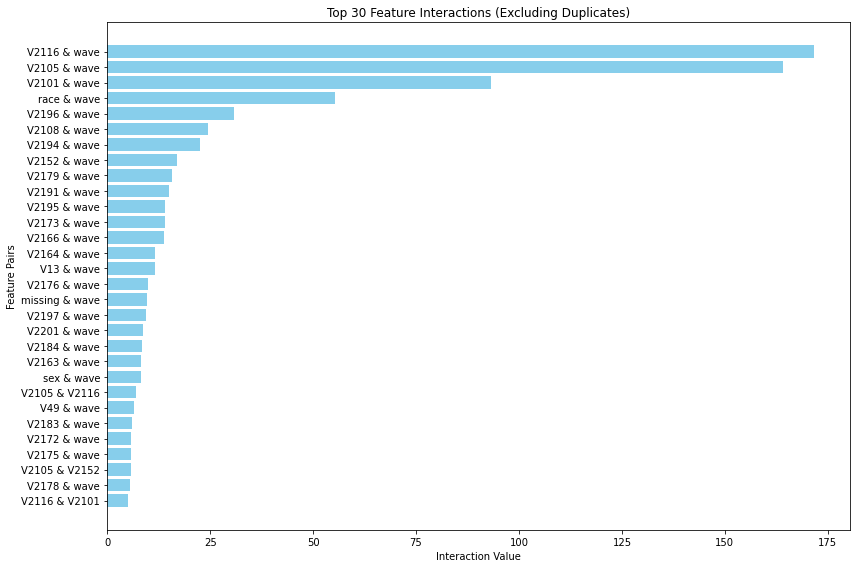

In [13]:
# Step 1: Store interactions and their values, avoiding self-interactions AND duplicates
interaction_results = []

for i, feature_i in enumerate(original_categorical_features):
    # Only loop j from i+1 to end, ensuring j > i
    for j in range(i + 1, len(original_categorical_features)):
        feature_j = original_categorical_features[j]

        # Get indices for feature_i and feature_j
        indices_i = [
            feature_names.tolist().index(col) 
            for col in feature_mapping[feature_i] 
            if col in feature_names.tolist()
        ]
        indices_j = [
            feature_names.tolist().index(col) 
            for col in feature_mapping[feature_j] 
            if col in feature_names.tolist()
        ]

        if not indices_i or not indices_j:
            continue

        # Compute interaction value
        value = np.sum(np.abs(interaction_values[:, indices_i, :][:, :, indices_j]))
        interaction_results.append(((feature_i, feature_j), value))

# Step 2: Sort the interactions by their absolute value (descending)
sorted_interactions = sorted(interaction_results, key=lambda x: x[1], reverse=True)

# Step 3: Select the top 30 interactions
top_30_interactions = sorted_interactions[:30]

# Step 4: Display the results
print("Top 30 Feature Interactions (Excluding Self-Interactions & Duplicates):")
for (feature_pair, interaction_value) in top_30_interactions:
    print(f"Interaction ({feature_pair[0]}, {feature_pair[1]}): {interaction_value}")

# Step 5 (Optional): Visualize the top 30 interactions
import matplotlib.pyplot as plt

# Extract feature pairs and their values
feature_pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in top_30_interactions]
values = [value for _, value in top_30_interactions]

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(feature_pairs, values, color='skyblue')
plt.xlabel('Interaction Value')
plt.ylabel('Feature Pairs')
plt.title('Top 30 Feature Interactions (Excluding Duplicates)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


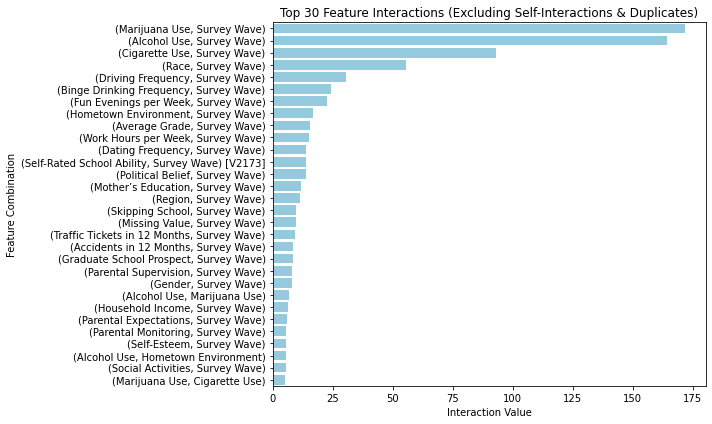

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define data based on the revised table
data = {
    "Feature Combination": [
        "(Marijuana Use, Survey Wave)",
        "(Alcohol Use, Survey Wave)",
        "(Cigarette Use, Survey Wave)",
        "(Race, Survey Wave)",
        "(Driving Frequency, Survey Wave)",
        "(Binge Drinking Frequency, Survey Wave)",
        "(Fun Evenings per Week, Survey Wave)",
        "(Hometown Environment, Survey Wave)",
        "(Average Grade, Survey Wave)",
        "(Work Hours per Week, Survey Wave)",
        "(Dating Frequency, Survey Wave)",
        "(Self-Rated School Ability, Survey Wave) [V2173]",
        "(Political Belief, Survey Wave)",
        "(Mother’s Education, Survey Wave)",
        "(Region, Survey Wave)",
        "(Skipping School, Survey Wave)",
        "(Missing Value, Survey Wave)",
        "(Traffic Tickets in 12 Months, Survey Wave)",
        "(Accidents in 12 Months, Survey Wave)",
        "(Graduate School Prospect, Survey Wave)",
        "(Parental Supervision, Survey Wave)",
        "(Gender, Survey Wave)",
        "(Alcohol Use, Marijuana Use)",
        "(Household Income, Survey Wave)",
        "(Parental Expectations, Survey Wave)",
        "(Parental Monitoring, Survey Wave)",
        "(Self-Esteem, Survey Wave)",
        "(Alcohol Use, Hometown Environment)",
        "(Social Activities, Survey Wave)",
        "(Marijuana Use, Cigarette Use)"
    ],
    "Interaction Value": [
        171.70, 164.23, 93.08, 55.36, 30.74, 24.37, 22.64, 16.94, 15.78, 15.00,
        13.98, 13.92, 13.75, 11.71, 11.62, 9.91, 9.57, 9.42, 8.59, 8.44,
        8.19, 8.14, 6.99, 6.48, 6.09, 5.79, 5.78, 5.72, 5.49, 5.13
    ]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Sort by 'Interaction Value' descending
df = df.sort_values(by="Interaction Value", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Interaction Value",
    y="Feature Combination",
    data=df,
    color="skyblue"
)

plt.title("Top 30 Feature Interactions (Excluding Self-Interactions & Duplicates)")
plt.xlabel("Interaction Value")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()


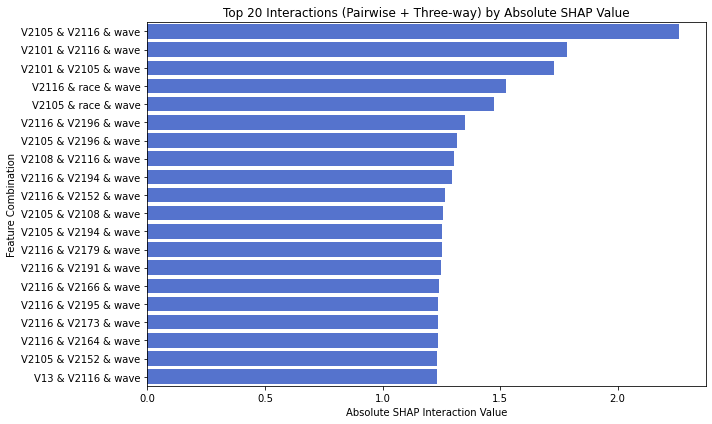

In [17]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

##############################
# 1. Pairwise Aggregation
##############################
def aggregate_shap_interactions_pairwise(interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features,
    and returns a DataFrame of the mean absolute interaction for each (Feature1, Feature2).
    """
    # shap_interaction_values: [n_samples, n_features, n_features]
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) Accumulate pairwise interactions
    #    We'll sum interactions for each pair (bf_i, bf_j)
    #    Because i<j is symmetric in the shap_interaction_values, we avoid double counting.
    aggregated = {}
    for bf_i in unique_base_features:
        aggregated[bf_i] = {}
        for bf_j in unique_base_features:
            aggregated[bf_i][bf_j] = 0.0

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated[bf_i][bf_j] += interaction_matrix[i, j]
            # You could also decide to add symmetrical entries if desired:
            aggregated[bf_j][bf_i] += interaction_matrix[i, j]  # for simpler referencing

    # 4) Convert to a long DataFrame
    records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # Avoid i == j and only keep i < j in the final output (unique pairs)
            if bf_i < bf_j:
                val = aggregated[bf_i][bf_j]
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "InteractionValue": val,
                    "AbsInteraction": abs(val),
                    "Order": 2  # Mark as pairwise
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

##############################
# 2. "Three-way" Aggregation
##############################
def aggregate_shap_interactions_three_way(interaction_values, feature_names, get_base_feature):
    """
    Naively computes a 'three-way' measure by summing the absolute pairwise interactions
    (i,j), (i,k), and (j,k) for each triple i < j < k.

    NOTE: This does not represent a true SHAP 3-way synergy. It's a proxy 
    by combining the pairwise interactions among the triple.
    """
    # 1) Mean of absolute interaction across samples
    interaction_matrix = np.mean(np.abs(interaction_values), axis=0)  # shape: (n_features, n_features)

    # 2) Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(f) for f in feature_names]
    unique_base_features = sorted(set(base_feature_names))

    # 3) We will group by base features for i,j,k. Because different OHE columns might map
    #    to the same base feature, let's gather all indices that map to each base feature.
    feature_indices_by_base = {}
    for idx, bf in enumerate(base_feature_names):
        if bf not in feature_indices_by_base:
            feature_indices_by_base[bf] = []
        feature_indices_by_base[bf].append(idx)

    # 4) For each triple (bf_i, bf_j, bf_k) with i < j < k, compute sum of pairwise interactions
    records = []
    bf_list = list(unique_base_features)
    n_bf = len(bf_list)

    for i in range(n_bf):
        for j in range(i + 1, n_bf):
            for k in range(j + 1, n_bf):
                bf_i, bf_j, bf_k = bf_list[i], bf_list[j], bf_list[k]

                # For all actual columns that map to bf_i, bf_j, bf_k, sum the relevant pairwise interactions:
                indices_i = feature_indices_by_base[bf_i]
                indices_j = feature_indices_by_base[bf_j]
                indices_k = feature_indices_by_base[bf_k]

                # We'll sum the absolute interaction_matrix across all pairs (i', j'), (i', k'), (j', k')
                total_interaction = 0.0
                for ii in indices_i:
                    for jj in indices_j:
                        total_interaction += interaction_matrix[ii, jj]
                        total_interaction += interaction_matrix[jj, ii]  # symmetrical

                    for kk in indices_k:
                        total_interaction += interaction_matrix[ii, kk]
                        total_interaction += interaction_matrix[kk, ii]

                for jj in indices_j:
                    for kk in indices_k:
                        total_interaction += interaction_matrix[jj, kk]
                        total_interaction += interaction_matrix[kk, jj]

                # We'll keep it as the approximate measure
                records.append({
                    "FeatureCombo": f"{bf_i} & {bf_j} & {bf_k}",
                    "Feature1": bf_i,
                    "Feature2": bf_j,
                    "Feature3": bf_k,
                    "InteractionValue": total_interaction,
                    "AbsInteraction": abs(total_interaction),
                    "Order": 3  # Mark as three-way
                })

    df = pd.DataFrame(records)
    df.sort_values("AbsInteraction", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


##############################
# 3. Putting it all together
##############################

# Suppose you already have:
#   shap_interaction_values = explainer.shap_interaction_values(X_preprocessed)
#   feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()
#   We'll reuse your simple_get_base_feature function:
import re

def simple_get_base_feature(name):
    """
    Strips off numerical one-hot encoding suffixes (e.g., 'wave_2021' → 'wave').
    """
    # Remove 'num__' or 'cat__' prefix if present
    if name.startswith("num__"):
        name = name[len("num__"):]
    if name.startswith("cat__"):
        name = name[len("cat__"):]

    # Remove one-hot encoding suffix (_YYYY or _X.X for categorical variables)
    name = re.sub(r"_\d+(\.\d+)?$", "", name)  # Removes _2021, _2.0, etc.

    return name

# -- 3.1 Compute pairwise and "three-way" aggregates --
df_pairwise = aggregate_shap_interactions_pairwise(
    interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

df_three_way = aggregate_shap_interactions_three_way(
    interaction_values, 
    feature_names, 
    get_base_feature=simple_get_base_feature
)

# -- 3.2 Combine them into one table --
#    For consistency, we can unify the column names
df_pairwise["Feature3"] = None  # no third feature for pairs
combined_df = pd.concat([df_pairwise, df_three_way], ignore_index=True)

# Sort by absolute interaction
combined_df.sort_values("AbsInteraction", ascending=False, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# -- 3.3 Pick top 20 overall --
df_top_20 = combined_df.head(20).copy()

# For a nicer label that works for both pairwise and triple combos:
df_top_20["Label"] = df_top_20["FeatureCombo"]

# -- 3.4 Plot a bar chart of the top 20 combos --
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_20, y="Label", x="AbsInteraction", color="royalblue")
plt.title("Top 20 Interactions (Pairwise + Three-way) by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()
# You now have a bar plot of the top 20 interactions (including both 2- and 3-feature combos).

In [18]:
df_top_20

FeatureCombo Feature1 Feature2  InteractionValue  AbsInteraction  \
0   V2105 & V2116 & wave    V2105    V2116          2.261457        2.261457   
1   V2101 & V2116 & wave    V2101    V2116          1.785172        1.785172   
2   V2101 & V2105 & wave    V2101    V2105          1.729983        1.729983   
3    V2116 & race & wave    V2116     race          1.525287        1.525287   
4    V2105 & race & wave    V2105     race          1.472514        1.472514   
5   V2116 & V2196 & wave    V2116    V2196          1.351969        1.351969   
6   V2105 & V2196 & wave    V2105    V2196          1.315053        1.315053   
7   V2108 & V2116 & wave    V2108    V2116          1.302576        1.302576   
8   V2116 & V2194 & wave    V2116    V2194          1.297394        1.297394   
9   V2116 & V2152 & wave    V2116    V2152          1.266526        1.266526   
10  V2105 & V2108 & wave    V2105    V2108          1.255647        1.255647   
11  V2105 & V2194 & wave    V2105    V2194          1.254565        1.254565   
12  V2116 & V2179 & wave    V2116    V2179          1.253062        1.253062   
13  V2116 & V2191 & wave    V2116    V2191          1.250699        1.250699   
14  V2116 & V2166 & wave    V2116    V2166          1.241409        1.241409   
15  V2116 & V2195 & wave    V2116    V2195          1.237748        1.237748   
16  V2116 & V2173 & wave    V2116    V2173          1.235304        1.235304   
17  V2116 & V2164 & wave    V2116    V2164          1.235043        1.235043   
18  V2105 & V2152 & wave    V2105    V2152          1.232951        1.232951   
19    V13 & V2116 & wave      V13    V2116          1.231953        1.231953   

    Order Feature3                 Label  
0       3     wave  V2105 & V2116 & wave  
1       3     wave  V2101 & V2116 & wave  
2       3     wave  V2101 & V2105 & wave  
3       3     wave   V2116 & race & wave  
4       3     wave   V2105 & race & wave  
5       3     wave  V2116 & V2196 & wave  
6       3     wave  V2105 & V2196 & wave  
7       3     wave  V2108 & V2116 & wave  
8       3     wave  V2116 & V2194 & wave  
9       3     wave  V2116 & V2152 & wave  
10      3     wave  V2105 & V2108 & wave  
11      3     wave  V2105 & V2194 & wave  
12      3     wave  V2116 & V2179 & wave  
13      3     wave  V2116 & V2191 & wave  
14      3     wave  V2116 & V2166 & wave  
15      3     wave  V2116 & V2195 & wave  
16      3     wave  V2116 & V2173 & wave  
17      3     wave  V2116 & V2164 & wave  
18      3     wave  V2105 & V2152 & wave  
19      3     wave    V13 & V2116 & wave